# Afriat

In [1]:
ood_seed = 18

In [2]:
num_ood = 1  # not functioning

In [3]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [6]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0.0', 'Pericentral', 'Control'),
  ('0.0', 'Periportal', 'Control'),
  ('12.0', 'Pericentral', 'Infected'),
  ('12.0', 'Pericentral', 'Uninfected'),
  ('12.0', 'Periportal', 'Infected'),
  ('12.0', 'Periportal', 'Uninfected'),
  ('2.0', 'Pericentral', 'Uninfected'),
  ('2.0', 'Periportal', 'Infected'),
  ('2.0', 'Periportal', 'Uninfected'),
  ('24.0', 'Pericentral', 'Infected'),
  ('24.0', 'Pericentral', 'Uninfected'),
  ('24.0', 'Periportal', 'Infected'),
  ('24.0', 'Periportal', 'Uninfected'),
  ('30.0', 'Pericentral', 'Infected'),
  ('30.0', 'Pericentral', 'Uninfected'),
  ('30.0', 'Periportal', 'Infected'),
  ('30.0', 'Periportal', 'Uninfected'),
  ('36.0', 'Pericentral', 'Infected'),
  ('36.0', 'Pericentral', 'Uninfected'),
  ('36.0', 'Periportal', 'Infected'),
  ('36.0', 'Periportal', 'Uninfected')],
 21)

In [7]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

('36.0', 'Pericentral', 'Uninfected')

Removed datapoint: 775


In [8]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "status_control",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "time_cat",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "zone",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [9]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates = True,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=None,
    model_level_metrics_helper_covariates=None
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: uxf2o4tb
Name: star-astromech-226
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/uxf2o4tb
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240504_225404-uxf2o4tb/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `training` set. Number of elements in each group: 2568,3260,8795
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `training` set. Number of elements in each group: 2568,2552,1661,3432,1648,2762
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `training` set. Number of elements in each group: 3811,10812
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `validation` set. Number of elements in each group: 637,849,2169
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `validation` set. Number of elements in each group: 637,650,447,858,401,662
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `validation` set. Number of elements in each group: 998,2657
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:12<2:00:46, 12.10s/it]

Epoch 1/600:   0%|          | 1/600 [00:12<2:00:46, 12.10s/it, v_num=tb_1, total_loss_train=3.7e+3, kl_local_train=56.7]

Epoch 2/600:   0%|          | 1/600 [00:12<2:00:46, 12.10s/it, v_num=tb_1, total_loss_train=3.7e+3, kl_local_train=56.7]

Epoch 2/600:   0%|          | 2/600 [00:23<1:53:52, 11.42s/it, v_num=tb_1, total_loss_train=3.7e+3, kl_local_train=56.7]

Epoch 2/600:   0%|          | 2/600 [00:23<1:53:52, 11.42s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=84.2]

Epoch 3/600:   0%|          | 2/600 [00:23<1:53:52, 11.42s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=84.2]

Epoch 3/600:   0%|          | 3/600 [00:33<1:51:15, 11.18s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=84.2]

Epoch 3/600:   0%|          | 3/600 [00:33<1:51:15, 11.18s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=85.6] 

Epoch 4/600:   0%|          | 3/600 [00:33<1:51:15, 11.18s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=85.6]

Epoch 4/600:   1%|          | 4/600 [00:44<1:49:41, 11.04s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=85.6]

Epoch 4/600:   1%|          | 4/600 [00:44<1:49:41, 11.04s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=82.6]

Epoch 5/600:   1%|          | 4/600 [00:44<1:49:41, 11.04s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=82.6]

Epoch 5/600:   1%|          | 5/600 [00:55<1:48:51, 10.98s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=82.6]

Epoch 5/600:   1%|          | 5/600 [00:55<1:48:51, 10.98s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=76.7]

Epoch 6/600:   1%|          | 5/600 [00:55<1:48:51, 10.98s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=76.7]

Epoch 6/600:   1%|          | 6/600 [01:06<1:48:15, 10.94s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=76.7]

Epoch 6/600:   1%|          | 6/600 [01:06<1:48:15, 10.94s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=67.8]

Epoch 7/600:   1%|          | 6/600 [01:06<1:48:15, 10.94s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=67.8]

Epoch 7/600:   1%|          | 7/600 [01:17<1:48:07, 10.94s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=67.8]

Epoch 7/600:   1%|          | 7/600 [01:17<1:48:07, 10.94s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=56.4]

Epoch 8/600:   1%|          | 7/600 [01:17<1:48:07, 10.94s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=56.4]

Epoch 8/600:   1%|▏         | 8/600 [01:28<1:48:06, 10.96s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=56.4]

Epoch 8/600:   1%|▏         | 8/600 [01:28<1:48:06, 10.96s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=39.7] 

Epoch 9/600:   1%|▏         | 8/600 [01:28<1:48:06, 10.96s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=39.7]

Epoch 9/600:   2%|▏         | 9/600 [01:39<1:47:55, 10.96s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=39.7]

Epoch 9/600:   2%|▏         | 9/600 [01:39<1:47:55, 10.96s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=29.8]

Epoch 10/600:   2%|▏         | 9/600 [01:39<1:47:55, 10.96s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=29.8]

Epoch 10/600:   2%|▏         | 10/600 [01:50<1:47:32, 10.94s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=29.8]

Epoch 10/600:   2%|▏         | 10/600 [01:50<1:47:32, 10.94s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=64.7]

Epoch 11/600:   2%|▏         | 10/600 [01:50<1:47:32, 10.94s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=64.7]

Epoch 11/600:   2%|▏         | 11/600 [02:01<1:47:13, 10.92s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=64.7]

Epoch 11/600:   2%|▏         | 11/600 [02:01<1:47:13, 10.92s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=160] 

Epoch 12/600:   2%|▏         | 11/600 [02:01<1:47:13, 10.92s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=160]

Epoch 12/600:   2%|▏         | 12/600 [02:11<1:46:34, 10.88s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=160]

Epoch 12/600:   2%|▏         | 12/600 [02:11<1:46:34, 10.88s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=260]

Epoch 13/600:   2%|▏         | 12/600 [02:11<1:46:34, 10.88s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=260]

Epoch 13/600:   2%|▏         | 13/600 [02:22<1:46:04, 10.84s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=260]

Epoch 13/600:   2%|▏         | 13/600 [02:22<1:46:04, 10.84s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=286]

Epoch 14/600:   2%|▏         | 13/600 [02:22<1:46:04, 10.84s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=286]

Epoch 14/600:   2%|▏         | 14/600 [02:33<1:46:03, 10.86s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=286]

Epoch 14/600:   2%|▏         | 14/600 [02:33<1:46:03, 10.86s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=234]

Epoch 15/600:   2%|▏         | 14/600 [02:33<1:46:03, 10.86s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=234]

Epoch 15/600:   2%|▎         | 15/600 [02:44<1:45:53, 10.86s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=234]

Epoch 15/600:   2%|▎         | 15/600 [02:44<1:45:53, 10.86s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=205]

Epoch 16/600:   2%|▎         | 15/600 [02:44<1:45:53, 10.86s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=205]

Epoch 16/600:   3%|▎         | 16/600 [02:55<1:45:28, 10.84s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=205]

Epoch 16/600:   3%|▎         | 16/600 [02:55<1:45:28, 10.84s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=147]

Epoch 17/600:   3%|▎         | 16/600 [02:55<1:45:28, 10.84s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=147]

Epoch 17/600:   3%|▎         | 17/600 [03:06<1:45:25, 10.85s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=147]

Epoch 17/600:   3%|▎         | 17/600 [03:06<1:45:25, 10.85s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=141]

Epoch 18/600:   3%|▎         | 17/600 [03:06<1:45:25, 10.85s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=141]

Epoch 18/600:   3%|▎         | 18/600 [03:17<1:45:34, 10.88s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=141]

Epoch 18/600:   3%|▎         | 18/600 [03:17<1:45:34, 10.88s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=195]

Epoch 19/600:   3%|▎         | 18/600 [03:17<1:45:34, 10.88s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=195]

Epoch 19/600:   3%|▎         | 19/600 [03:28<1:45:36, 10.91s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=195]

Epoch 19/600:   3%|▎         | 19/600 [03:28<1:45:36, 10.91s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=215]

Epoch 20/600:   3%|▎         | 19/600 [03:28<1:45:36, 10.91s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=215]

Epoch 20/600:   3%|▎         | 20/600 [03:38<1:45:30, 10.92s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=215]

Epoch 20/600:   3%|▎         | 20/600 [03:38<1:45:30, 10.92s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=210]

Epoch 21/600:   3%|▎         | 20/600 [03:38<1:45:30, 10.92s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=210]

Epoch 21/600:   4%|▎         | 21/600 [03:49<1:45:27, 10.93s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=210]

Epoch 21/600:   4%|▎         | 21/600 [03:49<1:45:27, 10.93s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=212]

Epoch 22/600:   4%|▎         | 21/600 [03:49<1:45:27, 10.93s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=212]

Epoch 22/600:   4%|▎         | 22/600 [04:00<1:45:22, 10.94s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=212]

Epoch 22/600:   4%|▎         | 22/600 [04:00<1:45:22, 10.94s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=199]

Epoch 23/600:   4%|▎         | 22/600 [04:00<1:45:22, 10.94s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=199]

Epoch 23/600:   4%|▍         | 23/600 [04:11<1:45:15, 10.95s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=199]

Epoch 23/600:   4%|▍         | 23/600 [04:11<1:45:15, 10.95s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=189]

Epoch 24/600:   4%|▍         | 23/600 [04:11<1:45:15, 10.95s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=189]

Epoch 24/600:   4%|▍         | 24/600 [04:22<1:45:17, 10.97s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=189]

Epoch 24/600:   4%|▍         | 24/600 [04:22<1:45:17, 10.97s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=184]

Epoch 25/600:   4%|▍         | 24/600 [04:22<1:45:17, 10.97s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=184]

Epoch 25/600:   4%|▍         | 25/600 [04:33<1:45:16, 10.98s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=184]

Epoch 25/600:   4%|▍         | 25/600 [04:33<1:45:16, 10.98s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=179]

Epoch 26/600:   4%|▍         | 25/600 [04:33<1:45:16, 10.98s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=179]

Epoch 26/600:   4%|▍         | 26/600 [04:44<1:45:12, 11.00s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=179]

Epoch 26/600:   4%|▍         | 26/600 [04:44<1:45:12, 11.00s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=179]

Epoch 27/600:   4%|▍         | 26/600 [04:44<1:45:12, 11.00s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=179]

Epoch 27/600:   4%|▍         | 27/600 [04:55<1:45:03, 11.00s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=179]

Epoch 27/600:   4%|▍         | 27/600 [04:55<1:45:03, 11.00s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=181]

Epoch 28/600:   4%|▍         | 27/600 [04:55<1:45:03, 11.00s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=181]

Epoch 28/600:   5%|▍         | 28/600 [05:06<1:44:49, 10.99s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=181]

Epoch 28/600:   5%|▍         | 28/600 [05:06<1:44:49, 10.99s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=184]

Epoch 29/600:   5%|▍         | 28/600 [05:06<1:44:49, 10.99s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=184]

Epoch 29/600:   5%|▍         | 29/600 [05:17<1:44:29, 10.98s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=184]

Epoch 29/600:   5%|▍         | 29/600 [05:17<1:44:29, 10.98s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=180]

Epoch 30/600:   5%|▍         | 29/600 [05:17<1:44:29, 10.98s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=180]

Epoch 30/600:   5%|▌         | 30/600 [05:28<1:44:13, 10.97s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=180]

Epoch 30/600:   5%|▌         | 30/600 [05:28<1:44:13, 10.97s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=175]

Epoch 31/600:   5%|▌         | 30/600 [05:28<1:44:13, 10.97s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=175]

Epoch 31/600:   5%|▌         | 31/600 [05:39<1:43:57, 10.96s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=175]

Epoch 31/600:   5%|▌         | 31/600 [05:39<1:43:57, 10.96s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=175]

Epoch 32/600:   5%|▌         | 31/600 [05:39<1:43:57, 10.96s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=175]

Epoch 32/600:   5%|▌         | 32/600 [05:50<1:43:40, 10.95s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=175]

Epoch 32/600:   5%|▌         | 32/600 [05:50<1:43:40, 10.95s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=180]

Epoch 33/600:   5%|▌         | 32/600 [05:50<1:43:40, 10.95s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=180]

Epoch 33/600:   6%|▌         | 33/600 [06:01<1:43:19, 10.93s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=180]

Epoch 33/600:   6%|▌         | 33/600 [06:01<1:43:19, 10.93s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=182]

Epoch 34/600:   6%|▌         | 33/600 [06:01<1:43:19, 10.93s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=182]

Epoch 34/600:   6%|▌         | 34/600 [06:12<1:43:05, 10.93s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=182]

Epoch 34/600:   6%|▌         | 34/600 [06:12<1:43:05, 10.93s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=180]

Epoch 35/600:   6%|▌         | 34/600 [06:12<1:43:05, 10.93s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=180]

Epoch 35/600:   6%|▌         | 35/600 [06:23<1:42:49, 10.92s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=180]

Epoch 35/600:   6%|▌         | 35/600 [06:23<1:42:49, 10.92s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=180]

Epoch 36/600:   6%|▌         | 35/600 [06:23<1:42:49, 10.92s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=180]

Epoch 36/600:   6%|▌         | 36/600 [06:34<1:42:29, 10.90s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=180]

Epoch 36/600:   6%|▌         | 36/600 [06:34<1:42:29, 10.90s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=175]

Epoch 37/600:   6%|▌         | 36/600 [06:34<1:42:29, 10.90s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=175]

Epoch 37/600:   6%|▌         | 37/600 [06:45<1:42:24, 10.91s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=175]

Epoch 37/600:   6%|▌         | 37/600 [06:45<1:42:24, 10.91s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=176]

Epoch 38/600:   6%|▌         | 37/600 [06:45<1:42:24, 10.91s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=176]

Epoch 38/600:   6%|▋         | 38/600 [06:56<1:42:57, 10.99s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=176]

Epoch 38/600:   6%|▋         | 38/600 [06:56<1:42:57, 10.99s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=180] 

Epoch 39/600:   6%|▋         | 38/600 [06:56<1:42:57, 10.99s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=180]

Epoch 39/600:   6%|▋         | 39/600 [07:07<1:42:42, 10.98s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=180]

Epoch 39/600:   6%|▋         | 39/600 [07:07<1:42:42, 10.98s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=182]

Epoch 40/600:   6%|▋         | 39/600 [07:07<1:42:42, 10.98s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=182]

Epoch 40/600:   7%|▋         | 40/600 [07:18<1:42:12, 10.95s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=182]

Epoch 40/600:   7%|▋         | 40/600 [07:18<1:42:12, 10.95s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=180]

Epoch 41/600:   7%|▋         | 40/600 [07:18<1:42:12, 10.95s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=180]

Epoch 41/600:   7%|▋         | 41/600 [07:29<1:41:52, 10.93s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=180]

Epoch 41/600:   7%|▋         | 41/600 [07:29<1:41:52, 10.93s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=180]

Epoch 42/600:   7%|▋         | 41/600 [07:29<1:41:52, 10.93s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=180]

Epoch 42/600:   7%|▋         | 42/600 [07:40<1:41:42, 10.94s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=180]

Epoch 42/600:   7%|▋         | 42/600 [07:40<1:41:42, 10.94s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=177]

Epoch 43/600:   7%|▋         | 42/600 [07:40<1:41:42, 10.94s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=177]

Epoch 43/600:   7%|▋         | 43/600 [07:51<1:41:35, 10.94s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=177]

Epoch 43/600:   7%|▋         | 43/600 [07:51<1:41:35, 10.94s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=178]

Epoch 44/600:   7%|▋         | 43/600 [07:51<1:41:35, 10.94s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=178]

Epoch 44/600:   7%|▋         | 44/600 [08:02<1:41:32, 10.96s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=178]

Epoch 44/600:   7%|▋         | 44/600 [08:02<1:41:32, 10.96s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=184]

Epoch 45/600:   7%|▋         | 44/600 [08:02<1:41:32, 10.96s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=184]

Epoch 45/600:   8%|▊         | 45/600 [08:12<1:41:24, 10.96s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=184]

Epoch 45/600:   8%|▊         | 45/600 [08:12<1:41:24, 10.96s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=180]

Epoch 46/600:   8%|▊         | 45/600 [08:12<1:41:24, 10.96s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=180]

Epoch 46/600:   8%|▊         | 46/600 [08:24<1:41:23, 10.98s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=180]

Epoch 46/600:   8%|▊         | 46/600 [08:24<1:41:23, 10.98s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=184]

Epoch 47/600:   8%|▊         | 46/600 [08:24<1:41:23, 10.98s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=184]

Epoch 47/600:   8%|▊         | 47/600 [08:34<1:41:12, 10.98s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=184]

Epoch 47/600:   8%|▊         | 47/600 [08:34<1:41:12, 10.98s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=183]

Epoch 48/600:   8%|▊         | 47/600 [08:34<1:41:12, 10.98s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=183]

Epoch 48/600:   8%|▊         | 48/600 [08:46<1:42:47, 11.17s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=183]

Epoch 48/600:   8%|▊         | 48/600 [08:46<1:42:47, 11.17s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=180]

Epoch 49/600:   8%|▊         | 48/600 [08:46<1:42:47, 11.17s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=180]

Epoch 49/600:   8%|▊         | 49/600 [08:58<1:45:19, 11.47s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=180]

Epoch 49/600:   8%|▊         | 49/600 [08:58<1:45:19, 11.47s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=180]

Epoch 50/600:   8%|▊         | 49/600 [08:58<1:45:19, 11.47s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=180]

Epoch 50/600:   8%|▊         | 50/600 [09:10<1:46:44, 11.65s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=180]

Epoch 50/600:   8%|▊         | 50/600 [09:10<1:46:44, 11.65s/it, v_num=tb_1, total_loss_train=3.23e+3, kl_local_train=179]

Epoch 51/600:   8%|▊         | 50/600 [09:10<1:46:44, 11.65s/it, v_num=tb_1, total_loss_train=3.23e+3, kl_local_train=179]

Epoch 51/600:   8%|▊         | 51/600 [09:22<1:47:37, 11.76s/it, v_num=tb_1, total_loss_train=3.23e+3, kl_local_train=179]

Epoch 51/600:   8%|▊         | 51/600 [09:22<1:47:37, 11.76s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=178]

Epoch 52/600:   8%|▊         | 51/600 [09:22<1:47:37, 11.76s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=178]

Epoch 52/600:   9%|▊         | 52/600 [09:34<1:48:23, 11.87s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=178]

Epoch 52/600:   9%|▊         | 52/600 [09:34<1:48:23, 11.87s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=176]

Epoch 53/600:   9%|▊         | 52/600 [09:34<1:48:23, 11.87s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=176]

Epoch 53/600:   9%|▉         | 53/600 [09:46<1:47:50, 11.83s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=176]

Epoch 53/600:   9%|▉         | 53/600 [09:46<1:47:50, 11.83s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=176]

Epoch 54/600:   9%|▉         | 53/600 [09:46<1:47:50, 11.83s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=176]

Epoch 54/600:   9%|▉         | 54/600 [09:58<1:48:40, 11.94s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=176]

Epoch 54/600:   9%|▉         | 54/600 [09:58<1:48:40, 11.94s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 55/600:   9%|▉         | 54/600 [09:58<1:48:40, 11.94s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 55/600:   9%|▉         | 55/600 [10:11<1:48:56, 11.99s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 55/600:   9%|▉         | 55/600 [10:11<1:48:56, 11.99s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=170]

Epoch 56/600:   9%|▉         | 55/600 [10:11<1:48:56, 11.99s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=170]

Epoch 56/600:   9%|▉         | 56/600 [10:23<1:49:17, 12.05s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=170]

Epoch 56/600:   9%|▉         | 56/600 [10:23<1:49:17, 12.05s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 57/600:   9%|▉         | 56/600 [10:23<1:49:17, 12.05s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 57/600:  10%|▉         | 57/600 [10:35<1:49:01, 12.05s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 57/600:  10%|▉         | 57/600 [10:35<1:49:01, 12.05s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 58/600:  10%|▉         | 57/600 [10:35<1:49:01, 12.05s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 58/600:  10%|▉         | 58/600 [10:47<1:48:35, 12.02s/it, v_num=tb_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 58/600:  10%|▉         | 58/600 [10:47<1:48:35, 12.02s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=170]

Epoch 59/600:  10%|▉         | 58/600 [10:47<1:48:35, 12.02s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=170]

Epoch 59/600:  10%|▉         | 59/600 [10:58<1:47:09, 11.88s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=170]

Epoch 59/600:  10%|▉         | 59/600 [10:58<1:47:09, 11.88s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=169]

Epoch 60/600:  10%|▉         | 59/600 [10:58<1:47:09, 11.88s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=169]

Epoch 60/600:  10%|█         | 60/600 [11:10<1:46:23, 11.82s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=169]

Epoch 60/600:  10%|█         | 60/600 [11:10<1:46:23, 11.82s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=170]

Epoch 61/600:  10%|█         | 60/600 [11:10<1:46:23, 11.82s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=170]

Epoch 61/600:  10%|█         | 61/600 [11:22<1:46:48, 11.89s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=170]

Epoch 61/600:  10%|█         | 61/600 [11:22<1:46:48, 11.89s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=169]

Epoch 62/600:  10%|█         | 61/600 [11:22<1:46:48, 11.89s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=169]

Epoch 62/600:  10%|█         | 62/600 [11:34<1:47:05, 11.94s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=169]

Epoch 62/600:  10%|█         | 62/600 [11:34<1:47:05, 11.94s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=165]

Epoch 63/600:  10%|█         | 62/600 [11:34<1:47:05, 11.94s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=165]

Epoch 63/600:  10%|█         | 63/600 [11:46<1:47:26, 12.00s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=165]

Epoch 63/600:  10%|█         | 63/600 [11:46<1:47:26, 12.00s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=163]

Epoch 64/600:  10%|█         | 63/600 [11:46<1:47:26, 12.00s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=163]

Epoch 64/600:  11%|█         | 64/600 [11:58<1:47:29, 12.03s/it, v_num=tb_1, total_loss_train=3.21e+3, kl_local_train=163]

Epoch 64/600:  11%|█         | 64/600 [11:58<1:47:29, 12.03s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=162] 

Epoch 65/600:  11%|█         | 64/600 [11:58<1:47:29, 12.03s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=162]

Epoch 65/600:  11%|█         | 65/600 [12:10<1:47:26, 12.05s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=162]

Epoch 65/600:  11%|█         | 65/600 [12:10<1:47:26, 12.05s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=159]

Epoch 66/600:  11%|█         | 65/600 [12:10<1:47:26, 12.05s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=159]

Epoch 66/600:  11%|█         | 66/600 [12:22<1:47:20, 12.06s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=159]

Epoch 66/600:  11%|█         | 66/600 [12:22<1:47:20, 12.06s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=158]

Epoch 67/600:  11%|█         | 66/600 [12:23<1:47:20, 12.06s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=158]

Epoch 67/600:  11%|█         | 67/600 [12:35<1:47:17, 12.08s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=158]

Epoch 67/600:  11%|█         | 67/600 [12:35<1:47:17, 12.08s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=156]

Epoch 68/600:  11%|█         | 67/600 [12:35<1:47:17, 12.08s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=156]

Epoch 68/600:  11%|█▏        | 68/600 [12:47<1:46:57, 12.06s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=156]

Epoch 68/600:  11%|█▏        | 68/600 [12:47<1:46:57, 12.06s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=157]

Epoch 69/600:  11%|█▏        | 68/600 [12:47<1:46:57, 12.06s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=157]

Epoch 69/600:  12%|█▏        | 69/600 [12:58<1:45:56, 11.97s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=157]

Epoch 69/600:  12%|█▏        | 69/600 [12:58<1:45:56, 11.97s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=157]

Epoch 70/600:  12%|█▏        | 69/600 [12:58<1:45:56, 11.97s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=157]

Epoch 70/600:  12%|█▏        | 70/600 [13:10<1:45:55, 11.99s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=157]

Epoch 70/600:  12%|█▏        | 70/600 [13:10<1:45:55, 11.99s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=157]

Epoch 71/600:  12%|█▏        | 70/600 [13:10<1:45:55, 11.99s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=157]

Epoch 71/600:  12%|█▏        | 71/600 [13:23<1:47:35, 12.20s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=157]

Epoch 71/600:  12%|█▏        | 71/600 [13:23<1:47:35, 12.20s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=155]

Epoch 72/600:  12%|█▏        | 71/600 [13:23<1:47:35, 12.20s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=155]

Epoch 72/600:  12%|█▏        | 72/600 [13:37<1:52:32, 12.79s/it, v_num=tb_1, total_loss_train=3.2e+3, kl_local_train=155]

Epoch 72/600:  12%|█▏        | 72/600 [13:37<1:52:32, 12.79s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=153]

Epoch 73/600:  12%|█▏        | 72/600 [13:37<1:52:32, 12.79s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=153]

Epoch 73/600:  12%|█▏        | 73/600 [13:51<1:55:49, 13.19s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=153]

Epoch 73/600:  12%|█▏        | 73/600 [13:51<1:55:49, 13.19s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=155]

Epoch 74/600:  12%|█▏        | 73/600 [13:51<1:55:49, 13.19s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=155]

Epoch 74/600:  12%|█▏        | 74/600 [14:05<1:57:43, 13.43s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=155]

Epoch 74/600:  12%|█▏        | 74/600 [14:05<1:57:43, 13.43s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=154]

Epoch 75/600:  12%|█▏        | 74/600 [14:05<1:57:43, 13.43s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=154]

Epoch 75/600:  12%|█▎        | 75/600 [14:19<1:59:14, 13.63s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=154]

Epoch 75/600:  12%|█▎        | 75/600 [14:19<1:59:14, 13.63s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=151]

Epoch 76/600:  12%|█▎        | 75/600 [14:20<1:59:14, 13.63s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=151]

Epoch 76/600:  13%|█▎        | 76/600 [14:34<2:00:08, 13.76s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=151]

Epoch 76/600:  13%|█▎        | 76/600 [14:34<2:00:08, 13.76s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=150]

Epoch 77/600:  13%|█▎        | 76/600 [14:34<2:00:08, 13.76s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=150]

Epoch 77/600:  13%|█▎        | 77/600 [14:48<2:00:28, 13.82s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=150]

Epoch 77/600:  13%|█▎        | 77/600 [14:48<2:00:28, 13.82s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=149]

Epoch 78/600:  13%|█▎        | 77/600 [14:48<2:00:28, 13.82s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=149]

Epoch 78/600:  13%|█▎        | 78/600 [15:01<2:00:38, 13.87s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=149]

Epoch 78/600:  13%|█▎        | 78/600 [15:01<2:00:38, 13.87s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=149]

Epoch 79/600:  13%|█▎        | 78/600 [15:02<2:00:38, 13.87s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=149]

Epoch 79/600:  13%|█▎        | 79/600 [15:16<2:00:48, 13.91s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=149]

Epoch 79/600:  13%|█▎        | 79/600 [15:16<2:00:48, 13.91s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=152]

Epoch 80/600:  13%|█▎        | 79/600 [15:16<2:00:48, 13.91s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=152]

Epoch 80/600:  13%|█▎        | 80/600 [15:30<2:00:47, 13.94s/it, v_num=tb_1, total_loss_train=3.19e+3, kl_local_train=152]

Epoch 80/600:  13%|█▎        | 80/600 [15:30<2:00:47, 13.94s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=148]

Epoch 81/600:  13%|█▎        | 80/600 [15:30<2:00:47, 13.94s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=148]

Epoch 81/600:  14%|█▎        | 81/600 [15:43<2:00:40, 13.95s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=148]

Epoch 81/600:  14%|█▎        | 81/600 [15:43<2:00:40, 13.95s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=147]

Epoch 82/600:  14%|█▎        | 81/600 [15:44<2:00:40, 13.95s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=147]

Epoch 82/600:  14%|█▎        | 82/600 [15:58<2:00:38, 13.97s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=147]

Epoch 82/600:  14%|█▎        | 82/600 [15:58<2:00:38, 13.97s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=146]

Epoch 83/600:  14%|█▎        | 82/600 [15:58<2:00:38, 13.97s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=146]

Epoch 83/600:  14%|█▍        | 83/600 [16:11<2:00:25, 13.98s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=146]

Epoch 83/600:  14%|█▍        | 83/600 [16:12<2:00:25, 13.98s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=147]

Epoch 84/600:  14%|█▍        | 83/600 [16:12<2:00:25, 13.98s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=147]

Epoch 84/600:  14%|█▍        | 84/600 [16:26<2:00:19, 13.99s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=147]

Epoch 84/600:  14%|█▍        | 84/600 [16:26<2:00:19, 13.99s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 85/600:  14%|█▍        | 84/600 [16:26<2:00:19, 13.99s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 85/600:  14%|█▍        | 85/600 [16:40<2:00:11, 14.00s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 85/600:  14%|█▍        | 85/600 [16:40<2:00:11, 14.00s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 86/600:  14%|█▍        | 85/600 [16:40<2:00:11, 14.00s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 86/600:  14%|█▍        | 86/600 [16:54<2:00:01, 14.01s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 86/600:  14%|█▍        | 86/600 [16:54<2:00:01, 14.01s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 87/600:  14%|█▍        | 86/600 [16:54<2:00:01, 14.01s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 87/600:  14%|█▍        | 87/600 [17:08<1:59:51, 14.02s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 87/600:  14%|█▍        | 87/600 [17:08<1:59:51, 14.02s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 88/600:  14%|█▍        | 87/600 [17:08<1:59:51, 14.02s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 88/600:  15%|█▍        | 88/600 [17:22<1:59:55, 14.05s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 88/600:  15%|█▍        | 88/600 [17:22<1:59:55, 14.05s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 89/600:  15%|█▍        | 88/600 [17:22<1:59:55, 14.05s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 89/600:  15%|█▍        | 89/600 [17:36<1:59:36, 14.04s/it, v_num=tb_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 89/600:  15%|█▍        | 89/600 [17:36<1:59:36, 14.04s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=141]

Epoch 90/600:  15%|█▍        | 89/600 [17:36<1:59:36, 14.04s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=141]

Epoch 90/600:  15%|█▌        | 90/600 [17:50<1:59:27, 14.05s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=141]

Epoch 90/600:  15%|█▌        | 90/600 [17:50<1:59:27, 14.05s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=142]

Epoch 91/600:  15%|█▌        | 90/600 [17:50<1:59:27, 14.05s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=142]

Epoch 91/600:  15%|█▌        | 91/600 [18:04<1:59:22, 14.07s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=142]

Epoch 91/600:  15%|█▌        | 91/600 [18:04<1:59:22, 14.07s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=139]

Epoch 92/600:  15%|█▌        | 91/600 [18:04<1:59:22, 14.07s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=139]

Epoch 92/600:  15%|█▌        | 92/600 [18:18<1:59:17, 14.09s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=139]

Epoch 92/600:  15%|█▌        | 92/600 [18:18<1:59:17, 14.09s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=139]

Epoch 93/600:  15%|█▌        | 92/600 [18:18<1:59:17, 14.09s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=139]

Epoch 93/600:  16%|█▌        | 93/600 [18:32<1:59:11, 14.11s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=139]

Epoch 93/600:  16%|█▌        | 93/600 [18:32<1:59:11, 14.11s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=140]

Epoch 94/600:  16%|█▌        | 93/600 [18:32<1:59:11, 14.11s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=140]

Epoch 94/600:  16%|█▌        | 94/600 [18:46<1:58:27, 14.05s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=140]

Epoch 94/600:  16%|█▌        | 94/600 [18:46<1:58:27, 14.05s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=138]

Epoch 95/600:  16%|█▌        | 94/600 [18:46<1:58:27, 14.05s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=138]

Epoch 95/600:  16%|█▌        | 95/600 [19:00<1:58:25, 14.07s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=138]

Epoch 95/600:  16%|█▌        | 95/600 [19:00<1:58:25, 14.07s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 96/600:  16%|█▌        | 95/600 [19:00<1:58:25, 14.07s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 96/600:  16%|█▌        | 96/600 [19:14<1:58:13, 14.08s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 96/600:  16%|█▌        | 96/600 [19:14<1:58:13, 14.08s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 97/600:  16%|█▌        | 96/600 [19:14<1:58:13, 14.08s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 97/600:  16%|█▌        | 97/600 [19:29<1:58:09, 14.10s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 97/600:  16%|█▌        | 97/600 [19:29<1:58:09, 14.10s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 98/600:  16%|█▌        | 97/600 [19:29<1:58:09, 14.10s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 98/600:  16%|█▋        | 98/600 [19:43<1:57:48, 14.08s/it, v_num=tb_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 98/600:  16%|█▋        | 98/600 [19:43<1:57:48, 14.08s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=137]

Epoch 99/600:  16%|█▋        | 98/600 [19:43<1:57:48, 14.08s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=137]

Epoch 99/600:  16%|█▋        | 99/600 [19:57<1:57:37, 14.09s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=137]

Epoch 99/600:  16%|█▋        | 99/600 [19:57<1:57:37, 14.09s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=136]

Epoch 100/600:  16%|█▋        | 99/600 [19:57<1:57:37, 14.09s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=136]

Epoch 100/600:  17%|█▋        | 100/600 [20:11<1:57:27, 14.10s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=136]

Epoch 100/600:  17%|█▋        | 100/600 [20:11<1:57:27, 14.10s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=135]

Epoch 101/600:  17%|█▋        | 100/600 [20:11<1:57:27, 14.10s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=135]

Epoch 101/600:  17%|█▋        | 101/600 [20:25<1:57:10, 14.09s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=135]

Epoch 101/600:  17%|█▋        | 101/600 [20:25<1:57:10, 14.09s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=134]

Epoch 102/600:  17%|█▋        | 101/600 [20:25<1:57:10, 14.09s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=134]

Epoch 102/600:  17%|█▋        | 102/600 [20:39<1:56:52, 14.08s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=134]

Epoch 102/600:  17%|█▋        | 102/600 [20:39<1:56:52, 14.08s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 103/600:  17%|█▋        | 102/600 [20:39<1:56:52, 14.08s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 103/600:  17%|█▋        | 103/600 [20:53<1:56:35, 14.08s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 103/600:  17%|█▋        | 103/600 [20:53<1:56:35, 14.08s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 104/600:  17%|█▋        | 103/600 [20:53<1:56:35, 14.08s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 104/600:  17%|█▋        | 104/600 [21:07<1:56:18, 14.07s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 104/600:  17%|█▋        | 104/600 [21:07<1:56:18, 14.07s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 105/600:  17%|█▋        | 104/600 [21:07<1:56:18, 14.07s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 105/600:  18%|█▊        | 105/600 [21:21<1:56:05, 14.07s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 105/600:  18%|█▊        | 105/600 [21:21<1:56:05, 14.07s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 106/600:  18%|█▊        | 105/600 [21:21<1:56:05, 14.07s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 106/600:  18%|█▊        | 106/600 [21:35<1:55:54, 14.08s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 106/600:  18%|█▊        | 106/600 [21:35<1:55:54, 14.08s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 107/600:  18%|█▊        | 106/600 [21:35<1:55:54, 14.08s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 107/600:  18%|█▊        | 107/600 [21:49<1:55:41, 14.08s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 107/600:  18%|█▊        | 107/600 [21:49<1:55:41, 14.08s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 108/600:  18%|█▊        | 107/600 [21:49<1:55:41, 14.08s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 108/600:  18%|█▊        | 108/600 [22:03<1:55:11, 14.05s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 108/600:  18%|█▊        | 108/600 [22:03<1:55:11, 14.05s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=130]

Epoch 109/600:  18%|█▊        | 108/600 [22:03<1:55:11, 14.05s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=130]

Epoch 109/600:  18%|█▊        | 109/600 [22:17<1:55:09, 14.07s/it, v_num=tb_1, total_loss_train=3.16e+3, kl_local_train=130]

Epoch 109/600:  18%|█▊        | 109/600 [22:17<1:55:09, 14.07s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=131]

Epoch 110/600:  18%|█▊        | 109/600 [22:17<1:55:09, 14.07s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=131]

Epoch 110/600:  18%|█▊        | 110/600 [22:32<1:55:02, 14.09s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=131]

Epoch 110/600:  18%|█▊        | 110/600 [22:32<1:55:02, 14.09s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 111/600:  18%|█▊        | 110/600 [22:32<1:55:02, 14.09s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 111/600:  18%|█▊        | 111/600 [22:46<1:54:58, 14.11s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 111/600:  18%|█▊        | 111/600 [22:46<1:54:58, 14.11s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 112/600:  18%|█▊        | 111/600 [22:46<1:54:58, 14.11s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 112/600:  19%|█▊        | 112/600 [23:00<1:55:01, 14.14s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 112/600:  19%|█▊        | 112/600 [23:00<1:55:01, 14.14s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 113/600:  19%|█▊        | 112/600 [23:00<1:55:01, 14.14s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 113/600:  19%|█▉        | 113/600 [23:14<1:54:55, 14.16s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 113/600:  19%|█▉        | 113/600 [23:14<1:54:55, 14.16s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 114/600:  19%|█▉        | 113/600 [23:14<1:54:55, 14.16s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 114/600:  19%|█▉        | 114/600 [23:28<1:54:49, 14.18s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 114/600:  19%|█▉        | 114/600 [23:28<1:54:49, 14.18s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=127]

Epoch 115/600:  19%|█▉        | 114/600 [23:28<1:54:49, 14.18s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=127]

Epoch 115/600:  19%|█▉        | 115/600 [23:43<1:54:44, 14.20s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=127]

Epoch 115/600:  19%|█▉        | 115/600 [23:43<1:54:44, 14.20s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 116/600:  19%|█▉        | 115/600 [23:43<1:54:44, 14.20s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 116/600:  19%|█▉        | 116/600 [23:56<1:52:54, 14.00s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 116/600:  19%|█▉        | 116/600 [23:56<1:52:54, 14.00s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 117/600:  19%|█▉        | 116/600 [23:56<1:52:54, 14.00s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 117/600:  20%|█▉        | 117/600 [24:08<1:47:59, 13.41s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 117/600:  20%|█▉        | 117/600 [24:08<1:47:59, 13.41s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 118/600:  20%|█▉        | 117/600 [24:08<1:47:59, 13.41s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 118/600:  20%|█▉        | 118/600 [24:20<1:44:18, 12.98s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 118/600:  20%|█▉        | 118/600 [24:20<1:44:18, 12.98s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 119/600:  20%|█▉        | 118/600 [24:20<1:44:18, 12.98s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 119/600:  20%|█▉        | 119/600 [24:32<1:41:38, 12.68s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 119/600:  20%|█▉        | 119/600 [24:32<1:41:38, 12.68s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 120/600:  20%|█▉        | 119/600 [24:32<1:41:38, 12.68s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 120/600:  20%|██        | 120/600 [24:44<1:39:12, 12.40s/it, v_num=tb_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 120/600:  20%|██        | 120/600 [24:44<1:39:12, 12.40s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 121/600:  20%|██        | 120/600 [24:44<1:39:12, 12.40s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 121/600:  20%|██        | 121/600 [24:56<1:38:08, 12.29s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 121/600:  20%|██        | 121/600 [24:56<1:38:08, 12.29s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 122/600:  20%|██        | 121/600 [24:56<1:38:08, 12.29s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 122/600:  20%|██        | 122/600 [25:08<1:37:16, 12.21s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 122/600:  20%|██        | 122/600 [25:08<1:37:16, 12.21s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 123/600:  20%|██        | 122/600 [25:08<1:37:16, 12.21s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 123/600:  20%|██        | 123/600 [25:20<1:36:09, 12.09s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 123/600:  20%|██        | 123/600 [25:20<1:36:09, 12.09s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 124/600:  20%|██        | 123/600 [25:20<1:36:09, 12.09s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 124/600:  21%|██        | 124/600 [25:32<1:35:14, 12.01s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 124/600:  21%|██        | 124/600 [25:32<1:35:14, 12.01s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 125/600:  21%|██        | 124/600 [25:32<1:35:14, 12.01s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 125/600:  21%|██        | 125/600 [25:43<1:34:16, 11.91s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 125/600:  21%|██        | 125/600 [25:43<1:34:16, 11.91s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 126/600:  21%|██        | 125/600 [25:43<1:34:16, 11.91s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 126/600:  21%|██        | 126/600 [25:55<1:34:16, 11.93s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 126/600:  21%|██        | 126/600 [25:55<1:34:16, 11.93s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 127/600:  21%|██        | 126/600 [25:55<1:34:16, 11.93s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 127/600:  21%|██        | 127/600 [26:07<1:34:24, 11.98s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 127/600:  21%|██        | 127/600 [26:07<1:34:24, 11.98s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=123]

Epoch 128/600:  21%|██        | 127/600 [26:07<1:34:24, 11.98s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=123]

Epoch 128/600:  21%|██▏       | 128/600 [26:19<1:34:18, 11.99s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=123]

Epoch 128/600:  21%|██▏       | 128/600 [26:19<1:34:18, 11.99s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 129/600:  21%|██▏       | 128/600 [26:19<1:34:18, 11.99s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 129/600:  22%|██▏       | 129/600 [26:31<1:34:11, 12.00s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 129/600:  22%|██▏       | 129/600 [26:31<1:34:11, 12.00s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 130/600:  22%|██▏       | 129/600 [26:31<1:34:11, 12.00s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 130/600:  22%|██▏       | 130/600 [26:43<1:34:10, 12.02s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 130/600:  22%|██▏       | 130/600 [26:43<1:34:10, 12.02s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 131/600:  22%|██▏       | 130/600 [26:43<1:34:10, 12.02s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 131/600:  22%|██▏       | 131/600 [26:55<1:33:09, 11.92s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 131/600:  22%|██▏       | 131/600 [26:55<1:33:09, 11.92s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 132/600:  22%|██▏       | 131/600 [26:55<1:33:09, 11.92s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 132/600:  22%|██▏       | 132/600 [27:07<1:33:13, 11.95s/it, v_num=tb_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 132/600:  22%|██▏       | 132/600 [27:07<1:33:13, 11.95s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=122]

Epoch 133/600:  22%|██▏       | 132/600 [27:07<1:33:13, 11.95s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=122]

Epoch 133/600:  22%|██▏       | 133/600 [27:19<1:33:14, 11.98s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=122]

Epoch 133/600:  22%|██▏       | 133/600 [27:19<1:33:14, 11.98s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 134/600:  22%|██▏       | 133/600 [27:19<1:33:14, 11.98s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 134/600:  22%|██▏       | 134/600 [27:31<1:33:10, 12.00s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 134/600:  22%|██▏       | 134/600 [27:31<1:33:10, 12.00s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 135/600:  22%|██▏       | 134/600 [27:31<1:33:10, 12.00s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 135/600:  22%|██▎       | 135/600 [27:43<1:32:52, 11.98s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 135/600:  22%|██▎       | 135/600 [27:43<1:32:52, 11.98s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 136/600:  22%|██▎       | 135/600 [27:43<1:32:52, 11.98s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 136/600:  23%|██▎       | 136/600 [27:55<1:32:43, 11.99s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 136/600:  23%|██▎       | 136/600 [27:55<1:32:43, 11.99s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 137/600:  23%|██▎       | 136/600 [27:55<1:32:43, 11.99s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 137/600:  23%|██▎       | 137/600 [28:07<1:32:33, 11.99s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 137/600:  23%|██▎       | 137/600 [28:07<1:32:33, 11.99s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 138/600:  23%|██▎       | 137/600 [28:07<1:32:33, 11.99s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 138/600:  23%|██▎       | 138/600 [28:19<1:32:30, 12.01s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 138/600:  23%|██▎       | 138/600 [28:19<1:32:30, 12.01s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 139/600:  23%|██▎       | 138/600 [28:19<1:32:30, 12.01s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 139/600:  23%|██▎       | 139/600 [28:31<1:32:12, 12.00s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 139/600:  23%|██▎       | 139/600 [28:31<1:32:12, 12.00s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 140/600:  23%|██▎       | 139/600 [28:31<1:32:12, 12.00s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 140/600:  23%|██▎       | 140/600 [28:43<1:31:59, 12.00s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 140/600:  23%|██▎       | 140/600 [28:43<1:31:59, 12.00s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 141/600:  23%|██▎       | 140/600 [28:43<1:31:59, 12.00s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 141/600:  24%|██▎       | 141/600 [28:55<1:31:00, 11.90s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 141/600:  24%|██▎       | 141/600 [28:55<1:31:00, 11.90s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 142/600:  24%|██▎       | 141/600 [28:55<1:31:00, 11.90s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 142/600:  24%|██▎       | 142/600 [29:07<1:30:59, 11.92s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 142/600:  24%|██▎       | 142/600 [29:07<1:30:59, 11.92s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 143/600:  24%|██▎       | 142/600 [29:07<1:30:59, 11.92s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 143/600:  24%|██▍       | 143/600 [29:21<1:35:53, 12.59s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 143/600:  24%|██▍       | 143/600 [29:21<1:35:53, 12.59s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 144/600:  24%|██▍       | 143/600 [29:21<1:35:53, 12.59s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 144/600:  24%|██▍       | 144/600 [29:35<1:39:10, 13.05s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 144/600:  24%|██▍       | 144/600 [29:35<1:39:10, 13.05s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 145/600:  24%|██▍       | 144/600 [29:35<1:39:10, 13.05s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 145/600:  24%|██▍       | 145/600 [29:49<1:41:16, 13.35s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 145/600:  24%|██▍       | 145/600 [29:49<1:41:16, 13.35s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 146/600:  24%|██▍       | 145/600 [29:49<1:41:16, 13.35s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 146/600:  24%|██▍       | 146/600 [30:03<1:42:35, 13.56s/it, v_num=tb_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 146/600:  24%|██▍       | 146/600 [30:03<1:42:35, 13.56s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 147/600:  24%|██▍       | 146/600 [30:03<1:42:35, 13.56s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 147/600:  24%|██▍       | 147/600 [30:17<1:43:22, 13.69s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 147/600:  24%|██▍       | 147/600 [30:17<1:43:22, 13.69s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 148/600:  24%|██▍       | 147/600 [30:17<1:43:22, 13.69s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 148/600:  25%|██▍       | 148/600 [30:31<1:43:51, 13.79s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 148/600:  25%|██▍       | 148/600 [30:31<1:43:51, 13.79s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 149/600:  25%|██▍       | 148/600 [30:31<1:43:51, 13.79s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 149/600:  25%|██▍       | 149/600 [30:45<1:44:08, 13.85s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 149/600:  25%|██▍       | 149/600 [30:45<1:44:08, 13.85s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 150/600:  25%|██▍       | 149/600 [30:45<1:44:08, 13.85s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 150/600:  25%|██▌       | 150/600 [30:59<1:44:00, 13.87s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 150/600:  25%|██▌       | 150/600 [30:59<1:44:00, 13.87s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 151/600:  25%|██▌       | 150/600 [30:59<1:44:00, 13.87s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 151/600:  25%|██▌       | 151/600 [31:13<1:44:14, 13.93s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 151/600:  25%|██▌       | 151/600 [31:13<1:44:14, 13.93s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 152/600:  25%|██▌       | 151/600 [31:13<1:44:14, 13.93s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 152/600:  25%|██▌       | 152/600 [31:27<1:44:12, 13.96s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 152/600:  25%|██▌       | 152/600 [31:27<1:44:12, 13.96s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 153/600:  25%|██▌       | 152/600 [31:27<1:44:12, 13.96s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 153/600:  26%|██▌       | 153/600 [31:41<1:44:09, 13.98s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 153/600:  26%|██▌       | 153/600 [31:41<1:44:09, 13.98s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 154/600:  26%|██▌       | 153/600 [31:41<1:44:09, 13.98s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 154/600:  26%|██▌       | 154/600 [31:55<1:44:07, 14.01s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 154/600:  26%|██▌       | 154/600 [31:55<1:44:07, 14.01s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 155/600:  26%|██▌       | 154/600 [31:55<1:44:07, 14.01s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 155/600:  26%|██▌       | 155/600 [32:09<1:43:51, 14.00s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 155/600:  26%|██▌       | 155/600 [32:09<1:43:51, 14.00s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 156/600:  26%|██▌       | 155/600 [32:09<1:43:51, 14.00s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 156/600:  26%|██▌       | 156/600 [32:23<1:43:30, 13.99s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 156/600:  26%|██▌       | 156/600 [32:23<1:43:30, 13.99s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 157/600:  26%|██▌       | 156/600 [32:23<1:43:30, 13.99s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 157/600:  26%|██▌       | 157/600 [32:37<1:43:27, 14.01s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 157/600:  26%|██▌       | 157/600 [32:37<1:43:27, 14.01s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 158/600:  26%|██▌       | 157/600 [32:37<1:43:27, 14.01s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 158/600:  26%|██▋       | 158/600 [32:51<1:43:06, 14.00s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 158/600:  26%|██▋       | 158/600 [32:51<1:43:06, 14.00s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=112]

Epoch 159/600:  26%|██▋       | 158/600 [32:51<1:43:06, 14.00s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=112]

Epoch 159/600:  26%|██▋       | 159/600 [33:05<1:43:11, 14.04s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=112]

Epoch 159/600:  26%|██▋       | 159/600 [33:05<1:43:11, 14.04s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 160/600:  26%|██▋       | 159/600 [33:05<1:43:11, 14.04s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 160/600:  27%|██▋       | 160/600 [33:20<1:43:09, 14.07s/it, v_num=tb_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 160/600:  27%|██▋       | 160/600 [33:20<1:43:09, 14.07s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=112]

Epoch 161/600:  27%|██▋       | 160/600 [33:20<1:43:09, 14.07s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=112]

Epoch 161/600:  27%|██▋       | 161/600 [33:34<1:43:03, 14.09s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=112]

Epoch 161/600:  27%|██▋       | 161/600 [33:34<1:43:03, 14.09s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=113]

Epoch 162/600:  27%|██▋       | 161/600 [33:34<1:43:03, 14.09s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=113]

Epoch 162/600:  27%|██▋       | 162/600 [33:48<1:42:41, 14.07s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=113]

Epoch 162/600:  27%|██▋       | 162/600 [33:48<1:42:41, 14.07s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 163/600:  27%|██▋       | 162/600 [33:48<1:42:41, 14.07s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 163/600:  27%|██▋       | 163/600 [34:02<1:42:32, 14.08s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 163/600:  27%|██▋       | 163/600 [34:02<1:42:32, 14.08s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=112]

Epoch 164/600:  27%|██▋       | 163/600 [34:02<1:42:32, 14.08s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=112]

Epoch 164/600:  27%|██▋       | 164/600 [34:16<1:42:25, 14.10s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=112]

Epoch 164/600:  27%|██▋       | 164/600 [34:16<1:42:25, 14.10s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 165/600:  27%|██▋       | 164/600 [34:16<1:42:25, 14.10s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 165/600:  28%|██▊       | 165/600 [34:28<1:38:48, 13.63s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 165/600:  28%|██▊       | 165/600 [34:28<1:38:48, 13.63s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 166/600:  28%|██▊       | 165/600 [34:28<1:38:48, 13.63s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 166/600:  28%|██▊       | 166/600 [34:41<1:35:16, 13.17s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 166/600:  28%|██▊       | 166/600 [34:41<1:35:16, 13.17s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 167/600:  28%|██▊       | 166/600 [34:41<1:35:16, 13.17s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 167/600:  28%|██▊       | 167/600 [34:53<1:32:31, 12.82s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 167/600:  28%|██▊       | 167/600 [34:53<1:32:31, 12.82s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 168/600:  28%|██▊       | 167/600 [34:53<1:32:31, 12.82s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 168/600:  28%|██▊       | 168/600 [35:04<1:30:22, 12.55s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 168/600:  28%|██▊       | 168/600 [35:04<1:30:22, 12.55s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 169/600:  28%|██▊       | 168/600 [35:05<1:30:22, 12.55s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 169/600:  28%|██▊       | 169/600 [35:16<1:28:26, 12.31s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 169/600:  28%|██▊       | 169/600 [35:16<1:28:26, 12.31s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 170/600:  28%|██▊       | 169/600 [35:16<1:28:26, 12.31s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 170/600:  28%|██▊       | 170/600 [35:28<1:27:33, 12.22s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 170/600:  28%|██▊       | 170/600 [35:28<1:27:33, 12.22s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 171/600:  28%|██▊       | 170/600 [35:28<1:27:33, 12.22s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 171/600:  28%|██▊       | 171/600 [35:40<1:26:51, 12.15s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 171/600:  28%|██▊       | 171/600 [35:40<1:26:51, 12.15s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 172/600:  28%|██▊       | 171/600 [35:40<1:26:51, 12.15s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 172/600:  29%|██▊       | 172/600 [35:52<1:26:18, 12.10s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 172/600:  29%|██▊       | 172/600 [35:52<1:26:18, 12.10s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 173/600:  29%|██▊       | 172/600 [35:52<1:26:18, 12.10s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 173/600:  29%|██▉       | 173/600 [36:04<1:25:07, 11.96s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 173/600:  29%|██▉       | 173/600 [36:04<1:25:07, 11.96s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 174/600:  29%|██▉       | 173/600 [36:04<1:25:07, 11.96s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 174/600:  29%|██▉       | 174/600 [36:16<1:24:55, 11.96s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 174/600:  29%|██▉       | 174/600 [36:16<1:24:55, 11.96s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 175/600:  29%|██▉       | 174/600 [36:16<1:24:55, 11.96s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 175/600:  29%|██▉       | 175/600 [36:28<1:24:52, 11.98s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 175/600:  29%|██▉       | 175/600 [36:28<1:24:52, 11.98s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 176/600:  29%|██▉       | 175/600 [36:28<1:24:52, 11.98s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 176/600:  29%|██▉       | 176/600 [36:40<1:24:42, 11.99s/it, v_num=tb_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 176/600:  29%|██▉       | 176/600 [36:40<1:24:42, 11.99s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=109] 

Epoch 177/600:  29%|██▉       | 176/600 [36:40<1:24:42, 11.99s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=109]

Epoch 177/600:  30%|██▉       | 177/600 [36:52<1:24:35, 12.00s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=109]

Epoch 177/600:  30%|██▉       | 177/600 [36:52<1:24:35, 12.00s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=108]

Epoch 178/600:  30%|██▉       | 177/600 [36:52<1:24:35, 12.00s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=108]

Epoch 178/600:  30%|██▉       | 178/600 [37:04<1:24:20, 11.99s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=108]

Epoch 178/600:  30%|██▉       | 178/600 [37:04<1:24:20, 11.99s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=108]

Epoch 179/600:  30%|██▉       | 178/600 [37:04<1:24:20, 11.99s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=108]

Epoch 179/600:  30%|██▉       | 179/600 [37:15<1:22:03, 11.69s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=108]

Epoch 179/600:  30%|██▉       | 179/600 [37:15<1:22:03, 11.69s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 180/600:  30%|██▉       | 179/600 [37:15<1:22:03, 11.69s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 180/600:  30%|███       | 180/600 [37:26<1:19:55, 11.42s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 180/600:  30%|███       | 180/600 [37:26<1:19:55, 11.42s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=108]

Epoch 181/600:  30%|███       | 180/600 [37:26<1:19:55, 11.42s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=108]

Epoch 181/600:  30%|███       | 181/600 [37:36<1:18:12, 11.20s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=108]

Epoch 181/600:  30%|███       | 181/600 [37:36<1:18:12, 11.20s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 182/600:  30%|███       | 181/600 [37:36<1:18:12, 11.20s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 182/600:  30%|███       | 182/600 [37:47<1:17:03, 11.06s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 182/600:  30%|███       | 182/600 [37:47<1:17:03, 11.06s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 183/600:  30%|███       | 182/600 [37:47<1:17:03, 11.06s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 183/600:  30%|███       | 183/600 [37:58<1:16:17, 10.98s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 183/600:  30%|███       | 183/600 [37:58<1:16:17, 10.98s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 184/600:  30%|███       | 183/600 [37:58<1:16:17, 10.98s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 184/600:  31%|███       | 184/600 [38:09<1:15:41, 10.92s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 184/600:  31%|███       | 184/600 [38:09<1:15:41, 10.92s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 185/600:  31%|███       | 184/600 [38:09<1:15:41, 10.92s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 185/600:  31%|███       | 185/600 [38:19<1:15:09, 10.87s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 185/600:  31%|███       | 185/600 [38:19<1:15:09, 10.87s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 186/600:  31%|███       | 185/600 [38:19<1:15:09, 10.87s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 186/600:  31%|███       | 186/600 [38:30<1:14:44, 10.83s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 186/600:  31%|███       | 186/600 [38:30<1:14:44, 10.83s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 187/600:  31%|███       | 186/600 [38:30<1:14:44, 10.83s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 187/600:  31%|███       | 187/600 [38:41<1:14:32, 10.83s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 187/600:  31%|███       | 187/600 [38:41<1:14:32, 10.83s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 188/600:  31%|███       | 187/600 [38:41<1:14:32, 10.83s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 188/600:  31%|███▏      | 188/600 [38:52<1:14:17, 10.82s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 188/600:  31%|███▏      | 188/600 [38:52<1:14:17, 10.82s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 189/600:  31%|███▏      | 188/600 [38:52<1:14:17, 10.82s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 189/600:  32%|███▏      | 189/600 [39:03<1:15:33, 11.03s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 189/600:  32%|███▏      | 189/600 [39:03<1:15:33, 11.03s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 190/600:  32%|███▏      | 189/600 [39:03<1:15:33, 11.03s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 190/600:  32%|███▏      | 190/600 [39:15<1:17:16, 11.31s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 190/600:  32%|███▏      | 190/600 [39:15<1:17:16, 11.31s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 191/600:  32%|███▏      | 190/600 [39:15<1:17:16, 11.31s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 191/600:  32%|███▏      | 191/600 [39:27<1:18:01, 11.45s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 191/600:  32%|███▏      | 191/600 [39:27<1:18:01, 11.45s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 192/600:  32%|███▏      | 191/600 [39:27<1:18:01, 11.45s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 192/600:  32%|███▏      | 192/600 [39:38<1:18:00, 11.47s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 192/600:  32%|███▏      | 192/600 [39:38<1:18:00, 11.47s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 193/600:  32%|███▏      | 192/600 [39:39<1:18:00, 11.47s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 193/600:  32%|███▏      | 193/600 [39:50<1:18:27, 11.57s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 193/600:  32%|███▏      | 193/600 [39:50<1:18:27, 11.57s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 194/600:  32%|███▏      | 193/600 [39:50<1:18:27, 11.57s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 194/600:  32%|███▏      | 194/600 [40:02<1:18:49, 11.65s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 194/600:  32%|███▏      | 194/600 [40:02<1:18:49, 11.65s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 195/600:  32%|███▏      | 194/600 [40:02<1:18:49, 11.65s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 195/600:  32%|███▎      | 195/600 [40:14<1:19:06, 11.72s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 195/600:  32%|███▎      | 195/600 [40:14<1:19:06, 11.72s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 196/600:  32%|███▎      | 195/600 [40:14<1:19:06, 11.72s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 196/600:  33%|███▎      | 196/600 [40:26<1:19:03, 11.74s/it, v_num=tb_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 196/600:  33%|███▎      | 196/600 [40:26<1:19:03, 11.74s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=105]

Epoch 197/600:  33%|███▎      | 196/600 [40:26<1:19:03, 11.74s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=105]

Epoch 197/600:  33%|███▎      | 197/600 [40:37<1:18:14, 11.65s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=105]

Epoch 197/600:  33%|███▎      | 197/600 [40:37<1:18:14, 11.65s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=105]

Epoch 198/600:  33%|███▎      | 197/600 [40:37<1:18:14, 11.65s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=105]

Epoch 198/600:  33%|███▎      | 198/600 [40:49<1:18:02, 11.65s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=105]

Epoch 198/600:  33%|███▎      | 198/600 [40:49<1:18:02, 11.65s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 199/600:  33%|███▎      | 198/600 [40:49<1:18:02, 11.65s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 199/600:  33%|███▎      | 199/600 [41:01<1:18:12, 11.70s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 199/600:  33%|███▎      | 199/600 [41:01<1:18:12, 11.70s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=104]

Epoch 200/600:  33%|███▎      | 199/600 [41:01<1:18:12, 11.70s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=104]

Epoch 200/600:  33%|███▎      | 200/600 [41:13<1:18:11, 11.73s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=104]

Epoch 200/600:  33%|███▎      | 200/600 [41:13<1:18:11, 11.73s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 201/600:  33%|███▎      | 200/600 [41:13<1:18:11, 11.73s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 201/600:  34%|███▎      | 201/600 [41:24<1:18:03, 11.74s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 201/600:  34%|███▎      | 201/600 [41:24<1:18:03, 11.74s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 202/600:  34%|███▎      | 201/600 [41:24<1:18:03, 11.74s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 202/600:  34%|███▎      | 202/600 [41:36<1:17:54, 11.75s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 202/600:  34%|███▎      | 202/600 [41:36<1:17:54, 11.75s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 203/600:  34%|███▎      | 202/600 [41:36<1:17:54, 11.75s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 203/600:  34%|███▍      | 203/600 [41:48<1:17:38, 11.73s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 203/600:  34%|███▍      | 203/600 [41:48<1:17:38, 11.73s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 204/600:  34%|███▍      | 203/600 [41:48<1:17:38, 11.73s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 204/600:  34%|███▍      | 204/600 [41:59<1:16:50, 11.64s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=103]

Epoch 204/600:  34%|███▍      | 204/600 [41:59<1:16:50, 11.64s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 205/600:  34%|███▍      | 204/600 [41:59<1:16:50, 11.64s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 205/600:  34%|███▍      | 205/600 [42:11<1:16:53, 11.68s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 205/600:  34%|███▍      | 205/600 [42:11<1:16:53, 11.68s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 206/600:  34%|███▍      | 205/600 [42:11<1:16:53, 11.68s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 206/600:  34%|███▍      | 206/600 [42:23<1:16:52, 11.71s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 206/600:  34%|███▍      | 206/600 [42:23<1:16:52, 11.71s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 207/600:  34%|███▍      | 206/600 [42:23<1:16:52, 11.71s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 207/600:  34%|███▍      | 207/600 [42:34<1:16:44, 11.72s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 207/600:  34%|███▍      | 207/600 [42:34<1:16:44, 11.72s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 208/600:  34%|███▍      | 207/600 [42:34<1:16:44, 11.72s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 208/600:  35%|███▍      | 208/600 [42:46<1:16:34, 11.72s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 208/600:  35%|███▍      | 208/600 [42:46<1:16:34, 11.72s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 209/600:  35%|███▍      | 208/600 [42:46<1:16:34, 11.72s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 209/600:  35%|███▍      | 209/600 [42:58<1:16:39, 11.76s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 209/600:  35%|███▍      | 209/600 [42:58<1:16:39, 11.76s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 210/600:  35%|███▍      | 209/600 [42:58<1:16:39, 11.76s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 210/600:  35%|███▌      | 210/600 [43:10<1:16:38, 11.79s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 210/600:  35%|███▌      | 210/600 [43:10<1:16:38, 11.79s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 211/600:  35%|███▌      | 210/600 [43:10<1:16:38, 11.79s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 211/600:  35%|███▌      | 211/600 [43:21<1:15:45, 11.68s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 211/600:  35%|███▌      | 211/600 [43:21<1:15:45, 11.68s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 212/600:  35%|███▌      | 211/600 [43:21<1:15:45, 11.68s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 212/600:  35%|███▌      | 212/600 [43:33<1:15:50, 11.73s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 212/600:  35%|███▌      | 212/600 [43:33<1:15:50, 11.73s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 213/600:  35%|███▌      | 212/600 [43:33<1:15:50, 11.73s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 213/600:  36%|███▌      | 213/600 [43:45<1:15:43, 11.74s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 213/600:  36%|███▌      | 213/600 [43:45<1:15:43, 11.74s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 214/600:  36%|███▌      | 213/600 [43:45<1:15:43, 11.74s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 214/600:  36%|███▌      | 214/600 [43:57<1:15:29, 11.73s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 214/600:  36%|███▌      | 214/600 [43:57<1:15:29, 11.73s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=100]

Epoch 215/600:  36%|███▌      | 214/600 [43:57<1:15:29, 11.73s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=100]

Epoch 215/600:  36%|███▌      | 215/600 [44:08<1:14:45, 11.65s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=100]

Epoch 215/600:  36%|███▌      | 215/600 [44:08<1:14:45, 11.65s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=100]

Epoch 216/600:  36%|███▌      | 215/600 [44:08<1:14:45, 11.65s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=100]

Epoch 216/600:  36%|███▌      | 216/600 [44:20<1:14:38, 11.66s/it, v_num=tb_1, total_loss_train=3.09e+3, kl_local_train=100]

Epoch 216/600:  36%|███▌      | 216/600 [44:20<1:14:38, 11.66s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.8]

Epoch 217/600:  36%|███▌      | 216/600 [44:20<1:14:38, 11.66s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.8]

Epoch 217/600:  36%|███▌      | 217/600 [44:32<1:14:42, 11.70s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.8]

Epoch 217/600:  36%|███▌      | 217/600 [44:32<1:14:42, 11.70s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=100] 

Epoch 218/600:  36%|███▌      | 217/600 [44:32<1:14:42, 11.70s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=100]

Epoch 218/600:  36%|███▋      | 218/600 [44:44<1:14:57, 11.77s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=100]

Epoch 218/600:  36%|███▋      | 218/600 [44:44<1:14:57, 11.77s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.4]

Epoch 219/600:  36%|███▋      | 218/600 [44:44<1:14:57, 11.77s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.4]

Epoch 219/600:  36%|███▋      | 219/600 [44:55<1:14:48, 11.78s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.4]

Epoch 219/600:  36%|███▋      | 219/600 [44:55<1:14:48, 11.78s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=100] 

Epoch 220/600:  36%|███▋      | 219/600 [44:55<1:14:48, 11.78s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=100]

Epoch 220/600:  37%|███▋      | 220/600 [45:07<1:14:32, 11.77s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=100]

Epoch 220/600:  37%|███▋      | 220/600 [45:07<1:14:32, 11.77s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.6]

Epoch 221/600:  37%|███▋      | 220/600 [45:07<1:14:32, 11.77s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.6]

Epoch 221/600:  37%|███▋      | 221/600 [45:19<1:13:47, 11.68s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.6]

Epoch 221/600:  37%|███▋      | 221/600 [45:19<1:13:47, 11.68s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.7]

Epoch 222/600:  37%|███▋      | 221/600 [45:19<1:13:47, 11.68s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.7]

Epoch 222/600:  37%|███▋      | 222/600 [45:30<1:13:50, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.7]

Epoch 222/600:  37%|███▋      | 222/600 [45:30<1:13:50, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.4]

Epoch 223/600:  37%|███▋      | 222/600 [45:30<1:13:50, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.4]

Epoch 223/600:  37%|███▋      | 223/600 [45:42<1:13:36, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.4]

Epoch 223/600:  37%|███▋      | 223/600 [45:42<1:13:36, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.3]

Epoch 224/600:  37%|███▋      | 223/600 [45:42<1:13:36, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.3]

Epoch 224/600:  37%|███▋      | 224/600 [45:54<1:13:21, 11.71s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.3]

Epoch 224/600:  37%|███▋      | 224/600 [45:54<1:13:21, 11.71s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.4]

Epoch 225/600:  37%|███▋      | 224/600 [45:54<1:13:21, 11.71s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.4]

Epoch 225/600:  38%|███▊      | 225/600 [46:05<1:13:13, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.4]

Epoch 225/600:  38%|███▊      | 225/600 [46:05<1:13:13, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.8]

Epoch 226/600:  38%|███▊      | 225/600 [46:05<1:13:13, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.8]

Epoch 226/600:  38%|███▊      | 226/600 [46:17<1:12:29, 11.63s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.8]

Epoch 226/600:  38%|███▊      | 226/600 [46:17<1:12:29, 11.63s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.1]

Epoch 227/600:  38%|███▊      | 226/600 [46:17<1:12:29, 11.63s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.1]

Epoch 227/600:  38%|███▊      | 227/600 [46:29<1:12:38, 11.69s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.1]

Epoch 227/600:  38%|███▊      | 227/600 [46:29<1:12:38, 11.69s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.6]

Epoch 228/600:  38%|███▊      | 227/600 [46:29<1:12:38, 11.69s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.6]

Epoch 228/600:  38%|███▊      | 228/600 [46:40<1:12:28, 11.69s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.6]

Epoch 228/600:  38%|███▊      | 228/600 [46:40<1:12:28, 11.69s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.1]

Epoch 229/600:  38%|███▊      | 228/600 [46:40<1:12:28, 11.69s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.1]

Epoch 229/600:  38%|███▊      | 229/600 [46:52<1:12:22, 11.70s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=99.1]

Epoch 229/600:  38%|███▊      | 229/600 [46:52<1:12:22, 11.70s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.6]

Epoch 230/600:  38%|███▊      | 229/600 [46:52<1:12:22, 11.70s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.6]

Epoch 230/600:  38%|███▊      | 230/600 [47:04<1:12:21, 11.73s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.6]

Epoch 230/600:  38%|███▊      | 230/600 [47:04<1:12:21, 11.73s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.6]

Epoch 231/600:  38%|███▊      | 230/600 [47:04<1:12:21, 11.73s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.6]

Epoch 231/600:  38%|███▊      | 231/600 [47:16<1:12:04, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.6]

Epoch 231/600:  38%|███▊      | 231/600 [47:16<1:12:04, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.3]

Epoch 232/600:  38%|███▊      | 231/600 [47:16<1:12:04, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.3]

Epoch 232/600:  39%|███▊      | 232/600 [47:27<1:11:18, 11.63s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=98.3]

Epoch 232/600:  39%|███▊      | 232/600 [47:27<1:11:18, 11.63s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.2]

Epoch 233/600:  39%|███▊      | 232/600 [47:27<1:11:18, 11.63s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.2]

Epoch 233/600:  39%|███▉      | 233/600 [47:39<1:11:30, 11.69s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.2]

Epoch 233/600:  39%|███▉      | 233/600 [47:39<1:11:30, 11.69s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.1]

Epoch 234/600:  39%|███▉      | 233/600 [47:39<1:11:30, 11.69s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.1]

Epoch 234/600:  39%|███▉      | 234/600 [47:51<1:11:28, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.1]

Epoch 234/600:  39%|███▉      | 234/600 [47:51<1:11:28, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.3]

Epoch 235/600:  39%|███▉      | 234/600 [47:51<1:11:28, 11.72s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.3]

Epoch 235/600:  39%|███▉      | 235/600 [48:02<1:11:24, 11.74s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.3]

Epoch 235/600:  39%|███▉      | 235/600 [48:02<1:11:24, 11.74s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 236/600:  39%|███▉      | 235/600 [48:02<1:11:24, 11.74s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 236/600:  39%|███▉      | 236/600 [48:14<1:11:19, 11.76s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 236/600:  39%|███▉      | 236/600 [48:14<1:11:19, 11.76s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.2]

Epoch 237/600:  39%|███▉      | 236/600 [48:14<1:11:19, 11.76s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.2]

Epoch 237/600:  40%|███▉      | 237/600 [48:26<1:11:02, 11.74s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97.2]

Epoch 237/600:  40%|███▉      | 237/600 [48:26<1:11:02, 11.74s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 238/600:  40%|███▉      | 237/600 [48:26<1:11:02, 11.74s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 238/600:  40%|███▉      | 238/600 [48:37<1:10:25, 11.67s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 238/600:  40%|███▉      | 238/600 [48:37<1:10:25, 11.67s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96.9]

Epoch 239/600:  40%|███▉      | 238/600 [48:37<1:10:25, 11.67s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96.9]

Epoch 239/600:  40%|███▉      | 239/600 [48:49<1:10:33, 11.73s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96.9]

Epoch 239/600:  40%|███▉      | 239/600 [48:49<1:10:33, 11.73s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97]  

Epoch 240/600:  40%|███▉      | 239/600 [48:49<1:10:33, 11.73s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97]

Epoch 240/600:  40%|████      | 240/600 [49:01<1:10:27, 11.74s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=97]

Epoch 240/600:  40%|████      | 240/600 [49:01<1:10:27, 11.74s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96]

Epoch 241/600:  40%|████      | 240/600 [49:01<1:10:27, 11.74s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96]

Epoch 241/600:  40%|████      | 241/600 [49:13<1:10:21, 11.76s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96]

Epoch 241/600:  40%|████      | 241/600 [49:13<1:10:21, 11.76s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96]

Epoch 242/600:  40%|████      | 241/600 [49:13<1:10:21, 11.76s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96]

Epoch 242/600:  40%|████      | 242/600 [49:25<1:10:13, 11.77s/it, v_num=tb_1, total_loss_train=3.08e+3, kl_local_train=96]

Epoch 242/600:  40%|████      | 242/600 [49:25<1:10:13, 11.77s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=96.1]

Epoch 243/600:  40%|████      | 242/600 [49:25<1:10:13, 11.77s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=96.1]

Epoch 243/600:  40%|████      | 243/600 [49:37<1:10:12, 11.80s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=96.1]

Epoch 243/600:  40%|████      | 243/600 [49:37<1:10:12, 11.80s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=96.1]

Epoch 244/600:  40%|████      | 243/600 [49:37<1:10:12, 11.80s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=96.1]

Epoch 244/600:  41%|████      | 244/600 [49:48<1:10:09, 11.82s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=96.1]

Epoch 244/600:  41%|████      | 244/600 [49:48<1:10:09, 11.82s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.9]

Epoch 245/600:  41%|████      | 244/600 [49:48<1:10:09, 11.82s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.9]

Epoch 245/600:  41%|████      | 245/600 [50:00<1:09:13, 11.70s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.9]

Epoch 245/600:  41%|████      | 245/600 [50:00<1:09:13, 11.70s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.6]

Epoch 246/600:  41%|████      | 245/600 [50:00<1:09:13, 11.70s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.6]

Epoch 246/600:  41%|████      | 246/600 [50:12<1:09:11, 11.73s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.6]

Epoch 246/600:  41%|████      | 246/600 [50:12<1:09:11, 11.73s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.6]

Epoch 247/600:  41%|████      | 246/600 [50:12<1:09:11, 11.73s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.6]

Epoch 247/600:  41%|████      | 247/600 [50:23<1:09:07, 11.75s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.6]

Epoch 247/600:  41%|████      | 247/600 [50:23<1:09:07, 11.75s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.8]

Epoch 248/600:  41%|████      | 247/600 [50:23<1:09:07, 11.75s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.8]

Epoch 248/600:  41%|████▏     | 248/600 [50:35<1:09:00, 11.76s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.8]

Epoch 248/600:  41%|████▏     | 248/600 [50:35<1:09:00, 11.76s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.7]

Epoch 249/600:  41%|████▏     | 248/600 [50:35<1:09:00, 11.76s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.7]

Epoch 249/600:  42%|████▏     | 249/600 [50:47<1:08:51, 11.77s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95.7]

Epoch 249/600:  42%|████▏     | 249/600 [50:47<1:08:51, 11.77s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95]  

Epoch 250/600:  42%|████▏     | 249/600 [50:47<1:08:51, 11.77s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95]

Epoch 250/600:  42%|████▏     | 250/600 [50:59<1:08:35, 11.76s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=95]

Epoch 250/600:  42%|████▏     | 250/600 [50:59<1:08:35, 11.76s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=94.9]

Epoch 251/600:  42%|████▏     | 250/600 [50:59<1:08:35, 11.76s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=94.9]

Epoch 251/600:  42%|████▏     | 251/600 [51:10<1:08:12, 11.73s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=94.9]

Epoch 251/600:  42%|████▏     | 251/600 [51:10<1:08:12, 11.73s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=94.8]

Epoch 252/600:  42%|████▏     | 251/600 [51:10<1:08:12, 11.73s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=94.8]

Epoch 252/600:  42%|████▏     | 252/600 [51:22<1:08:09, 11.75s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=94.8]

Epoch 252/600:  42%|████▏     | 252/600 [51:22<1:08:09, 11.75s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=94.2]

Epoch 253/600:  42%|████▏     | 252/600 [51:22<1:08:09, 11.75s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=94.2]

Epoch 253/600:  42%|████▏     | 253/600 [51:34<1:07:56, 11.75s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=94.2]

Epoch 253/600:  42%|████▏     | 253/600 [51:34<1:07:56, 11.75s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.7]

Epoch 254/600:  42%|████▏     | 253/600 [51:34<1:07:56, 11.75s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.7]

Epoch 254/600:  42%|████▏     | 254/600 [51:45<1:07:20, 11.68s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.7]

Epoch 254/600:  42%|████▏     | 254/600 [51:45<1:07:20, 11.68s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.7]

Epoch 255/600:  42%|████▏     | 254/600 [51:46<1:07:20, 11.68s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.7]

Epoch 255/600:  42%|████▎     | 255/600 [51:57<1:07:13, 11.69s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.7]

Epoch 255/600:  42%|████▎     | 255/600 [51:57<1:07:13, 11.69s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=94.5]

Epoch 256/600:  42%|████▎     | 255/600 [51:57<1:07:13, 11.69s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=94.5]

Epoch 256/600:  43%|████▎     | 256/600 [52:09<1:06:58, 11.68s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=94.5]

Epoch 256/600:  43%|████▎     | 256/600 [52:09<1:06:58, 11.68s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.8]

Epoch 257/600:  43%|████▎     | 256/600 [52:09<1:06:58, 11.68s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.8]

Epoch 257/600:  43%|████▎     | 257/600 [52:21<1:06:52, 11.70s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.8]

Epoch 257/600:  43%|████▎     | 257/600 [52:21<1:06:52, 11.70s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.7]

Epoch 258/600:  43%|████▎     | 257/600 [52:21<1:06:52, 11.70s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.7]

Epoch 258/600:  43%|████▎     | 258/600 [52:32<1:06:44, 11.71s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.7]

Epoch 258/600:  43%|████▎     | 258/600 [52:32<1:06:44, 11.71s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.4]

Epoch 259/600:  43%|████▎     | 258/600 [52:32<1:06:44, 11.71s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.4]

Epoch 259/600:  43%|████▎     | 259/600 [52:44<1:06:35, 11.72s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.4]

Epoch 259/600:  43%|████▎     | 259/600 [52:44<1:06:35, 11.72s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.1]

Epoch 260/600:  43%|████▎     | 259/600 [52:44<1:06:35, 11.72s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.1]

Epoch 260/600:  43%|████▎     | 260/600 [52:56<1:06:22, 11.71s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.1]

Epoch 260/600:  43%|████▎     | 260/600 [52:56<1:06:22, 11.71s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.4]

Epoch 261/600:  43%|████▎     | 260/600 [52:56<1:06:22, 11.71s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.4]

Epoch 261/600:  44%|████▎     | 261/600 [53:07<1:05:54, 11.67s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.4]

Epoch 261/600:  44%|████▎     | 261/600 [53:07<1:05:54, 11.67s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.8]

Epoch 262/600:  44%|████▎     | 261/600 [53:07<1:05:54, 11.67s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.8]

Epoch 262/600:  44%|████▎     | 262/600 [53:19<1:05:48, 11.68s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.8]

Epoch 262/600:  44%|████▎     | 262/600 [53:19<1:05:48, 11.68s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.5]

Epoch 263/600:  44%|████▎     | 262/600 [53:19<1:05:48, 11.68s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.5]

Epoch 263/600:  44%|████▍     | 263/600 [53:31<1:05:49, 11.72s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.5]

Epoch 263/600:  44%|████▍     | 263/600 [53:31<1:05:49, 11.72s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.2]

Epoch 264/600:  44%|████▍     | 263/600 [53:31<1:05:49, 11.72s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.2]

Epoch 264/600:  44%|████▍     | 264/600 [53:43<1:05:44, 11.74s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=93.2]

Epoch 264/600:  44%|████▍     | 264/600 [53:43<1:05:44, 11.74s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.1]

Epoch 265/600:  44%|████▍     | 264/600 [53:43<1:05:44, 11.74s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.1]

Epoch 265/600:  44%|████▍     | 265/600 [53:54<1:05:31, 11.74s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.1]

Epoch 265/600:  44%|████▍     | 265/600 [53:54<1:05:31, 11.74s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.9]

Epoch 266/600:  44%|████▍     | 265/600 [53:54<1:05:31, 11.74s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.9]

Epoch 266/600:  44%|████▍     | 266/600 [54:06<1:04:49, 11.64s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.9]

Epoch 266/600:  44%|████▍     | 266/600 [54:06<1:04:49, 11.64s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92]  

Epoch 267/600:  44%|████▍     | 266/600 [54:06<1:04:49, 11.64s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92]

Epoch 267/600:  44%|████▍     | 267/600 [54:17<1:04:34, 11.63s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92]

Epoch 267/600:  44%|████▍     | 267/600 [54:17<1:04:34, 11.63s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.5]

Epoch 268/600:  44%|████▍     | 267/600 [54:17<1:04:34, 11.63s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.5]

Epoch 268/600:  45%|████▍     | 268/600 [54:29<1:04:29, 11.66s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.5]

Epoch 268/600:  45%|████▍     | 268/600 [54:29<1:04:29, 11.66s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.2]

Epoch 269/600:  45%|████▍     | 268/600 [54:29<1:04:29, 11.66s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.2]

Epoch 269/600:  45%|████▍     | 269/600 [54:41<1:04:32, 11.70s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.2]

Epoch 269/600:  45%|████▍     | 269/600 [54:41<1:04:32, 11.70s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.3]

Epoch 270/600:  45%|████▍     | 269/600 [54:41<1:04:32, 11.70s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.3]

Epoch 270/600:  45%|████▌     | 270/600 [54:53<1:04:42, 11.77s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.3]

Epoch 270/600:  45%|████▌     | 270/600 [54:53<1:04:42, 11.77s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.8]

Epoch 271/600:  45%|████▌     | 270/600 [54:53<1:04:42, 11.77s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.8]

Epoch 271/600:  45%|████▌     | 271/600 [55:05<1:04:27, 11.75s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.8]

Epoch 271/600:  45%|████▌     | 271/600 [55:05<1:04:27, 11.75s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=91.9]

Epoch 272/600:  45%|████▌     | 271/600 [55:05<1:04:27, 11.75s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=91.9]

Epoch 272/600:  45%|████▌     | 272/600 [55:16<1:04:17, 11.76s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=91.9]

Epoch 272/600:  45%|████▌     | 272/600 [55:16<1:04:17, 11.76s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.3]

Epoch 273/600:  45%|████▌     | 272/600 [55:16<1:04:17, 11.76s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.3]

Epoch 273/600:  46%|████▌     | 273/600 [55:28<1:04:06, 11.76s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92.3]

Epoch 273/600:  46%|████▌     | 273/600 [55:28<1:04:06, 11.76s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=91.2]

Epoch 274/600:  46%|████▌     | 273/600 [55:28<1:04:06, 11.76s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=91.2]

Epoch 274/600:  46%|████▌     | 274/600 [55:40<1:03:46, 11.74s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=91.2]

Epoch 274/600:  46%|████▌     | 274/600 [55:40<1:03:46, 11.74s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92]  

Epoch 275/600:  46%|████▌     | 274/600 [55:40<1:03:46, 11.74s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92]

Epoch 275/600:  46%|████▌     | 275/600 [55:51<1:03:12, 11.67s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=92]

Epoch 275/600:  46%|████▌     | 275/600 [55:51<1:03:12, 11.67s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=90.8]

Epoch 276/600:  46%|████▌     | 275/600 [55:51<1:03:12, 11.67s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=90.8]

Epoch 276/600:  46%|████▌     | 276/600 [56:03<1:03:01, 11.67s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=90.8]

Epoch 276/600:  46%|████▌     | 276/600 [56:03<1:03:01, 11.67s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=91.5]

Epoch 277/600:  46%|████▌     | 276/600 [56:03<1:03:01, 11.67s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=91.5]

Epoch 277/600:  46%|████▌     | 277/600 [56:15<1:02:50, 11.67s/it, v_num=tb_1, total_loss_train=3.07e+3, kl_local_train=91.5]

Epoch 277/600:  46%|████▌     | 277/600 [56:15<1:02:50, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=91.6]

Epoch 278/600:  46%|████▌     | 277/600 [56:15<1:02:50, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=91.6]

Epoch 278/600:  46%|████▋     | 278/600 [56:26<1:02:48, 11.70s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=91.6]

Epoch 278/600:  46%|████▋     | 278/600 [56:26<1:02:48, 11.70s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=91]  

Epoch 279/600:  46%|████▋     | 278/600 [56:26<1:02:48, 11.70s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=91]

Epoch 279/600:  46%|████▋     | 279/600 [56:38<1:02:33, 11.69s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=91]

Epoch 279/600:  46%|████▋     | 279/600 [56:38<1:02:33, 11.69s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=91.3]

Epoch 280/600:  46%|████▋     | 279/600 [56:38<1:02:33, 11.69s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=91.3]

Epoch 280/600:  47%|████▋     | 280/600 [56:50<1:02:12, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=91.3]

Epoch 280/600:  47%|████▋     | 280/600 [56:50<1:02:12, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=90.4]

Epoch 281/600:  47%|████▋     | 280/600 [56:50<1:02:12, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=90.4]

Epoch 281/600:  47%|████▋     | 281/600 [57:01<1:01:51, 11.63s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=90.4]

Epoch 281/600:  47%|████▋     | 281/600 [57:01<1:01:51, 11.63s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=90.8]

Epoch 282/600:  47%|████▋     | 281/600 [57:01<1:01:51, 11.63s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=90.8]

Epoch 282/600:  47%|████▋     | 282/600 [57:13<1:01:44, 11.65s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=90.8]

Epoch 282/600:  47%|████▋     | 282/600 [57:13<1:01:44, 11.65s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=90.6]

Epoch 283/600:  47%|████▋     | 282/600 [57:13<1:01:44, 11.65s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=90.6]

Epoch 283/600:  47%|████▋     | 283/600 [57:25<1:01:42, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=90.6]

Epoch 283/600:  47%|████▋     | 283/600 [57:25<1:01:42, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.9]

Epoch 284/600:  47%|████▋     | 283/600 [57:25<1:01:42, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.9]

Epoch 284/600:  47%|████▋     | 284/600 [57:36<1:01:30, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.9]

Epoch 284/600:  47%|████▋     | 284/600 [57:36<1:01:30, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.9]

Epoch 285/600:  47%|████▋     | 284/600 [57:36<1:01:30, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.9]

Epoch 285/600:  48%|████▊     | 285/600 [57:48<1:01:00, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.9]

Epoch 285/600:  48%|████▊     | 285/600 [57:48<1:01:00, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.8]

Epoch 286/600:  48%|████▊     | 285/600 [57:48<1:01:00, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.8]

Epoch 286/600:  48%|████▊     | 286/600 [58:00<1:00:58, 11.65s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.8]

Epoch 286/600:  48%|████▊     | 286/600 [58:00<1:00:58, 11.65s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.8]

Epoch 287/600:  48%|████▊     | 286/600 [58:00<1:00:58, 11.65s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.8]

Epoch 287/600:  48%|████▊     | 287/600 [58:11<1:00:53, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.8]

Epoch 287/600:  48%|████▊     | 287/600 [58:11<1:00:53, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.6]

Epoch 288/600:  48%|████▊     | 287/600 [58:11<1:00:53, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.6]

Epoch 288/600:  48%|████▊     | 288/600 [58:23<1:00:49, 11.70s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.6]

Epoch 288/600:  48%|████▊     | 288/600 [58:23<1:00:49, 11.70s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.2]

Epoch 289/600:  48%|████▊     | 288/600 [58:23<1:00:49, 11.70s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.2]

Epoch 289/600:  48%|████▊     | 289/600 [58:35<1:00:35, 11.69s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.2]

Epoch 289/600:  48%|████▊     | 289/600 [58:35<1:00:35, 11.69s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]

Epoch 290/600:  48%|████▊     | 289/600 [58:35<1:00:35, 11.69s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]

Epoch 290/600:  48%|████▊     | 290/600 [58:46<1:00:25, 11.69s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]

Epoch 290/600:  48%|████▊     | 290/600 [58:46<1:00:25, 11.69s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]

Epoch 291/600:  48%|████▊     | 290/600 [58:46<1:00:25, 11.69s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]

Epoch 291/600:  48%|████▊     | 291/600 [58:58<1:00:08, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]

Epoch 291/600:  48%|████▊     | 291/600 [58:58<1:00:08, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]

Epoch 292/600:  48%|████▊     | 291/600 [58:58<1:00:08, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]

Epoch 292/600:  49%|████▊     | 292/600 [59:10<59:38, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]  

Epoch 292/600:  49%|████▊     | 292/600 [59:10<59:38, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]

Epoch 293/600:  49%|████▊     | 292/600 [59:10<59:38, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]

Epoch 293/600:  49%|████▉     | 293/600 [59:21<59:25, 11.61s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]

Epoch 293/600:  49%|████▉     | 293/600 [59:21<59:25, 11.61s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.3]

Epoch 294/600:  49%|████▉     | 293/600 [59:21<59:25, 11.61s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.3]

Epoch 294/600:  49%|████▉     | 294/600 [59:33<59:14, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.3]

Epoch 294/600:  49%|████▉     | 294/600 [59:33<59:14, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]

Epoch 295/600:  49%|████▉     | 294/600 [59:33<59:14, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]

Epoch 295/600:  49%|████▉     | 295/600 [59:44<59:02, 11.61s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.4]

Epoch 295/600:  49%|████▉     | 295/600 [59:44<59:02, 11.61s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.3]

Epoch 296/600:  49%|████▉     | 295/600 [59:44<59:02, 11.61s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.3]

Epoch 296/600:  49%|████▉     | 296/600 [59:56<59:07, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89.3]

Epoch 296/600:  49%|████▉     | 296/600 [59:56<59:07, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89]  

Epoch 297/600:  49%|████▉     | 296/600 [59:56<59:07, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89]

Epoch 297/600:  50%|████▉     | 297/600 [1:00:08<59:04, 11.70s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89]

Epoch 297/600:  50%|████▉     | 297/600 [1:00:08<59:04, 11.70s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89]

Epoch 298/600:  50%|████▉     | 297/600 [1:00:08<59:04, 11.70s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89]

Epoch 298/600:  50%|████▉     | 298/600 [1:00:20<58:45, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=89]

Epoch 298/600:  50%|████▉     | 298/600 [1:00:20<58:45, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=88.6]

Epoch 299/600:  50%|████▉     | 298/600 [1:00:20<58:45, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=88.6]

Epoch 299/600:  50%|████▉     | 299/600 [1:00:31<58:32, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=88.6]

Epoch 299/600:  50%|████▉     | 299/600 [1:00:31<58:32, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=88.2]

Epoch 300/600:  50%|████▉     | 299/600 [1:00:31<58:32, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=88.2]

Epoch 300/600:  50%|█████     | 300/600 [1:00:43<58:00, 11.60s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=88.2]

Epoch 300/600:  50%|█████     | 300/600 [1:00:43<58:00, 11.60s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=88.2]

Epoch 301/600:  50%|█████     | 300/600 [1:00:43<58:00, 11.60s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=88.2]

Epoch 301/600:  50%|█████     | 301/600 [1:00:54<57:57, 11.63s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=88.2]

Epoch 301/600:  50%|█████     | 301/600 [1:00:54<57:57, 11.63s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.9]

Epoch 302/600:  50%|█████     | 301/600 [1:00:54<57:57, 11.63s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.9]

Epoch 302/600:  50%|█████     | 302/600 [1:01:06<57:55, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.9]

Epoch 302/600:  50%|█████     | 302/600 [1:01:06<57:55, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=88.2]

Epoch 303/600:  50%|█████     | 302/600 [1:01:06<57:55, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=88.2]

Epoch 303/600:  50%|█████     | 303/600 [1:01:18<57:49, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=88.2]

Epoch 303/600:  50%|█████     | 303/600 [1:01:18<57:49, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.6]

Epoch 304/600:  50%|█████     | 303/600 [1:01:18<57:49, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.6]

Epoch 304/600:  51%|█████     | 304/600 [1:01:30<57:36, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.6]

Epoch 304/600:  51%|█████     | 304/600 [1:01:30<57:36, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.5]

Epoch 305/600:  51%|█████     | 304/600 [1:01:30<57:36, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.5]

Epoch 305/600:  51%|█████     | 305/600 [1:01:41<57:22, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.5]

Epoch 305/600:  51%|█████     | 305/600 [1:01:41<57:22, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.5]

Epoch 306/600:  51%|█████     | 305/600 [1:01:41<57:22, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.5]

Epoch 306/600:  51%|█████     | 306/600 [1:01:53<56:50, 11.60s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.5]

Epoch 306/600:  51%|█████     | 306/600 [1:01:53<56:50, 11.60s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.5]

Epoch 307/600:  51%|█████     | 306/600 [1:01:53<56:50, 11.60s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.5]

Epoch 307/600:  51%|█████     | 307/600 [1:02:04<56:43, 11.61s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.5]

Epoch 307/600:  51%|█████     | 307/600 [1:02:04<56:43, 11.61s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.1]

Epoch 308/600:  51%|█████     | 307/600 [1:02:04<56:43, 11.61s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.1]

Epoch 308/600:  51%|█████▏    | 308/600 [1:02:16<56:39, 11.64s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.1]

Epoch 308/600:  51%|█████▏    | 308/600 [1:02:16<56:39, 11.64s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.8]

Epoch 309/600:  51%|█████▏    | 308/600 [1:02:16<56:39, 11.64s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.8]

Epoch 309/600:  52%|█████▏    | 309/600 [1:02:28<56:34, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.8]

Epoch 309/600:  52%|█████▏    | 309/600 [1:02:28<56:34, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.2]

Epoch 310/600:  52%|█████▏    | 309/600 [1:02:28<56:34, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.2]

Epoch 310/600:  52%|█████▏    | 310/600 [1:02:39<56:22, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.2]

Epoch 310/600:  52%|█████▏    | 310/600 [1:02:39<56:22, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.2]

Epoch 311/600:  52%|█████▏    | 310/600 [1:02:39<56:22, 11.67s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.2]

Epoch 311/600:  52%|█████▏    | 311/600 [1:02:51<55:59, 11.63s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.2]

Epoch 311/600:  52%|█████▏    | 311/600 [1:02:51<55:59, 11.63s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.4]

Epoch 312/600:  52%|█████▏    | 311/600 [1:02:51<55:59, 11.63s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.4]

Epoch 312/600:  52%|█████▏    | 312/600 [1:03:03<55:58, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.4]

Epoch 312/600:  52%|█████▏    | 312/600 [1:03:03<55:58, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.1]

Epoch 313/600:  52%|█████▏    | 312/600 [1:03:03<55:58, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.1]

Epoch 313/600:  52%|█████▏    | 313/600 [1:03:14<55:30, 11.60s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=87.1]

Epoch 313/600:  52%|█████▏    | 313/600 [1:03:14<55:30, 11.60s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.2]

Epoch 314/600:  52%|█████▏    | 313/600 [1:03:14<55:30, 11.60s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.2]

Epoch 314/600:  52%|█████▏    | 314/600 [1:03:26<55:34, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.2]

Epoch 314/600:  52%|█████▏    | 314/600 [1:03:26<55:34, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.3]

Epoch 315/600:  52%|█████▏    | 314/600 [1:03:26<55:34, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.3]

Epoch 315/600:  52%|█████▎    | 315/600 [1:03:38<55:28, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.3]

Epoch 315/600:  52%|█████▎    | 315/600 [1:03:38<55:28, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86]  

Epoch 316/600:  52%|█████▎    | 315/600 [1:03:38<55:28, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86]

Epoch 316/600:  53%|█████▎    | 316/600 [1:03:49<55:16, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86]

Epoch 316/600:  53%|█████▎    | 316/600 [1:03:49<55:16, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.5]

Epoch 317/600:  53%|█████▎    | 316/600 [1:03:49<55:16, 11.68s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.5]

Epoch 317/600:  53%|█████▎    | 317/600 [1:04:01<55:00, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.5]

Epoch 317/600:  53%|█████▎    | 317/600 [1:04:01<55:00, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.4]

Epoch 318/600:  53%|█████▎    | 317/600 [1:04:01<55:00, 11.66s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.4]

Epoch 318/600:  53%|█████▎    | 318/600 [1:04:12<54:31, 11.60s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.4]

Epoch 318/600:  53%|█████▎    | 318/600 [1:04:12<54:31, 11.60s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=85.9]

Epoch 319/600:  53%|█████▎    | 318/600 [1:04:12<54:31, 11.60s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=85.9]

Epoch 319/600:  53%|█████▎    | 319/600 [1:04:24<54:26, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=85.9]

Epoch 319/600:  53%|█████▎    | 319/600 [1:04:24<54:26, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=85.7]

Epoch 320/600:  53%|█████▎    | 319/600 [1:04:24<54:26, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=85.7]

Epoch 320/600:  53%|█████▎    | 320/600 [1:04:36<54:14, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=85.7]

Epoch 320/600:  53%|█████▎    | 320/600 [1:04:36<54:14, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.2]

Epoch 321/600:  53%|█████▎    | 320/600 [1:04:36<54:14, 11.62s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.2]

Epoch 321/600:  54%|█████▎    | 321/600 [1:04:47<54:06, 11.64s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86.2]

Epoch 321/600:  54%|█████▎    | 321/600 [1:04:47<54:06, 11.64s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=85.8]

Epoch 322/600:  54%|█████▎    | 321/600 [1:04:47<54:06, 11.64s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=85.8]

Epoch 322/600:  54%|█████▎    | 322/600 [1:04:59<53:59, 11.65s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=85.8]

Epoch 322/600:  54%|█████▎    | 322/600 [1:04:59<53:59, 11.65s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86]  

Epoch 323/600:  54%|█████▎    | 322/600 [1:04:59<53:59, 11.65s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86]

Epoch 323/600:  54%|█████▍    | 323/600 [1:05:11<53:36, 11.61s/it, v_num=tb_1, total_loss_train=3.06e+3, kl_local_train=86]

Epoch 323/600:  54%|█████▍    | 323/600 [1:05:11<53:36, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.2]

Epoch 324/600:  54%|█████▍    | 323/600 [1:05:11<53:36, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.2]

Epoch 324/600:  54%|█████▍    | 324/600 [1:05:22<53:21, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.2]

Epoch 324/600:  54%|█████▍    | 324/600 [1:05:22<53:21, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.7]

Epoch 325/600:  54%|█████▍    | 324/600 [1:05:22<53:21, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.7]

Epoch 325/600:  54%|█████▍    | 325/600 [1:05:34<53:10, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.7]

Epoch 325/600:  54%|█████▍    | 325/600 [1:05:34<53:10, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.5]

Epoch 326/600:  54%|█████▍    | 325/600 [1:05:34<53:10, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.5]

Epoch 326/600:  54%|█████▍    | 326/600 [1:05:45<53:00, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.5]

Epoch 326/600:  54%|█████▍    | 326/600 [1:05:45<53:00, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.2]

Epoch 327/600:  54%|█████▍    | 326/600 [1:05:45<53:00, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.2]

Epoch 327/600:  55%|█████▍    | 327/600 [1:05:57<52:45, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.2]

Epoch 327/600:  55%|█████▍    | 327/600 [1:05:57<52:45, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.5]

Epoch 328/600:  55%|█████▍    | 327/600 [1:05:57<52:45, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.5]

Epoch 328/600:  55%|█████▍    | 328/600 [1:06:09<52:40, 11.62s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.5]

Epoch 328/600:  55%|█████▍    | 328/600 [1:06:09<52:40, 11.62s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.3]

Epoch 329/600:  55%|█████▍    | 328/600 [1:06:09<52:40, 11.62s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.3]

Epoch 329/600:  55%|█████▍    | 329/600 [1:06:20<52:12, 11.56s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=85.3]

Epoch 329/600:  55%|█████▍    | 329/600 [1:06:20<52:12, 11.56s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.9]

Epoch 330/600:  55%|█████▍    | 329/600 [1:06:20<52:12, 11.56s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.9]

Epoch 330/600:  55%|█████▌    | 330/600 [1:06:32<52:06, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.9]

Epoch 330/600:  55%|█████▌    | 330/600 [1:06:32<52:06, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.9]

Epoch 331/600:  55%|█████▌    | 330/600 [1:06:32<52:06, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.9]

Epoch 331/600:  55%|█████▌    | 331/600 [1:06:43<51:59, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.9]

Epoch 331/600:  55%|█████▌    | 331/600 [1:06:43<51:59, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.8]

Epoch 332/600:  55%|█████▌    | 331/600 [1:06:43<51:59, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.8]

Epoch 332/600:  55%|█████▌    | 332/600 [1:06:55<51:25, 11.51s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.8]

Epoch 332/600:  55%|█████▌    | 332/600 [1:06:55<51:25, 11.51s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.1]

Epoch 333/600:  55%|█████▌    | 332/600 [1:06:55<51:25, 11.51s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.1]

Epoch 333/600:  56%|█████▌    | 333/600 [1:07:05<50:03, 11.25s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.1]

Epoch 333/600:  56%|█████▌    | 333/600 [1:07:05<50:03, 11.25s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.2]

Epoch 334/600:  56%|█████▌    | 333/600 [1:07:05<50:03, 11.25s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.2]

Epoch 334/600:  56%|█████▌    | 334/600 [1:07:16<48:57, 11.04s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.2]

Epoch 334/600:  56%|█████▌    | 334/600 [1:07:16<48:57, 11.04s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.6]

Epoch 335/600:  56%|█████▌    | 334/600 [1:07:16<48:57, 11.04s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.6]

Epoch 335/600:  56%|█████▌    | 335/600 [1:07:26<48:13, 10.92s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.6]

Epoch 335/600:  56%|█████▌    | 335/600 [1:07:26<48:13, 10.92s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.1]

Epoch 336/600:  56%|█████▌    | 335/600 [1:07:26<48:13, 10.92s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.1]

Epoch 336/600:  56%|█████▌    | 336/600 [1:07:37<47:32, 10.81s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.1]

Epoch 336/600:  56%|█████▌    | 336/600 [1:07:37<47:32, 10.81s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.7]

Epoch 337/600:  56%|█████▌    | 336/600 [1:07:37<47:32, 10.81s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.7]

Epoch 337/600:  56%|█████▌    | 337/600 [1:07:48<47:08, 10.75s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.7]

Epoch 337/600:  56%|█████▌    | 337/600 [1:07:48<47:08, 10.75s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.2]

Epoch 338/600:  56%|█████▌    | 337/600 [1:07:48<47:08, 10.75s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.2]

Epoch 338/600:  56%|█████▋    | 338/600 [1:07:58<46:45, 10.71s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.2]

Epoch 338/600:  56%|█████▋    | 338/600 [1:07:58<46:45, 10.71s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.1]

Epoch 339/600:  56%|█████▋    | 338/600 [1:07:58<46:45, 10.71s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.1]

Epoch 339/600:  56%|█████▋    | 339/600 [1:08:09<46:24, 10.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.1]

Epoch 339/600:  56%|█████▋    | 339/600 [1:08:09<46:24, 10.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.2]

Epoch 340/600:  56%|█████▋    | 339/600 [1:08:09<46:24, 10.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.2]

Epoch 340/600:  57%|█████▋    | 340/600 [1:08:19<46:07, 10.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=84.2]

Epoch 340/600:  57%|█████▋    | 340/600 [1:08:19<46:07, 10.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.9]

Epoch 341/600:  57%|█████▋    | 340/600 [1:08:19<46:07, 10.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.9]

Epoch 341/600:  57%|█████▋    | 341/600 [1:08:30<45:51, 10.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.9]

Epoch 341/600:  57%|█████▋    | 341/600 [1:08:30<45:51, 10.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.6]

Epoch 342/600:  57%|█████▋    | 341/600 [1:08:30<45:51, 10.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.6]

Epoch 342/600:  57%|█████▋    | 342/600 [1:08:41<46:08, 10.73s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.6]

Epoch 342/600:  57%|█████▋    | 342/600 [1:08:41<46:08, 10.73s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.6]

Epoch 343/600:  57%|█████▋    | 342/600 [1:08:41<46:08, 10.73s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.6]

Epoch 343/600:  57%|█████▋    | 343/600 [1:08:52<47:02, 10.98s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.6]

Epoch 343/600:  57%|█████▋    | 343/600 [1:08:52<47:02, 10.98s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.2]

Epoch 344/600:  57%|█████▋    | 343/600 [1:08:52<47:02, 10.98s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.2]

Epoch 344/600:  57%|█████▋    | 344/600 [1:09:04<47:47, 11.20s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.2]

Epoch 344/600:  57%|█████▋    | 344/600 [1:09:04<47:47, 11.20s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.3]

Epoch 345/600:  57%|█████▋    | 344/600 [1:09:04<47:47, 11.20s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.3]

Epoch 345/600:  57%|█████▊    | 345/600 [1:09:16<48:18, 11.37s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.3]

Epoch 345/600:  57%|█████▊    | 345/600 [1:09:16<48:18, 11.37s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.8]

Epoch 346/600:  57%|█████▊    | 345/600 [1:09:16<48:18, 11.37s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.8]

Epoch 346/600:  58%|█████▊    | 346/600 [1:09:28<48:24, 11.44s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.8]

Epoch 346/600:  58%|█████▊    | 346/600 [1:09:28<48:24, 11.44s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.2]

Epoch 347/600:  58%|█████▊    | 346/600 [1:09:28<48:24, 11.44s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.2]

Epoch 347/600:  58%|█████▊    | 347/600 [1:09:39<48:20, 11.47s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83.2]

Epoch 347/600:  58%|█████▊    | 347/600 [1:09:39<48:20, 11.47s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.7]

Epoch 348/600:  58%|█████▊    | 347/600 [1:09:39<48:20, 11.47s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.7]

Epoch 348/600:  58%|█████▊    | 348/600 [1:09:51<48:25, 11.53s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.7]

Epoch 348/600:  58%|█████▊    | 348/600 [1:09:51<48:25, 11.53s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83]  

Epoch 349/600:  58%|█████▊    | 348/600 [1:09:51<48:25, 11.53s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83]

Epoch 349/600:  58%|█████▊    | 349/600 [1:10:02<48:03, 11.49s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=83]

Epoch 349/600:  58%|█████▊    | 349/600 [1:10:02<48:03, 11.49s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.9]

Epoch 350/600:  58%|█████▊    | 349/600 [1:10:02<48:03, 11.49s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.9]

Epoch 350/600:  58%|█████▊    | 350/600 [1:10:14<48:13, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.9]

Epoch 350/600:  58%|█████▊    | 350/600 [1:10:14<48:13, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.5]

Epoch 351/600:  58%|█████▊    | 350/600 [1:10:14<48:13, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.5]

Epoch 351/600:  58%|█████▊    | 351/600 [1:10:25<47:37, 11.48s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.5]

Epoch 351/600:  58%|█████▊    | 351/600 [1:10:25<47:37, 11.48s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.3]

Epoch 352/600:  58%|█████▊    | 351/600 [1:10:25<47:37, 11.48s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.3]

Epoch 352/600:  59%|█████▊    | 352/600 [1:10:37<48:00, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.3]

Epoch 352/600:  59%|█████▊    | 352/600 [1:10:37<48:00, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.5]

Epoch 353/600:  59%|█████▊    | 352/600 [1:10:37<48:00, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.5]

Epoch 353/600:  59%|█████▉    | 353/600 [1:10:48<47:26, 11.52s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.5]

Epoch 353/600:  59%|█████▉    | 353/600 [1:10:48<47:26, 11.52s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.4]

Epoch 354/600:  59%|█████▉    | 353/600 [1:10:48<47:26, 11.52s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.4]

Epoch 354/600:  59%|█████▉    | 354/600 [1:11:00<47:28, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.4]

Epoch 354/600:  59%|█████▉    | 354/600 [1:11:00<47:28, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.3]

Epoch 355/600:  59%|█████▉    | 354/600 [1:11:00<47:28, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.3]

Epoch 355/600:  59%|█████▉    | 355/600 [1:11:12<47:20, 11.59s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.3]

Epoch 355/600:  59%|█████▉    | 355/600 [1:11:12<47:20, 11.59s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.2]

Epoch 356/600:  59%|█████▉    | 355/600 [1:11:12<47:20, 11.59s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.2]

Epoch 356/600:  59%|█████▉    | 356/600 [1:11:23<47:16, 11.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.2]

Epoch 356/600:  59%|█████▉    | 356/600 [1:11:23<47:16, 11.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.3]

Epoch 357/600:  59%|█████▉    | 356/600 [1:11:23<47:16, 11.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.3]

Epoch 357/600:  60%|█████▉    | 357/600 [1:11:35<46:59, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82.3]

Epoch 357/600:  60%|█████▉    | 357/600 [1:11:35<46:59, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82]  

Epoch 358/600:  60%|█████▉    | 357/600 [1:11:35<46:59, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82]

Epoch 358/600:  60%|█████▉    | 358/600 [1:11:47<46:46, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=82]

Epoch 358/600:  60%|█████▉    | 358/600 [1:11:47<46:46, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.8]

Epoch 359/600:  60%|█████▉    | 358/600 [1:11:47<46:46, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.8]

Epoch 359/600:  60%|█████▉    | 359/600 [1:11:58<46:30, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.8]

Epoch 359/600:  60%|█████▉    | 359/600 [1:11:58<46:30, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.5]

Epoch 360/600:  60%|█████▉    | 359/600 [1:11:58<46:30, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.5]

Epoch 360/600:  60%|██████    | 360/600 [1:12:10<46:20, 11.59s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.5]

Epoch 360/600:  60%|██████    | 360/600 [1:12:10<46:20, 11.59s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.7]

Epoch 361/600:  60%|██████    | 360/600 [1:12:10<46:20, 11.59s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.7]

Epoch 361/600:  60%|██████    | 361/600 [1:12:21<46:14, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.7]

Epoch 361/600:  60%|██████    | 361/600 [1:12:21<46:14, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.8]

Epoch 362/600:  60%|██████    | 361/600 [1:12:21<46:14, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.8]

Epoch 362/600:  60%|██████    | 362/600 [1:12:33<46:01, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.8]

Epoch 362/600:  60%|██████    | 362/600 [1:12:33<46:01, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.2]

Epoch 363/600:  60%|██████    | 362/600 [1:12:33<46:01, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.2]

Epoch 363/600:  60%|██████    | 363/600 [1:12:45<45:48, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.2]

Epoch 363/600:  60%|██████    | 363/600 [1:12:45<45:48, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.1]

Epoch 364/600:  60%|██████    | 363/600 [1:12:45<45:48, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.1]

Epoch 364/600:  61%|██████    | 364/600 [1:12:56<45:41, 11.62s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.1]

Epoch 364/600:  61%|██████    | 364/600 [1:12:56<45:41, 11.62s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.7]

Epoch 365/600:  61%|██████    | 364/600 [1:12:56<45:41, 11.62s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.7]

Epoch 365/600:  61%|██████    | 365/600 [1:13:08<45:40, 11.66s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.7]

Epoch 365/600:  61%|██████    | 365/600 [1:13:08<45:40, 11.66s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.1]

Epoch 366/600:  61%|██████    | 365/600 [1:13:08<45:40, 11.66s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.1]

Epoch 366/600:  61%|██████    | 366/600 [1:13:20<45:30, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.1]

Epoch 366/600:  61%|██████    | 366/600 [1:13:20<45:30, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.9]

Epoch 367/600:  61%|██████    | 366/600 [1:13:20<45:30, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.9]

Epoch 367/600:  61%|██████    | 367/600 [1:13:31<45:16, 11.66s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.9]

Epoch 367/600:  61%|██████    | 367/600 [1:13:31<45:16, 11.66s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.9]

Epoch 368/600:  61%|██████    | 367/600 [1:13:31<45:16, 11.66s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.9]

Epoch 368/600:  61%|██████▏   | 368/600 [1:13:43<45:07, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.9]

Epoch 368/600:  61%|██████▏   | 368/600 [1:13:43<45:07, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.2]

Epoch 369/600:  61%|██████▏   | 368/600 [1:13:43<45:07, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.2]

Epoch 369/600:  62%|██████▏   | 369/600 [1:13:55<44:56, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=81.2]

Epoch 369/600:  62%|██████▏   | 369/600 [1:13:55<44:56, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.8]

Epoch 370/600:  62%|██████▏   | 369/600 [1:13:55<44:56, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.8]

Epoch 370/600:  62%|██████▏   | 370/600 [1:14:06<44:46, 11.68s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.8]

Epoch 370/600:  62%|██████▏   | 370/600 [1:14:06<44:46, 11.68s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.2]

Epoch 371/600:  62%|██████▏   | 370/600 [1:14:06<44:46, 11.68s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.2]

Epoch 371/600:  62%|██████▏   | 371/600 [1:14:18<44:23, 11.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.2]

Epoch 371/600:  62%|██████▏   | 371/600 [1:14:18<44:23, 11.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.2]

Epoch 372/600:  62%|██████▏   | 371/600 [1:14:18<44:23, 11.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.2]

Epoch 372/600:  62%|██████▏   | 372/600 [1:14:30<44:16, 11.65s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.2]

Epoch 372/600:  62%|██████▏   | 372/600 [1:14:30<44:16, 11.65s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.3]

Epoch 373/600:  62%|██████▏   | 372/600 [1:14:30<44:16, 11.65s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.3]

Epoch 373/600:  62%|██████▏   | 373/600 [1:14:41<44:01, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.3]

Epoch 373/600:  62%|██████▏   | 373/600 [1:14:41<44:01, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.6]

Epoch 374/600:  62%|██████▏   | 373/600 [1:14:41<44:01, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.6]

Epoch 374/600:  62%|██████▏   | 374/600 [1:14:53<44:00, 11.68s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.6]

Epoch 374/600:  62%|██████▏   | 374/600 [1:14:53<44:00, 11.68s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.6]

Epoch 375/600:  62%|██████▏   | 374/600 [1:14:53<44:00, 11.68s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.6]

Epoch 375/600:  62%|██████▎   | 375/600 [1:15:05<43:45, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.6]

Epoch 375/600:  62%|██████▎   | 375/600 [1:15:05<43:45, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.3]

Epoch 376/600:  62%|██████▎   | 375/600 [1:15:05<43:45, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.3]

Epoch 376/600:  63%|██████▎   | 376/600 [1:15:16<43:30, 11.65s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.3]

Epoch 376/600:  63%|██████▎   | 376/600 [1:15:16<43:30, 11.65s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.8]

Epoch 377/600:  63%|██████▎   | 376/600 [1:15:16<43:30, 11.65s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.8]

Epoch 377/600:  63%|██████▎   | 377/600 [1:15:28<43:18, 11.65s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.8]

Epoch 377/600:  63%|██████▎   | 377/600 [1:15:28<43:18, 11.65s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.2]

Epoch 378/600:  63%|██████▎   | 377/600 [1:15:28<43:18, 11.65s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.2]

Epoch 378/600:  63%|██████▎   | 378/600 [1:15:40<43:10, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.2]

Epoch 378/600:  63%|██████▎   | 378/600 [1:15:40<43:10, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80]  

Epoch 379/600:  63%|██████▎   | 378/600 [1:15:40<43:10, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80]

Epoch 379/600:  63%|██████▎   | 379/600 [1:15:51<42:59, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80]

Epoch 379/600:  63%|██████▎   | 379/600 [1:15:51<42:59, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.2]

Epoch 380/600:  63%|██████▎   | 379/600 [1:15:51<42:59, 11.67s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.2]

Epoch 380/600:  63%|██████▎   | 380/600 [1:16:03<42:52, 11.69s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.2]

Epoch 380/600:  63%|██████▎   | 380/600 [1:16:03<42:52, 11.69s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.3]

Epoch 381/600:  63%|██████▎   | 380/600 [1:16:03<42:52, 11.69s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.3]

Epoch 381/600:  64%|██████▎   | 381/600 [1:16:15<42:34, 11.66s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80.3]

Epoch 381/600:  64%|██████▎   | 381/600 [1:16:15<42:34, 11.66s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.9]

Epoch 382/600:  64%|██████▎   | 381/600 [1:16:15<42:34, 11.66s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.9]

Epoch 382/600:  64%|██████▎   | 382/600 [1:16:26<42:11, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.9]

Epoch 382/600:  64%|██████▎   | 382/600 [1:16:26<42:11, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.6]

Epoch 383/600:  64%|██████▎   | 382/600 [1:16:26<42:11, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.6]

Epoch 383/600:  64%|██████▍   | 383/600 [1:16:38<42:06, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.6]

Epoch 383/600:  64%|██████▍   | 383/600 [1:16:38<42:06, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80]  

Epoch 384/600:  64%|██████▍   | 383/600 [1:16:38<42:06, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80]

Epoch 384/600:  64%|██████▍   | 384/600 [1:16:49<41:53, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=80]

Epoch 384/600:  64%|██████▍   | 384/600 [1:16:49<41:53, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.7]

Epoch 385/600:  64%|██████▍   | 384/600 [1:16:49<41:53, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.7]

Epoch 385/600:  64%|██████▍   | 385/600 [1:17:01<41:38, 11.62s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.7]

Epoch 385/600:  64%|██████▍   | 385/600 [1:17:01<41:38, 11.62s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.1]

Epoch 386/600:  64%|██████▍   | 385/600 [1:17:01<41:38, 11.62s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.1]

Epoch 386/600:  64%|██████▍   | 386/600 [1:17:12<41:00, 11.50s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.1]

Epoch 386/600:  64%|██████▍   | 386/600 [1:17:12<41:00, 11.50s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 387/600:  64%|██████▍   | 386/600 [1:17:12<41:00, 11.50s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 387/600:  64%|██████▍   | 387/600 [1:17:24<40:54, 11.52s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 387/600:  64%|██████▍   | 387/600 [1:17:24<40:54, 11.52s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.4]

Epoch 388/600:  64%|██████▍   | 387/600 [1:17:24<40:54, 11.52s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.4]

Epoch 388/600:  65%|██████▍   | 388/600 [1:17:35<40:42, 11.52s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=79.4]

Epoch 388/600:  65%|██████▍   | 388/600 [1:17:35<40:42, 11.52s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.9]

Epoch 389/600:  65%|██████▍   | 388/600 [1:17:35<40:42, 11.52s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.9]

Epoch 389/600:  65%|██████▍   | 389/600 [1:17:47<40:35, 11.54s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.9]

Epoch 389/600:  65%|██████▍   | 389/600 [1:17:47<40:35, 11.54s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.5]

Epoch 390/600:  65%|██████▍   | 389/600 [1:17:47<40:35, 11.54s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.5]

Epoch 390/600:  65%|██████▌   | 390/600 [1:17:58<40:22, 11.54s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.5]

Epoch 390/600:  65%|██████▌   | 390/600 [1:17:58<40:22, 11.54s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 391/600:  65%|██████▌   | 390/600 [1:17:58<40:22, 11.54s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 391/600:  65%|██████▌   | 391/600 [1:18:10<40:08, 11.53s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 391/600:  65%|██████▌   | 391/600 [1:18:10<40:08, 11.53s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.9]

Epoch 392/600:  65%|██████▌   | 391/600 [1:18:10<40:08, 11.53s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.9]

Epoch 392/600:  65%|██████▌   | 392/600 [1:18:22<40:01, 11.55s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.9]

Epoch 392/600:  65%|██████▌   | 392/600 [1:18:22<40:01, 11.55s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 393/600:  65%|██████▌   | 392/600 [1:18:22<40:01, 11.55s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 393/600:  66%|██████▌   | 393/600 [1:18:33<39:55, 11.57s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 393/600:  66%|██████▌   | 393/600 [1:18:33<39:55, 11.57s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.7]

Epoch 394/600:  66%|██████▌   | 393/600 [1:18:33<39:55, 11.57s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.7]

Epoch 394/600:  66%|██████▌   | 394/600 [1:18:45<39:49, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.7]

Epoch 394/600:  66%|██████▌   | 394/600 [1:18:45<39:49, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 395/600:  66%|██████▌   | 394/600 [1:18:45<39:49, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 395/600:  66%|██████▌   | 395/600 [1:18:56<39:35, 11.59s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 395/600:  66%|██████▌   | 395/600 [1:18:56<39:35, 11.59s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 396/600:  66%|██████▌   | 395/600 [1:18:56<39:35, 11.59s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 396/600:  66%|██████▌   | 396/600 [1:19:08<39:33, 11.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 396/600:  66%|██████▌   | 396/600 [1:19:08<39:33, 11.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.4]

Epoch 397/600:  66%|██████▌   | 396/600 [1:19:08<39:33, 11.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.4]

Epoch 397/600:  66%|██████▌   | 397/600 [1:19:20<39:07, 11.57s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.4]

Epoch 397/600:  66%|██████▌   | 397/600 [1:19:20<39:07, 11.57s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.9]

Epoch 398/600:  66%|██████▌   | 397/600 [1:19:20<39:07, 11.57s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.9]

Epoch 398/600:  66%|██████▋   | 398/600 [1:19:31<38:59, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.9]

Epoch 398/600:  66%|██████▋   | 398/600 [1:19:31<38:59, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.2]

Epoch 399/600:  66%|██████▋   | 398/600 [1:19:31<38:59, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.2]

Epoch 399/600:  66%|██████▋   | 399/600 [1:19:43<38:50, 11.59s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.2]

Epoch 399/600:  66%|██████▋   | 399/600 [1:19:43<38:50, 11.59s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78]  

Epoch 400/600:  66%|██████▋   | 399/600 [1:19:43<38:50, 11.59s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78]

Epoch 400/600:  67%|██████▋   | 400/600 [1:19:54<38:41, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78]

Epoch 400/600:  67%|██████▋   | 400/600 [1:19:54<38:41, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.9]

Epoch 401/600:  67%|██████▋   | 400/600 [1:19:54<38:41, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.9]

Epoch 401/600:  67%|██████▋   | 401/600 [1:20:06<38:34, 11.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.9]

Epoch 401/600:  67%|██████▋   | 401/600 [1:20:06<38:34, 11.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.7]

Epoch 402/600:  67%|██████▋   | 401/600 [1:20:06<38:34, 11.63s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.7]

Epoch 402/600:  67%|██████▋   | 402/600 [1:20:18<38:25, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.7]

Epoch 402/600:  67%|██████▋   | 402/600 [1:20:18<38:25, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.1]

Epoch 403/600:  67%|██████▋   | 402/600 [1:20:18<38:25, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.1]

Epoch 403/600:  67%|██████▋   | 403/600 [1:20:29<38:12, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.1]

Epoch 403/600:  67%|██████▋   | 403/600 [1:20:29<38:12, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 404/600:  67%|██████▋   | 403/600 [1:20:29<38:12, 11.64s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 404/600:  67%|██████▋   | 404/600 [1:20:41<37:45, 11.56s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 404/600:  67%|██████▋   | 404/600 [1:20:41<37:45, 11.56s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.1]

Epoch 405/600:  67%|██████▋   | 404/600 [1:20:41<37:45, 11.56s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.1]

Epoch 405/600:  68%|██████▊   | 405/600 [1:20:52<37:38, 11.58s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=78.1]

Epoch 405/600:  68%|██████▊   | 405/600 [1:20:52<37:38, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=77.2]

Epoch 406/600:  68%|██████▊   | 405/600 [1:20:52<37:38, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=77.2]

Epoch 406/600:  68%|██████▊   | 406/600 [1:21:04<37:31, 11.60s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=77.2]

Epoch 406/600:  68%|██████▊   | 406/600 [1:21:04<37:31, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 407/600:  68%|██████▊   | 406/600 [1:21:04<37:31, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 407/600:  68%|██████▊   | 407/600 [1:21:16<37:20, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 407/600:  68%|██████▊   | 407/600 [1:21:16<37:20, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.2]

Epoch 408/600:  68%|██████▊   | 407/600 [1:21:16<37:20, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.2]

Epoch 408/600:  68%|██████▊   | 408/600 [1:21:27<37:10, 11.62s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.2]

Epoch 408/600:  68%|██████▊   | 408/600 [1:21:27<37:10, 11.62s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.1]

Epoch 409/600:  68%|██████▊   | 408/600 [1:21:27<37:10, 11.62s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.1]

Epoch 409/600:  68%|██████▊   | 409/600 [1:21:39<36:56, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.1]

Epoch 409/600:  68%|██████▊   | 409/600 [1:21:39<36:56, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.2]

Epoch 410/600:  68%|██████▊   | 409/600 [1:21:39<36:56, 11.60s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.2]

Epoch 410/600:  68%|██████▊   | 410/600 [1:21:51<36:46, 11.61s/it, v_num=tb_1, total_loss_train=3.05e+3, kl_local_train=77.2]

Epoch 410/600:  68%|██████▊   | 410/600 [1:21:51<36:46, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=77.3]

Epoch 411/600:  68%|██████▊   | 410/600 [1:21:51<36:46, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=77.3]

Epoch 411/600:  68%|██████▊   | 411/600 [1:22:02<36:38, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=77.3]

Epoch 411/600:  68%|██████▊   | 411/600 [1:22:02<36:38, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.9]

Epoch 412/600:  68%|██████▊   | 411/600 [1:22:02<36:38, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.9]

Epoch 412/600:  69%|██████▊   | 412/600 [1:22:14<36:29, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.9]

Epoch 412/600:  69%|██████▊   | 412/600 [1:22:14<36:29, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.7]

Epoch 413/600:  69%|██████▊   | 412/600 [1:22:14<36:29, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.7]

Epoch 413/600:  69%|██████▉   | 413/600 [1:22:25<35:59, 11.55s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.7]

Epoch 413/600:  69%|██████▉   | 413/600 [1:22:25<35:59, 11.55s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=77]  

Epoch 414/600:  69%|██████▉   | 413/600 [1:22:25<35:59, 11.55s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=77]

Epoch 414/600:  69%|██████▉   | 414/600 [1:22:37<35:54, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=77]

Epoch 414/600:  69%|██████▉   | 414/600 [1:22:37<35:54, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.9]

Epoch 415/600:  69%|██████▉   | 414/600 [1:22:37<35:54, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.9]

Epoch 415/600:  69%|██████▉   | 415/600 [1:22:49<35:49, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.9]

Epoch 415/600:  69%|██████▉   | 415/600 [1:22:49<35:49, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.3]

Epoch 416/600:  69%|██████▉   | 415/600 [1:22:49<35:49, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.3]

Epoch 416/600:  69%|██████▉   | 416/600 [1:23:00<35:43, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.3]

Epoch 416/600:  69%|██████▉   | 416/600 [1:23:00<35:43, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.6]

Epoch 417/600:  69%|██████▉   | 416/600 [1:23:00<35:43, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.6]

Epoch 417/600:  70%|██████▉   | 417/600 [1:23:12<35:33, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.6]

Epoch 417/600:  70%|██████▉   | 417/600 [1:23:12<35:33, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.7]

Epoch 418/600:  70%|██████▉   | 417/600 [1:23:12<35:33, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.7]

Epoch 418/600:  70%|██████▉   | 418/600 [1:23:23<35:08, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.7]

Epoch 418/600:  70%|██████▉   | 418/600 [1:23:23<35:08, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.1]

Epoch 419/600:  70%|██████▉   | 418/600 [1:23:23<35:08, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.1]

Epoch 419/600:  70%|██████▉   | 419/600 [1:23:35<35:04, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.1]

Epoch 419/600:  70%|██████▉   | 419/600 [1:23:35<35:04, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.4]

Epoch 420/600:  70%|██████▉   | 419/600 [1:23:35<35:04, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.4]

Epoch 420/600:  70%|███████   | 420/600 [1:23:47<34:58, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.4]

Epoch 420/600:  70%|███████   | 420/600 [1:23:47<34:58, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.5]

Epoch 421/600:  70%|███████   | 420/600 [1:23:47<34:58, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.5]

Epoch 421/600:  70%|███████   | 421/600 [1:23:58<34:35, 11.60s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.5]

Epoch 421/600:  70%|███████   | 421/600 [1:23:58<34:35, 11.60s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.5]

Epoch 422/600:  70%|███████   | 421/600 [1:23:58<34:35, 11.60s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.5]

Epoch 422/600:  70%|███████   | 422/600 [1:24:10<34:25, 11.60s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.5]

Epoch 422/600:  70%|███████   | 422/600 [1:24:10<34:25, 11.60s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.4]

Epoch 423/600:  70%|███████   | 422/600 [1:24:10<34:25, 11.60s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.4]

Epoch 423/600:  70%|███████   | 423/600 [1:24:22<34:19, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.4]

Epoch 423/600:  70%|███████   | 423/600 [1:24:22<34:19, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.1]

Epoch 424/600:  70%|███████   | 423/600 [1:24:22<34:19, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.1]

Epoch 424/600:  71%|███████   | 424/600 [1:24:33<34:11, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.1]

Epoch 424/600:  71%|███████   | 424/600 [1:24:33<34:11, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.1]

Epoch 425/600:  71%|███████   | 424/600 [1:24:33<34:11, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.1]

Epoch 425/600:  71%|███████   | 425/600 [1:24:45<34:00, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76.1]

Epoch 425/600:  71%|███████   | 425/600 [1:24:45<34:00, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76]  

Epoch 426/600:  71%|███████   | 425/600 [1:24:45<34:00, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76]

Epoch 426/600:  71%|███████   | 426/600 [1:24:56<33:37, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=76]

Epoch 426/600:  71%|███████   | 426/600 [1:24:56<33:37, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.7]

Epoch 427/600:  71%|███████   | 426/600 [1:24:56<33:37, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.7]

Epoch 427/600:  71%|███████   | 427/600 [1:25:08<33:31, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.7]

Epoch 427/600:  71%|███████   | 427/600 [1:25:08<33:31, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.9]

Epoch 428/600:  71%|███████   | 427/600 [1:25:08<33:31, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.9]

Epoch 428/600:  71%|███████▏  | 428/600 [1:25:20<33:22, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.9]

Epoch 428/600:  71%|███████▏  | 428/600 [1:25:20<33:22, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.9]

Epoch 429/600:  71%|███████▏  | 428/600 [1:25:20<33:22, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.9]

Epoch 429/600:  72%|███████▏  | 429/600 [1:25:32<33:19, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.9]

Epoch 429/600:  72%|███████▏  | 429/600 [1:25:32<33:19, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.6]

Epoch 430/600:  72%|███████▏  | 429/600 [1:25:32<33:19, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.6]

Epoch 430/600:  72%|███████▏  | 430/600 [1:25:43<33:09, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.6]

Epoch 430/600:  72%|███████▏  | 430/600 [1:25:43<33:09, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.2]

Epoch 431/600:  72%|███████▏  | 430/600 [1:25:43<33:09, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.2]

Epoch 431/600:  72%|███████▏  | 431/600 [1:25:55<32:34, 11.57s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.2]

Epoch 431/600:  72%|███████▏  | 431/600 [1:25:55<32:34, 11.57s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.6]

Epoch 432/600:  72%|███████▏  | 431/600 [1:25:55<32:34, 11.57s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.6]

Epoch 432/600:  72%|███████▏  | 432/600 [1:26:06<32:27, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.6]

Epoch 432/600:  72%|███████▏  | 432/600 [1:26:06<32:27, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.5]

Epoch 433/600:  72%|███████▏  | 432/600 [1:26:06<32:27, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.5]

Epoch 433/600:  72%|███████▏  | 433/600 [1:26:18<32:20, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.5]

Epoch 433/600:  72%|███████▏  | 433/600 [1:26:18<32:20, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.3]

Epoch 434/600:  72%|███████▏  | 433/600 [1:26:18<32:20, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.3]

Epoch 434/600:  72%|███████▏  | 434/600 [1:26:30<32:13, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.3]

Epoch 434/600:  72%|███████▏  | 434/600 [1:26:30<32:13, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.1]

Epoch 435/600:  72%|███████▏  | 434/600 [1:26:30<32:13, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.1]

Epoch 435/600:  72%|███████▎  | 435/600 [1:26:41<31:56, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.1]

Epoch 435/600:  72%|███████▎  | 435/600 [1:26:41<31:56, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.4]

Epoch 436/600:  72%|███████▎  | 435/600 [1:26:41<31:56, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.4]

Epoch 436/600:  73%|███████▎  | 436/600 [1:26:53<31:30, 11.53s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75.4]

Epoch 436/600:  73%|███████▎  | 436/600 [1:26:53<31:30, 11.53s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75]  

Epoch 437/600:  73%|███████▎  | 436/600 [1:26:53<31:30, 11.53s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75]

Epoch 437/600:  73%|███████▎  | 437/600 [1:27:04<31:27, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75]

Epoch 437/600:  73%|███████▎  | 437/600 [1:27:04<31:27, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.9]

Epoch 438/600:  73%|███████▎  | 437/600 [1:27:04<31:27, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.9]

Epoch 438/600:  73%|███████▎  | 438/600 [1:27:16<31:20, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.9]

Epoch 438/600:  73%|███████▎  | 438/600 [1:27:16<31:20, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.8]

Epoch 439/600:  73%|███████▎  | 438/600 [1:27:16<31:20, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.8]

Epoch 439/600:  73%|███████▎  | 439/600 [1:27:28<31:10, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.8]

Epoch 439/600:  73%|███████▎  | 439/600 [1:27:28<31:10, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75]  

Epoch 440/600:  73%|███████▎  | 439/600 [1:27:28<31:10, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75]

Epoch 440/600:  73%|███████▎  | 440/600 [1:27:39<30:59, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75]

Epoch 440/600:  73%|███████▎  | 440/600 [1:27:39<30:59, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75]

Epoch 441/600:  73%|███████▎  | 440/600 [1:27:39<30:59, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75]

Epoch 441/600:  74%|███████▎  | 441/600 [1:27:51<30:51, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=75]

Epoch 441/600:  74%|███████▎  | 441/600 [1:27:51<30:51, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.8]

Epoch 442/600:  74%|███████▎  | 441/600 [1:27:51<30:51, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.8]

Epoch 442/600:  74%|███████▎  | 442/600 [1:28:02<30:28, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.8]

Epoch 442/600:  74%|███████▎  | 442/600 [1:28:02<30:28, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.7]

Epoch 443/600:  74%|███████▎  | 442/600 [1:28:02<30:28, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.7]

Epoch 443/600:  74%|███████▍  | 443/600 [1:28:14<30:20, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.7]

Epoch 443/600:  74%|███████▍  | 443/600 [1:28:14<30:20, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.7]

Epoch 444/600:  74%|███████▍  | 443/600 [1:28:14<30:20, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.7]

Epoch 444/600:  74%|███████▍  | 444/600 [1:28:26<30:16, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.7]

Epoch 444/600:  74%|███████▍  | 444/600 [1:28:26<30:16, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.5]

Epoch 445/600:  74%|███████▍  | 444/600 [1:28:26<30:16, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.5]

Epoch 445/600:  74%|███████▍  | 445/600 [1:28:37<30:07, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.5]

Epoch 445/600:  74%|███████▍  | 445/600 [1:28:37<30:07, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.5]

Epoch 446/600:  74%|███████▍  | 445/600 [1:28:37<30:07, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.5]

Epoch 446/600:  74%|███████▍  | 446/600 [1:28:49<29:56, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.5]

Epoch 446/600:  74%|███████▍  | 446/600 [1:28:49<29:56, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.3]

Epoch 447/600:  74%|███████▍  | 446/600 [1:28:49<29:56, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.3]

Epoch 447/600:  74%|███████▍  | 447/600 [1:29:01<29:46, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.3]

Epoch 447/600:  74%|███████▍  | 447/600 [1:29:01<29:46, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.2]

Epoch 448/600:  74%|███████▍  | 447/600 [1:29:01<29:46, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.2]

Epoch 448/600:  75%|███████▍  | 448/600 [1:29:12<29:22, 11.60s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.2]

Epoch 448/600:  75%|███████▍  | 448/600 [1:29:12<29:22, 11.60s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.8]

Epoch 449/600:  75%|███████▍  | 448/600 [1:29:12<29:22, 11.60s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.8]

Epoch 449/600:  75%|███████▍  | 449/600 [1:29:24<29:19, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.8]

Epoch 449/600:  75%|███████▍  | 449/600 [1:29:24<29:19, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.1]

Epoch 450/600:  75%|███████▍  | 449/600 [1:29:24<29:19, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.1]

Epoch 450/600:  75%|███████▌  | 450/600 [1:29:36<29:08, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.1]

Epoch 450/600:  75%|███████▌  | 450/600 [1:29:36<29:08, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.7]

Epoch 451/600:  75%|███████▌  | 450/600 [1:29:36<29:08, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.7]

Epoch 451/600:  75%|███████▌  | 451/600 [1:29:47<29:00, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.7]

Epoch 451/600:  75%|███████▌  | 451/600 [1:29:47<29:00, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.9]

Epoch 452/600:  75%|███████▌  | 451/600 [1:29:47<29:00, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.9]

Epoch 452/600:  75%|███████▌  | 452/600 [1:29:59<28:51, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.9]

Epoch 452/600:  75%|███████▌  | 452/600 [1:29:59<28:51, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.1]

Epoch 453/600:  75%|███████▌  | 452/600 [1:29:59<28:51, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.1]

Epoch 453/600:  76%|███████▌  | 453/600 [1:30:11<28:30, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=74.1]

Epoch 453/600:  76%|███████▌  | 453/600 [1:30:11<28:30, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.7]

Epoch 454/600:  76%|███████▌  | 453/600 [1:30:11<28:30, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.7]

Epoch 454/600:  76%|███████▌  | 454/600 [1:30:22<28:25, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.7]

Epoch 454/600:  76%|███████▌  | 454/600 [1:30:22<28:25, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.9]

Epoch 455/600:  76%|███████▌  | 454/600 [1:30:22<28:25, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.9]

Epoch 455/600:  76%|███████▌  | 455/600 [1:30:34<28:16, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.9]

Epoch 455/600:  76%|███████▌  | 455/600 [1:30:34<28:16, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.9]

Epoch 456/600:  76%|███████▌  | 455/600 [1:30:34<28:16, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.9]

Epoch 456/600:  76%|███████▌  | 456/600 [1:30:46<28:06, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.9]

Epoch 456/600:  76%|███████▌  | 456/600 [1:30:46<28:06, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.4]

Epoch 457/600:  76%|███████▌  | 456/600 [1:30:46<28:06, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.4]

Epoch 457/600:  76%|███████▌  | 457/600 [1:30:58<27:52, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.4]

Epoch 457/600:  76%|███████▌  | 457/600 [1:30:58<27:52, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.7]

Epoch 458/600:  76%|███████▌  | 457/600 [1:30:58<27:52, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.7]

Epoch 458/600:  76%|███████▋  | 458/600 [1:31:09<27:28, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.7]

Epoch 458/600:  76%|███████▋  | 458/600 [1:31:09<27:28, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.3]

Epoch 459/600:  76%|███████▋  | 458/600 [1:31:09<27:28, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.3]

Epoch 459/600:  76%|███████▋  | 459/600 [1:31:21<27:23, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.3]

Epoch 459/600:  76%|███████▋  | 459/600 [1:31:21<27:23, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.3]

Epoch 460/600:  76%|███████▋  | 459/600 [1:31:21<27:23, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.3]

Epoch 460/600:  77%|███████▋  | 460/600 [1:31:32<27:11, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.3]

Epoch 460/600:  77%|███████▋  | 460/600 [1:31:32<27:11, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.8]

Epoch 461/600:  77%|███████▋  | 460/600 [1:31:32<27:11, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.8]

Epoch 461/600:  77%|███████▋  | 461/600 [1:31:44<26:58, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.8]

Epoch 461/600:  77%|███████▋  | 461/600 [1:31:44<26:58, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.2]

Epoch 462/600:  77%|███████▋  | 461/600 [1:31:44<26:58, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.2]

Epoch 462/600:  77%|███████▋  | 462/600 [1:31:56<26:50, 11.67s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.2]

Epoch 462/600:  77%|███████▋  | 462/600 [1:31:56<26:50, 11.67s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.9]

Epoch 463/600:  77%|███████▋  | 462/600 [1:31:56<26:50, 11.67s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.9]

Epoch 463/600:  77%|███████▋  | 463/600 [1:32:07<26:28, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.9]

Epoch 463/600:  77%|███████▋  | 463/600 [1:32:07<26:28, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.8]

Epoch 464/600:  77%|███████▋  | 463/600 [1:32:07<26:28, 11.59s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.8]

Epoch 464/600:  77%|███████▋  | 464/600 [1:32:19<26:19, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.8]

Epoch 464/600:  77%|███████▋  | 464/600 [1:32:19<26:19, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.1]

Epoch 465/600:  77%|███████▋  | 464/600 [1:32:19<26:19, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.1]

Epoch 465/600:  78%|███████▊  | 465/600 [1:32:30<26:10, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73.1]

Epoch 465/600:  78%|███████▊  | 465/600 [1:32:30<26:10, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 466/600:  78%|███████▊  | 465/600 [1:32:30<26:10, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 466/600:  78%|███████▊  | 466/600 [1:32:42<25:58, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 466/600:  78%|███████▊  | 466/600 [1:32:42<25:58, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73]  

Epoch 467/600:  78%|███████▊  | 466/600 [1:32:42<25:58, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73]

Epoch 467/600:  78%|███████▊  | 467/600 [1:32:54<25:50, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=73]

Epoch 467/600:  78%|███████▊  | 467/600 [1:32:54<25:50, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 468/600:  78%|███████▊  | 467/600 [1:32:54<25:50, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 468/600:  78%|███████▊  | 468/600 [1:33:05<25:36, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 468/600:  78%|███████▊  | 468/600 [1:33:05<25:36, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 469/600:  78%|███████▊  | 468/600 [1:33:05<25:36, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 469/600:  78%|███████▊  | 469/600 [1:33:17<25:16, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 469/600:  78%|███████▊  | 469/600 [1:33:17<25:16, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.9]

Epoch 470/600:  78%|███████▊  | 469/600 [1:33:17<25:16, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.9]

Epoch 470/600:  78%|███████▊  | 470/600 [1:33:29<25:09, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.9]

Epoch 470/600:  78%|███████▊  | 470/600 [1:33:29<25:09, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.5]

Epoch 471/600:  78%|███████▊  | 470/600 [1:33:29<25:09, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.5]

Epoch 471/600:  78%|███████▊  | 471/600 [1:33:40<25:00, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.5]

Epoch 471/600:  78%|███████▊  | 471/600 [1:33:40<25:00, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 472/600:  78%|███████▊  | 471/600 [1:33:40<25:00, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 472/600:  79%|███████▊  | 472/600 [1:33:52<24:51, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 472/600:  79%|███████▊  | 472/600 [1:33:52<24:51, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.7]

Epoch 473/600:  79%|███████▊  | 472/600 [1:33:52<24:51, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.7]

Epoch 473/600:  79%|███████▉  | 473/600 [1:34:03<24:31, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.7]

Epoch 473/600:  79%|███████▉  | 473/600 [1:34:03<24:31, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.4]

Epoch 474/600:  79%|███████▉  | 473/600 [1:34:03<24:31, 11.58s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.4]

Epoch 474/600:  79%|███████▉  | 474/600 [1:34:15<24:23, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.4]

Epoch 474/600:  79%|███████▉  | 474/600 [1:34:15<24:23, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 475/600:  79%|███████▉  | 474/600 [1:34:15<24:23, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 475/600:  79%|███████▉  | 475/600 [1:34:27<24:14, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.6]

Epoch 475/600:  79%|███████▉  | 475/600 [1:34:27<24:14, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.5]

Epoch 476/600:  79%|███████▉  | 475/600 [1:34:27<24:14, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.5]

Epoch 476/600:  79%|███████▉  | 476/600 [1:34:38<24:01, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.5]

Epoch 476/600:  79%|███████▉  | 476/600 [1:34:38<24:01, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.4]

Epoch 477/600:  79%|███████▉  | 476/600 [1:34:38<24:01, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.4]

Epoch 477/600:  80%|███████▉  | 477/600 [1:34:50<23:48, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.4]

Epoch 477/600:  80%|███████▉  | 477/600 [1:34:50<23:48, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.1]

Epoch 478/600:  80%|███████▉  | 477/600 [1:34:50<23:48, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.1]

Epoch 478/600:  80%|███████▉  | 478/600 [1:35:01<23:30, 11.56s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.1]

Epoch 478/600:  80%|███████▉  | 478/600 [1:35:01<23:30, 11.56s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.1]

Epoch 479/600:  80%|███████▉  | 478/600 [1:35:01<23:30, 11.56s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.1]

Epoch 479/600:  80%|███████▉  | 479/600 [1:35:13<23:20, 11.57s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.1]

Epoch 479/600:  80%|███████▉  | 479/600 [1:35:13<23:20, 11.57s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.3]

Epoch 480/600:  80%|███████▉  | 479/600 [1:35:13<23:20, 11.57s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.3]

Epoch 480/600:  80%|████████  | 480/600 [1:35:24<23:07, 11.56s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.3]

Epoch 480/600:  80%|████████  | 480/600 [1:35:24<23:07, 11.56s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.2]

Epoch 481/600:  80%|████████  | 480/600 [1:35:24<23:07, 11.56s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.2]

Epoch 481/600:  80%|████████  | 481/600 [1:35:35<22:31, 11.36s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=72.2]

Epoch 481/600:  80%|████████  | 481/600 [1:35:35<22:31, 11.36s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.8]

Epoch 482/600:  80%|████████  | 481/600 [1:35:35<22:31, 11.36s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.8]

Epoch 482/600:  80%|████████  | 482/600 [1:35:46<21:54, 11.14s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.8]

Epoch 482/600:  80%|████████  | 482/600 [1:35:46<21:54, 11.14s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.7]

Epoch 483/600:  80%|████████  | 482/600 [1:35:46<21:54, 11.14s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.7]

Epoch 483/600:  80%|████████  | 483/600 [1:35:57<21:25, 10.99s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.7]

Epoch 483/600:  80%|████████  | 483/600 [1:35:57<21:25, 10.99s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.8]

Epoch 484/600:  80%|████████  | 483/600 [1:35:57<21:25, 10.99s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.8]

Epoch 484/600:  81%|████████  | 484/600 [1:36:07<21:00, 10.87s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.8]

Epoch 484/600:  81%|████████  | 484/600 [1:36:07<21:00, 10.87s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.5]

Epoch 485/600:  81%|████████  | 484/600 [1:36:07<21:00, 10.87s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.5]

Epoch 485/600:  81%|████████  | 485/600 [1:36:18<20:42, 10.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.5]

Epoch 485/600:  81%|████████  | 485/600 [1:36:18<20:42, 10.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.5]

Epoch 486/600:  81%|████████  | 485/600 [1:36:18<20:42, 10.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.5]

Epoch 486/600:  81%|████████  | 486/600 [1:36:28<20:25, 10.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.5]

Epoch 486/600:  81%|████████  | 486/600 [1:36:28<20:25, 10.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.6]

Epoch 487/600:  81%|████████  | 486/600 [1:36:29<20:25, 10.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.6]

Epoch 487/600:  81%|████████  | 487/600 [1:36:39<20:09, 10.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.6]

Epoch 487/600:  81%|████████  | 487/600 [1:36:39<20:09, 10.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.7]

Epoch 488/600:  81%|████████  | 487/600 [1:36:39<20:09, 10.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.7]

Epoch 488/600:  81%|████████▏ | 488/600 [1:36:50<19:58, 10.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.7]

Epoch 488/600:  81%|████████▏ | 488/600 [1:36:50<19:58, 10.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.4]

Epoch 489/600:  81%|████████▏ | 488/600 [1:36:50<19:58, 10.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.4]

Epoch 489/600:  82%|████████▏ | 489/600 [1:37:00<19:46, 10.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.4]

Epoch 489/600:  82%|████████▏ | 489/600 [1:37:00<19:46, 10.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.4]

Epoch 490/600:  82%|████████▏ | 489/600 [1:37:00<19:46, 10.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.4]

Epoch 490/600:  82%|████████▏ | 490/600 [1:37:11<19:36, 10.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.4]

Epoch 490/600:  82%|████████▏ | 490/600 [1:37:11<19:36, 10.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.5]

Epoch 491/600:  82%|████████▏ | 490/600 [1:37:11<19:36, 10.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.5]

Epoch 491/600:  82%|████████▏ | 491/600 [1:37:23<19:48, 10.90s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.5]

Epoch 491/600:  82%|████████▏ | 491/600 [1:37:23<19:48, 10.90s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71]  

Epoch 492/600:  82%|████████▏ | 491/600 [1:37:23<19:48, 10.90s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71]

Epoch 492/600:  82%|████████▏ | 492/600 [1:37:34<20:06, 11.17s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71]

Epoch 492/600:  82%|████████▏ | 492/600 [1:37:34<20:06, 11.17s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71]

Epoch 493/600:  82%|████████▏ | 492/600 [1:37:34<20:06, 11.17s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71]

Epoch 493/600:  82%|████████▏ | 493/600 [1:37:46<20:15, 11.36s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71]

Epoch 493/600:  82%|████████▏ | 493/600 [1:37:46<20:15, 11.36s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.2]

Epoch 494/600:  82%|████████▏ | 493/600 [1:37:46<20:15, 11.36s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.2]

Epoch 494/600:  82%|████████▏ | 494/600 [1:37:58<20:15, 11.46s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=71.2]

Epoch 494/600:  82%|████████▏ | 494/600 [1:37:58<20:15, 11.46s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.9]

Epoch 495/600:  82%|████████▏ | 494/600 [1:37:58<20:15, 11.46s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.9]

Epoch 495/600:  82%|████████▎ | 495/600 [1:38:09<20:05, 11.48s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.9]

Epoch 495/600:  82%|████████▎ | 495/600 [1:38:09<20:05, 11.48s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.9]

Epoch 496/600:  82%|████████▎ | 495/600 [1:38:09<20:05, 11.48s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.9]

Epoch 496/600:  83%|████████▎ | 496/600 [1:38:21<20:01, 11.55s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.9]

Epoch 496/600:  83%|████████▎ | 496/600 [1:38:21<20:01, 11.55s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.8]

Epoch 497/600:  83%|████████▎ | 496/600 [1:38:21<20:01, 11.55s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.8]

Epoch 497/600:  83%|████████▎ | 497/600 [1:38:33<19:56, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.8]

Epoch 497/600:  83%|████████▎ | 497/600 [1:38:33<19:56, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.7]

Epoch 498/600:  83%|████████▎ | 497/600 [1:38:33<19:56, 11.62s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.7]

Epoch 498/600:  83%|████████▎ | 498/600 [1:38:45<19:50, 11.67s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.7]

Epoch 498/600:  83%|████████▎ | 498/600 [1:38:45<19:50, 11.67s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.4]

Epoch 499/600:  83%|████████▎ | 498/600 [1:38:45<19:50, 11.67s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.4]

Epoch 499/600:  83%|████████▎ | 499/600 [1:38:56<19:40, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.4]

Epoch 499/600:  83%|████████▎ | 499/600 [1:38:56<19:40, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.4]

Epoch 500/600:  83%|████████▎ | 499/600 [1:38:56<19:40, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.4]

Epoch 500/600:  83%|████████▎ | 500/600 [1:39:08<19:32, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.4]

Epoch 500/600:  83%|████████▎ | 500/600 [1:39:08<19:32, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.5]

Epoch 501/600:  83%|████████▎ | 500/600 [1:39:08<19:32, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.5]

Epoch 501/600:  84%|████████▎ | 501/600 [1:39:20<19:14, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.5]

Epoch 501/600:  84%|████████▎ | 501/600 [1:39:20<19:14, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.6]

Epoch 502/600:  84%|████████▎ | 501/600 [1:39:20<19:14, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.6]

Epoch 502/600:  84%|████████▎ | 502/600 [1:39:31<19:05, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.6]

Epoch 502/600:  84%|████████▎ | 502/600 [1:39:31<19:05, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.3]

Epoch 503/600:  84%|████████▎ | 502/600 [1:39:31<19:05, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.3]

Epoch 503/600:  84%|████████▍ | 503/600 [1:39:43<18:55, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.3]

Epoch 503/600:  84%|████████▍ | 503/600 [1:39:43<18:55, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.2]

Epoch 504/600:  84%|████████▍ | 503/600 [1:39:43<18:55, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.2]

Epoch 504/600:  84%|████████▍ | 504/600 [1:39:55<18:45, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.2]

Epoch 504/600:  84%|████████▍ | 504/600 [1:39:55<18:45, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.2]

Epoch 505/600:  84%|████████▍ | 504/600 [1:39:55<18:45, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.2]

Epoch 505/600:  84%|████████▍ | 505/600 [1:40:07<18:33, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.2]

Epoch 505/600:  84%|████████▍ | 505/600 [1:40:07<18:33, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.3]

Epoch 506/600:  84%|████████▍ | 505/600 [1:40:07<18:33, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.3]

Epoch 506/600:  84%|████████▍ | 506/600 [1:40:18<18:14, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.3]

Epoch 506/600:  84%|████████▍ | 506/600 [1:40:18<18:14, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.1]

Epoch 507/600:  84%|████████▍ | 506/600 [1:40:18<18:14, 11.65s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.1]

Epoch 507/600:  84%|████████▍ | 507/600 [1:40:30<18:06, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.1]

Epoch 507/600:  84%|████████▍ | 507/600 [1:40:30<18:06, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.3]

Epoch 508/600:  84%|████████▍ | 507/600 [1:40:30<18:06, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.3]

Epoch 508/600:  85%|████████▍ | 508/600 [1:40:42<17:56, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.3]

Epoch 508/600:  85%|████████▍ | 508/600 [1:40:42<17:56, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.9]

Epoch 509/600:  85%|████████▍ | 508/600 [1:40:42<17:56, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.9]

Epoch 509/600:  85%|████████▍ | 509/600 [1:40:53<17:38, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.9]

Epoch 509/600:  85%|████████▍ | 509/600 [1:40:53<17:38, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.1]

Epoch 510/600:  85%|████████▍ | 509/600 [1:40:53<17:38, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.1]

Epoch 510/600:  85%|████████▌ | 510/600 [1:41:05<17:24, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.1]

Epoch 510/600:  85%|████████▌ | 510/600 [1:41:05<17:24, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.2]

Epoch 511/600:  85%|████████▌ | 510/600 [1:41:05<17:24, 11.61s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.2]

Epoch 511/600:  85%|████████▌ | 511/600 [1:41:16<17:16, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=70.2]

Epoch 511/600:  85%|████████▌ | 511/600 [1:41:16<17:16, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.7]

Epoch 512/600:  85%|████████▌ | 511/600 [1:41:16<17:16, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.7]

Epoch 512/600:  85%|████████▌ | 512/600 [1:41:28<17:09, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.7]

Epoch 512/600:  85%|████████▌ | 512/600 [1:41:28<17:09, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.7]

Epoch 513/600:  85%|████████▌ | 512/600 [1:41:28<17:09, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.7]

Epoch 513/600:  86%|████████▌ | 513/600 [1:41:40<16:58, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.7]

Epoch 513/600:  86%|████████▌ | 513/600 [1:41:40<16:58, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.6]

Epoch 514/600:  86%|████████▌ | 513/600 [1:41:40<16:58, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.6]

Epoch 514/600:  86%|████████▌ | 514/600 [1:41:51<16:40, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.6]

Epoch 514/600:  86%|████████▌ | 514/600 [1:41:51<16:40, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.7]

Epoch 515/600:  86%|████████▌ | 514/600 [1:41:51<16:40, 11.63s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.7]

Epoch 515/600:  86%|████████▌ | 515/600 [1:42:03<16:30, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.7]

Epoch 515/600:  86%|████████▌ | 515/600 [1:42:03<16:30, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.7]

Epoch 516/600:  86%|████████▌ | 515/600 [1:42:03<16:30, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.7]

Epoch 516/600:  86%|████████▌ | 516/600 [1:42:15<16:17, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.7]

Epoch 516/600:  86%|████████▌ | 516/600 [1:42:15<16:17, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.4]

Epoch 517/600:  86%|████████▌ | 516/600 [1:42:15<16:17, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.4]

Epoch 517/600:  86%|████████▌ | 517/600 [1:42:26<16:03, 11.60s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.4]

Epoch 517/600:  86%|████████▌ | 517/600 [1:42:26<16:03, 11.60s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.6]

Epoch 518/600:  86%|████████▌ | 517/600 [1:42:26<16:03, 11.60s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.6]

Epoch 518/600:  86%|████████▋ | 518/600 [1:42:38<15:57, 11.67s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.6]

Epoch 518/600:  86%|████████▋ | 518/600 [1:42:38<15:57, 11.67s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.6]

Epoch 519/600:  86%|████████▋ | 518/600 [1:42:38<15:57, 11.67s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.6]

Epoch 519/600:  86%|████████▋ | 519/600 [1:42:50<15:49, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.6]

Epoch 519/600:  86%|████████▋ | 519/600 [1:42:50<15:49, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69]  

Epoch 520/600:  86%|████████▋ | 519/600 [1:42:50<15:49, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69]

Epoch 520/600:  87%|████████▋ | 520/600 [1:43:02<15:40, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69]

Epoch 520/600:  87%|████████▋ | 520/600 [1:43:02<15:40, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.3]

Epoch 521/600:  87%|████████▋ | 520/600 [1:43:02<15:40, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.3]

Epoch 521/600:  87%|████████▋ | 521/600 [1:43:14<15:29, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.3]

Epoch 521/600:  87%|████████▋ | 521/600 [1:43:14<15:29, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.2]

Epoch 522/600:  87%|████████▋ | 521/600 [1:43:14<15:29, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.2]

Epoch 522/600:  87%|████████▋ | 522/600 [1:43:25<15:11, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.2]

Epoch 522/600:  87%|████████▋ | 522/600 [1:43:25<15:11, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69]  

Epoch 523/600:  87%|████████▋ | 522/600 [1:43:25<15:11, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69]

Epoch 523/600:  87%|████████▋ | 523/600 [1:43:37<15:04, 11.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69]

Epoch 523/600:  87%|████████▋ | 523/600 [1:43:37<15:04, 11.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.2]

Epoch 524/600:  87%|████████▋ | 523/600 [1:43:37<15:04, 11.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.2]

Epoch 524/600:  87%|████████▋ | 524/600 [1:43:49<14:55, 11.78s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.2]

Epoch 524/600:  87%|████████▋ | 524/600 [1:43:49<14:55, 11.78s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.2]

Epoch 525/600:  87%|████████▋ | 524/600 [1:43:49<14:55, 11.78s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.2]

Epoch 525/600:  88%|████████▊ | 525/600 [1:44:01<14:43, 11.78s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69.2]

Epoch 525/600:  88%|████████▊ | 525/600 [1:44:01<14:43, 11.78s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.7]

Epoch 526/600:  88%|████████▊ | 525/600 [1:44:01<14:43, 11.78s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.7]

Epoch 526/600:  88%|████████▊ | 526/600 [1:44:12<14:33, 11.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.7]

Epoch 526/600:  88%|████████▊ | 526/600 [1:44:12<14:33, 11.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.9]

Epoch 527/600:  88%|████████▊ | 526/600 [1:44:12<14:33, 11.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.9]

Epoch 527/600:  88%|████████▊ | 527/600 [1:44:24<14:18, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.9]

Epoch 527/600:  88%|████████▊ | 527/600 [1:44:24<14:18, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.9]

Epoch 528/600:  88%|████████▊ | 527/600 [1:44:24<14:18, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.9]

Epoch 528/600:  88%|████████▊ | 528/600 [1:44:36<14:00, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.9]

Epoch 528/600:  88%|████████▊ | 528/600 [1:44:36<14:00, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69]  

Epoch 529/600:  88%|████████▊ | 528/600 [1:44:36<14:00, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69]

Epoch 529/600:  88%|████████▊ | 529/600 [1:44:47<13:49, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=69]

Epoch 529/600:  88%|████████▊ | 529/600 [1:44:47<13:49, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.8]

Epoch 530/600:  88%|████████▊ | 529/600 [1:44:47<13:49, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.8]

Epoch 530/600:  88%|████████▊ | 530/600 [1:44:59<13:39, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.8]

Epoch 530/600:  88%|████████▊ | 530/600 [1:44:59<13:39, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.7]

Epoch 531/600:  88%|████████▊ | 530/600 [1:44:59<13:39, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.7]

Epoch 531/600:  88%|████████▊ | 531/600 [1:45:11<13:29, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.7]

Epoch 531/600:  88%|████████▊ | 531/600 [1:45:11<13:29, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.7]

Epoch 532/600:  88%|████████▊ | 531/600 [1:45:11<13:29, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.7]

Epoch 532/600:  89%|████████▊ | 532/600 [1:45:22<13:11, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.7]

Epoch 532/600:  89%|████████▊ | 532/600 [1:45:22<13:11, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.3]

Epoch 533/600:  89%|████████▊ | 532/600 [1:45:22<13:11, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.3]

Epoch 533/600:  89%|████████▉ | 533/600 [1:45:34<13:06, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.3]

Epoch 533/600:  89%|████████▉ | 533/600 [1:45:34<13:06, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.5]

Epoch 534/600:  89%|████████▉ | 533/600 [1:45:34<13:06, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.5]

Epoch 534/600:  89%|████████▉ | 534/600 [1:45:46<12:54, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.5]

Epoch 534/600:  89%|████████▉ | 534/600 [1:45:46<12:54, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.4]

Epoch 535/600:  89%|████████▉ | 534/600 [1:45:46<12:54, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.4]

Epoch 535/600:  89%|████████▉ | 535/600 [1:45:58<12:44, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.4]

Epoch 535/600:  89%|████████▉ | 535/600 [1:45:58<12:44, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.1]

Epoch 536/600:  89%|████████▉ | 535/600 [1:45:58<12:44, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.1]

Epoch 536/600:  89%|████████▉ | 536/600 [1:46:09<12:31, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.1]

Epoch 536/600:  89%|████████▉ | 536/600 [1:46:09<12:31, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.2]

Epoch 537/600:  89%|████████▉ | 536/600 [1:46:09<12:31, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.2]

Epoch 537/600:  90%|████████▉ | 537/600 [1:46:21<12:13, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.2]

Epoch 537/600:  90%|████████▉ | 537/600 [1:46:21<12:13, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.3]

Epoch 538/600:  90%|████████▉ | 537/600 [1:46:21<12:13, 11.64s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.3]

Epoch 538/600:  90%|████████▉ | 538/600 [1:46:33<12:05, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.3]

Epoch 538/600:  90%|████████▉ | 538/600 [1:46:33<12:05, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.3]

Epoch 539/600:  90%|████████▉ | 538/600 [1:46:33<12:05, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.3]

Epoch 539/600:  90%|████████▉ | 539/600 [1:46:44<11:54, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.3]

Epoch 539/600:  90%|████████▉ | 539/600 [1:46:44<11:54, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68]  

Epoch 540/600:  90%|████████▉ | 539/600 [1:46:44<11:54, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68]

Epoch 540/600:  90%|█████████ | 540/600 [1:46:56<11:44, 11.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68]

Epoch 540/600:  90%|█████████ | 540/600 [1:46:56<11:44, 11.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.7]

Epoch 541/600:  90%|█████████ | 540/600 [1:46:56<11:44, 11.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.7]

Epoch 541/600:  90%|█████████ | 541/600 [1:47:08<11:35, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.7]

Epoch 541/600:  90%|█████████ | 541/600 [1:47:08<11:35, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.1]

Epoch 542/600:  90%|█████████ | 541/600 [1:47:08<11:35, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.1]

Epoch 542/600:  90%|█████████ | 542/600 [1:47:20<11:24, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=68.1]

Epoch 542/600:  90%|█████████ | 542/600 [1:47:20<11:24, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.9]

Epoch 543/600:  90%|█████████ | 542/600 [1:47:20<11:24, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.9]

Epoch 543/600:  90%|█████████ | 543/600 [1:47:31<11:07, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.9]

Epoch 543/600:  90%|█████████ | 543/600 [1:47:31<11:07, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.8]

Epoch 544/600:  90%|█████████ | 543/600 [1:47:31<11:07, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.8]

Epoch 544/600:  91%|█████████ | 544/600 [1:47:43<10:56, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.8]

Epoch 544/600:  91%|█████████ | 544/600 [1:47:43<10:56, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.9]

Epoch 545/600:  91%|█████████ | 544/600 [1:47:43<10:56, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.9]

Epoch 545/600:  91%|█████████ | 545/600 [1:47:55<10:45, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.9]

Epoch 545/600:  91%|█████████ | 545/600 [1:47:55<10:45, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.8]

Epoch 546/600:  91%|█████████ | 545/600 [1:47:55<10:45, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.8]

Epoch 546/600:  91%|█████████ | 546/600 [1:48:07<10:34, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.8]

Epoch 546/600:  91%|█████████ | 546/600 [1:48:07<10:34, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.7]

Epoch 547/600:  91%|█████████ | 546/600 [1:48:07<10:34, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.7]

Epoch 547/600:  91%|█████████ | 547/600 [1:48:18<10:21, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.7]

Epoch 547/600:  91%|█████████ | 547/600 [1:48:18<10:21, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.7]

Epoch 548/600:  91%|█████████ | 547/600 [1:48:18<10:21, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.7]

Epoch 548/600:  91%|█████████▏| 548/600 [1:48:30<10:09, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.7]

Epoch 548/600:  91%|█████████▏| 548/600 [1:48:30<10:09, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.5]

Epoch 549/600:  91%|█████████▏| 548/600 [1:48:30<10:09, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.5]

Epoch 549/600:  92%|█████████▏| 549/600 [1:48:42<09:58, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.5]

Epoch 549/600:  92%|█████████▏| 549/600 [1:48:42<09:58, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.6]

Epoch 550/600:  92%|█████████▏| 549/600 [1:48:42<09:58, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.6]

Epoch 550/600:  92%|█████████▏| 550/600 [1:48:54<09:48, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.6]

Epoch 550/600:  92%|█████████▏| 550/600 [1:48:54<09:48, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.5]

Epoch 551/600:  92%|█████████▏| 550/600 [1:48:54<09:48, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.5]

Epoch 551/600:  92%|█████████▏| 551/600 [1:49:06<09:36, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.5]

Epoch 551/600:  92%|█████████▏| 551/600 [1:49:06<09:36, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.5]

Epoch 552/600:  92%|█████████▏| 551/600 [1:49:06<09:36, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.5]

Epoch 552/600:  92%|█████████▏| 552/600 [1:49:17<09:27, 11.82s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.5]

Epoch 552/600:  92%|█████████▏| 552/600 [1:49:17<09:27, 11.82s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.3]

Epoch 553/600:  92%|█████████▏| 552/600 [1:49:17<09:27, 11.82s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.3]

Epoch 553/600:  92%|█████████▏| 553/600 [1:49:29<09:14, 11.81s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.3]

Epoch 553/600:  92%|█████████▏| 553/600 [1:49:29<09:14, 11.81s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.5]

Epoch 554/600:  92%|█████████▏| 553/600 [1:49:29<09:14, 11.81s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.5]

Epoch 554/600:  92%|█████████▏| 554/600 [1:49:41<08:57, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.5]

Epoch 554/600:  92%|█████████▏| 554/600 [1:49:41<08:57, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.3]

Epoch 555/600:  92%|█████████▏| 554/600 [1:49:41<08:57, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.3]

Epoch 555/600:  92%|█████████▎| 555/600 [1:49:52<08:47, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.3]

Epoch 555/600:  92%|█████████▎| 555/600 [1:49:52<08:47, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.2]

Epoch 556/600:  92%|█████████▎| 555/600 [1:49:52<08:47, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.2]

Epoch 556/600:  93%|█████████▎| 556/600 [1:50:04<08:37, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.2]

Epoch 556/600:  93%|█████████▎| 556/600 [1:50:04<08:37, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.2]

Epoch 557/600:  93%|█████████▎| 556/600 [1:50:04<08:37, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.2]

Epoch 557/600:  93%|█████████▎| 557/600 [1:50:16<08:26, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.2]

Epoch 557/600:  93%|█████████▎| 557/600 [1:50:16<08:26, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.2]

Epoch 558/600:  93%|█████████▎| 557/600 [1:50:16<08:26, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.2]

Epoch 558/600:  93%|█████████▎| 558/600 [1:50:28<08:15, 11.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.2]

Epoch 558/600:  93%|█████████▎| 558/600 [1:50:28<08:15, 11.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.3]

Epoch 559/600:  93%|█████████▎| 558/600 [1:50:28<08:15, 11.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.3]

Epoch 559/600:  93%|█████████▎| 559/600 [1:50:40<08:06, 11.86s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=67.3]

Epoch 559/600:  93%|█████████▎| 559/600 [1:50:40<08:06, 11.86s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.9]

Epoch 560/600:  93%|█████████▎| 559/600 [1:50:40<08:06, 11.86s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.9]

Epoch 560/600:  93%|█████████▎| 560/600 [1:50:52<07:55, 11.88s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.9]

Epoch 560/600:  93%|█████████▎| 560/600 [1:50:52<07:55, 11.88s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.9]

Epoch 561/600:  93%|█████████▎| 560/600 [1:50:52<07:55, 11.88s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.9]

Epoch 561/600:  94%|█████████▎| 561/600 [1:51:03<07:37, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.9]

Epoch 561/600:  94%|█████████▎| 561/600 [1:51:03<07:37, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.9]

Epoch 562/600:  94%|█████████▎| 561/600 [1:51:03<07:37, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.9]

Epoch 562/600:  94%|█████████▎| 562/600 [1:51:15<07:26, 11.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.9]

Epoch 562/600:  94%|█████████▎| 562/600 [1:51:15<07:26, 11.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.9]

Epoch 563/600:  94%|█████████▎| 562/600 [1:51:15<07:26, 11.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.9]

Epoch 563/600:  94%|█████████▍| 563/600 [1:51:27<07:16, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.9]

Epoch 563/600:  94%|█████████▍| 563/600 [1:51:27<07:16, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.8]

Epoch 564/600:  94%|█████████▍| 563/600 [1:51:27<07:16, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.8]

Epoch 564/600:  94%|█████████▍| 564/600 [1:51:39<07:04, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.8]

Epoch 564/600:  94%|█████████▍| 564/600 [1:51:39<07:04, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.6]

Epoch 565/600:  94%|█████████▍| 564/600 [1:51:39<07:04, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.6]

Epoch 565/600:  94%|█████████▍| 565/600 [1:51:50<06:49, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.6]

Epoch 565/600:  94%|█████████▍| 565/600 [1:51:50<06:49, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.8]

Epoch 566/600:  94%|█████████▍| 565/600 [1:51:50<06:49, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.8]

Epoch 566/600:  94%|█████████▍| 566/600 [1:52:02<06:39, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.8]

Epoch 566/600:  94%|█████████▍| 566/600 [1:52:02<06:39, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.3]

Epoch 567/600:  94%|█████████▍| 566/600 [1:52:02<06:39, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.3]

Epoch 567/600:  94%|█████████▍| 567/600 [1:52:14<06:28, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.3]

Epoch 567/600:  94%|█████████▍| 567/600 [1:52:14<06:28, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.4]

Epoch 568/600:  94%|█████████▍| 567/600 [1:52:14<06:28, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.4]

Epoch 568/600:  95%|█████████▍| 568/600 [1:52:26<06:17, 11.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.4]

Epoch 568/600:  95%|█████████▍| 568/600 [1:52:26<06:17, 11.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.5]

Epoch 569/600:  95%|█████████▍| 568/600 [1:52:26<06:17, 11.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.5]

Epoch 569/600:  95%|█████████▍| 569/600 [1:52:38<06:06, 11.84s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.5]

Epoch 569/600:  95%|█████████▍| 569/600 [1:52:38<06:06, 11.84s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.7]

Epoch 570/600:  95%|█████████▍| 569/600 [1:52:38<06:06, 11.84s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.7]

Epoch 570/600:  95%|█████████▌| 570/600 [1:52:50<05:55, 11.85s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.7]

Epoch 570/600:  95%|█████████▌| 570/600 [1:52:50<05:55, 11.85s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66]  

Epoch 571/600:  95%|█████████▌| 570/600 [1:52:50<05:55, 11.85s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66]

Epoch 571/600:  95%|█████████▌| 571/600 [1:53:01<05:41, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66]

Epoch 571/600:  95%|█████████▌| 571/600 [1:53:01<05:41, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.7]

Epoch 572/600:  95%|█████████▌| 571/600 [1:53:01<05:41, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.7]

Epoch 572/600:  95%|█████████▌| 572/600 [1:53:13<05:27, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.7]

Epoch 572/600:  95%|█████████▌| 572/600 [1:53:13<05:27, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.4]

Epoch 573/600:  95%|█████████▌| 572/600 [1:53:13<05:27, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.4]

Epoch 573/600:  96%|█████████▌| 573/600 [1:53:25<05:17, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.4]

Epoch 573/600:  96%|█████████▌| 573/600 [1:53:25<05:17, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.7]

Epoch 574/600:  96%|█████████▌| 573/600 [1:53:25<05:17, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.7]

Epoch 574/600:  96%|█████████▌| 574/600 [1:53:36<05:06, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.7]

Epoch 574/600:  96%|█████████▌| 574/600 [1:53:36<05:06, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.5]

Epoch 575/600:  96%|█████████▌| 574/600 [1:53:36<05:06, 11.79s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.5]

Epoch 575/600:  96%|█████████▌| 575/600 [1:53:48<04:54, 11.78s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.5]

Epoch 575/600:  96%|█████████▌| 575/600 [1:53:48<04:54, 11.78s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.3]

Epoch 576/600:  96%|█████████▌| 575/600 [1:53:48<04:54, 11.78s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.3]

Epoch 576/600:  96%|█████████▌| 576/600 [1:54:00<04:41, 11.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.3]

Epoch 576/600:  96%|█████████▌| 576/600 [1:54:00<04:41, 11.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.2]

Epoch 577/600:  96%|█████████▌| 576/600 [1:54:00<04:41, 11.75s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.2]

Epoch 577/600:  96%|█████████▌| 577/600 [1:54:12<04:29, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.2]

Epoch 577/600:  96%|█████████▌| 577/600 [1:54:12<04:29, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.3]

Epoch 578/600:  96%|█████████▌| 577/600 [1:54:12<04:29, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.3]

Epoch 578/600:  96%|█████████▋| 578/600 [1:54:23<04:18, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.3]

Epoch 578/600:  96%|█████████▋| 578/600 [1:54:23<04:18, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.2]

Epoch 579/600:  96%|█████████▋| 578/600 [1:54:23<04:18, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.2]

Epoch 579/600:  96%|█████████▋| 579/600 [1:54:35<04:06, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66.2]

Epoch 579/600:  96%|█████████▋| 579/600 [1:54:35<04:06, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.9]

Epoch 580/600:  96%|█████████▋| 579/600 [1:54:35<04:06, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.9]

Epoch 580/600:  97%|█████████▋| 580/600 [1:54:47<03:55, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.9]

Epoch 580/600:  97%|█████████▋| 580/600 [1:54:47<03:55, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.7]

Epoch 581/600:  97%|█████████▋| 580/600 [1:54:47<03:55, 11.77s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.7]

Epoch 581/600:  97%|█████████▋| 581/600 [1:54:59<03:43, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.7]

Epoch 581/600:  97%|█████████▋| 581/600 [1:54:59<03:43, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.6]

Epoch 582/600:  97%|█████████▋| 581/600 [1:54:59<03:43, 11.76s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.6]

Epoch 582/600:  97%|█████████▋| 582/600 [1:55:10<03:30, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.6]

Epoch 582/600:  97%|█████████▋| 582/600 [1:55:10<03:30, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66]  

Epoch 583/600:  97%|█████████▋| 582/600 [1:55:10<03:30, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66]

Epoch 583/600:  97%|█████████▋| 583/600 [1:55:22<03:19, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=66]

Epoch 583/600:  97%|█████████▋| 583/600 [1:55:22<03:19, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.9]

Epoch 584/600:  97%|█████████▋| 583/600 [1:55:22<03:19, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.9]

Epoch 584/600:  97%|█████████▋| 584/600 [1:55:34<03:07, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.9]

Epoch 584/600:  97%|█████████▋| 584/600 [1:55:34<03:07, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.5]

Epoch 585/600:  97%|█████████▋| 584/600 [1:55:34<03:07, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.5]

Epoch 585/600:  98%|█████████▊| 585/600 [1:55:46<02:56, 11.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.5]

Epoch 585/600:  98%|█████████▊| 585/600 [1:55:46<02:56, 11.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.6]

Epoch 586/600:  98%|█████████▊| 585/600 [1:55:46<02:56, 11.80s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.6]

Epoch 586/600:  98%|█████████▊| 586/600 [1:55:57<02:43, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.6]

Epoch 586/600:  98%|█████████▊| 586/600 [1:55:57<02:43, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.7]

Epoch 587/600:  98%|█████████▊| 586/600 [1:55:57<02:43, 11.68s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.7]

Epoch 587/600:  98%|█████████▊| 587/600 [1:56:09<02:31, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.7]

Epoch 587/600:  98%|█████████▊| 587/600 [1:56:09<02:31, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.2]

Epoch 588/600:  98%|█████████▊| 587/600 [1:56:09<02:31, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.2]

Epoch 588/600:  98%|█████████▊| 588/600 [1:56:21<02:20, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.2]

Epoch 588/600:  98%|█████████▊| 588/600 [1:56:21<02:20, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.7]

Epoch 589/600:  98%|█████████▊| 588/600 [1:56:21<02:20, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.7]

Epoch 589/600:  98%|█████████▊| 589/600 [1:56:32<02:09, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.7]

Epoch 589/600:  98%|█████████▊| 589/600 [1:56:32<02:09, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.4]

Epoch 590/600:  98%|█████████▊| 589/600 [1:56:32<02:09, 11.73s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.4]

Epoch 590/600:  98%|█████████▊| 590/600 [1:56:44<01:57, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.4]

Epoch 590/600:  98%|█████████▊| 590/600 [1:56:44<01:57, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.3]

Epoch 591/600:  98%|█████████▊| 590/600 [1:56:44<01:57, 11.74s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.3]

Epoch 591/600:  98%|█████████▊| 591/600 [1:56:56<01:45, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.3]

Epoch 591/600:  98%|█████████▊| 591/600 [1:56:56<01:45, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.3]

Epoch 592/600:  98%|█████████▊| 591/600 [1:56:56<01:45, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.3]

Epoch 592/600:  99%|█████████▊| 592/600 [1:57:07<01:33, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.3]

Epoch 592/600:  99%|█████████▊| 592/600 [1:57:07<01:33, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.1]

Epoch 593/600:  99%|█████████▊| 592/600 [1:57:07<01:33, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.1]

Epoch 593/600:  99%|█████████▉| 593/600 [1:57:19<01:21, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.1]

Epoch 593/600:  99%|█████████▉| 593/600 [1:57:19<01:21, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.4]

Epoch 594/600:  99%|█████████▉| 593/600 [1:57:19<01:21, 11.66s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.4]

Epoch 594/600:  99%|█████████▉| 594/600 [1:57:31<01:10, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.4]

Epoch 594/600:  99%|█████████▉| 594/600 [1:57:31<01:10, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.3]

Epoch 595/600:  99%|█████████▉| 594/600 [1:57:31<01:10, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.3]

Epoch 595/600:  99%|█████████▉| 595/600 [1:57:43<00:58, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.3]

Epoch 595/600:  99%|█████████▉| 595/600 [1:57:43<00:58, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.3]

Epoch 596/600:  99%|█████████▉| 595/600 [1:57:43<00:58, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.3]

Epoch 596/600:  99%|█████████▉| 596/600 [1:57:54<00:46, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.3]

Epoch 596/600:  99%|█████████▉| 596/600 [1:57:54<00:46, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.2]

Epoch 597/600:  99%|█████████▉| 596/600 [1:57:54<00:46, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.2]

Epoch 597/600: 100%|█████████▉| 597/600 [1:58:06<00:35, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.2]

Epoch 597/600: 100%|█████████▉| 597/600 [1:58:06<00:35, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.2]

Epoch 598/600: 100%|█████████▉| 597/600 [1:58:06<00:35, 11.69s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.2]

Epoch 598/600: 100%|█████████▉| 598/600 [1:58:18<00:23, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65.2]

Epoch 598/600: 100%|█████████▉| 598/600 [1:58:18<00:23, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65]  

Epoch 599/600: 100%|█████████▉| 598/600 [1:58:18<00:23, 11.70s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65]

Epoch 599/600: 100%|█████████▉| 599/600 [1:58:29<00:11, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65]

Epoch 599/600: 100%|█████████▉| 599/600 [1:58:29<00:11, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=64.9]

Epoch 600/600: 100%|█████████▉| 599/600 [1:58:29<00:11, 11.72s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=64.9]

Epoch 600/600: 100%|██████████| 600/600 [1:58:41<00:00, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=64.9]

Epoch 600/600: 100%|██████████| 600/600 [1:58:41<00:00, 11.71s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65]  

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:58:41<00:00, 11.87s/it, v_num=tb_1, total_loss_train=3.04e+3, kl_local_train=65]

W&B logger finalized successfully: 
Exit Code: 0



In [10]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"afriat_v2_4_1_ood_expression-seed-{ood_seed}_size-{num_ood}"
)

vae.save(
    dir_path,
    overwrite=True,
)

In [11]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9992836933374917,
 ('train', 'total'): 0.9995815949727377}

In [12]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_2383243/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [13]:
from tardis._disentanglementmanager import DisentanglementManager as DM

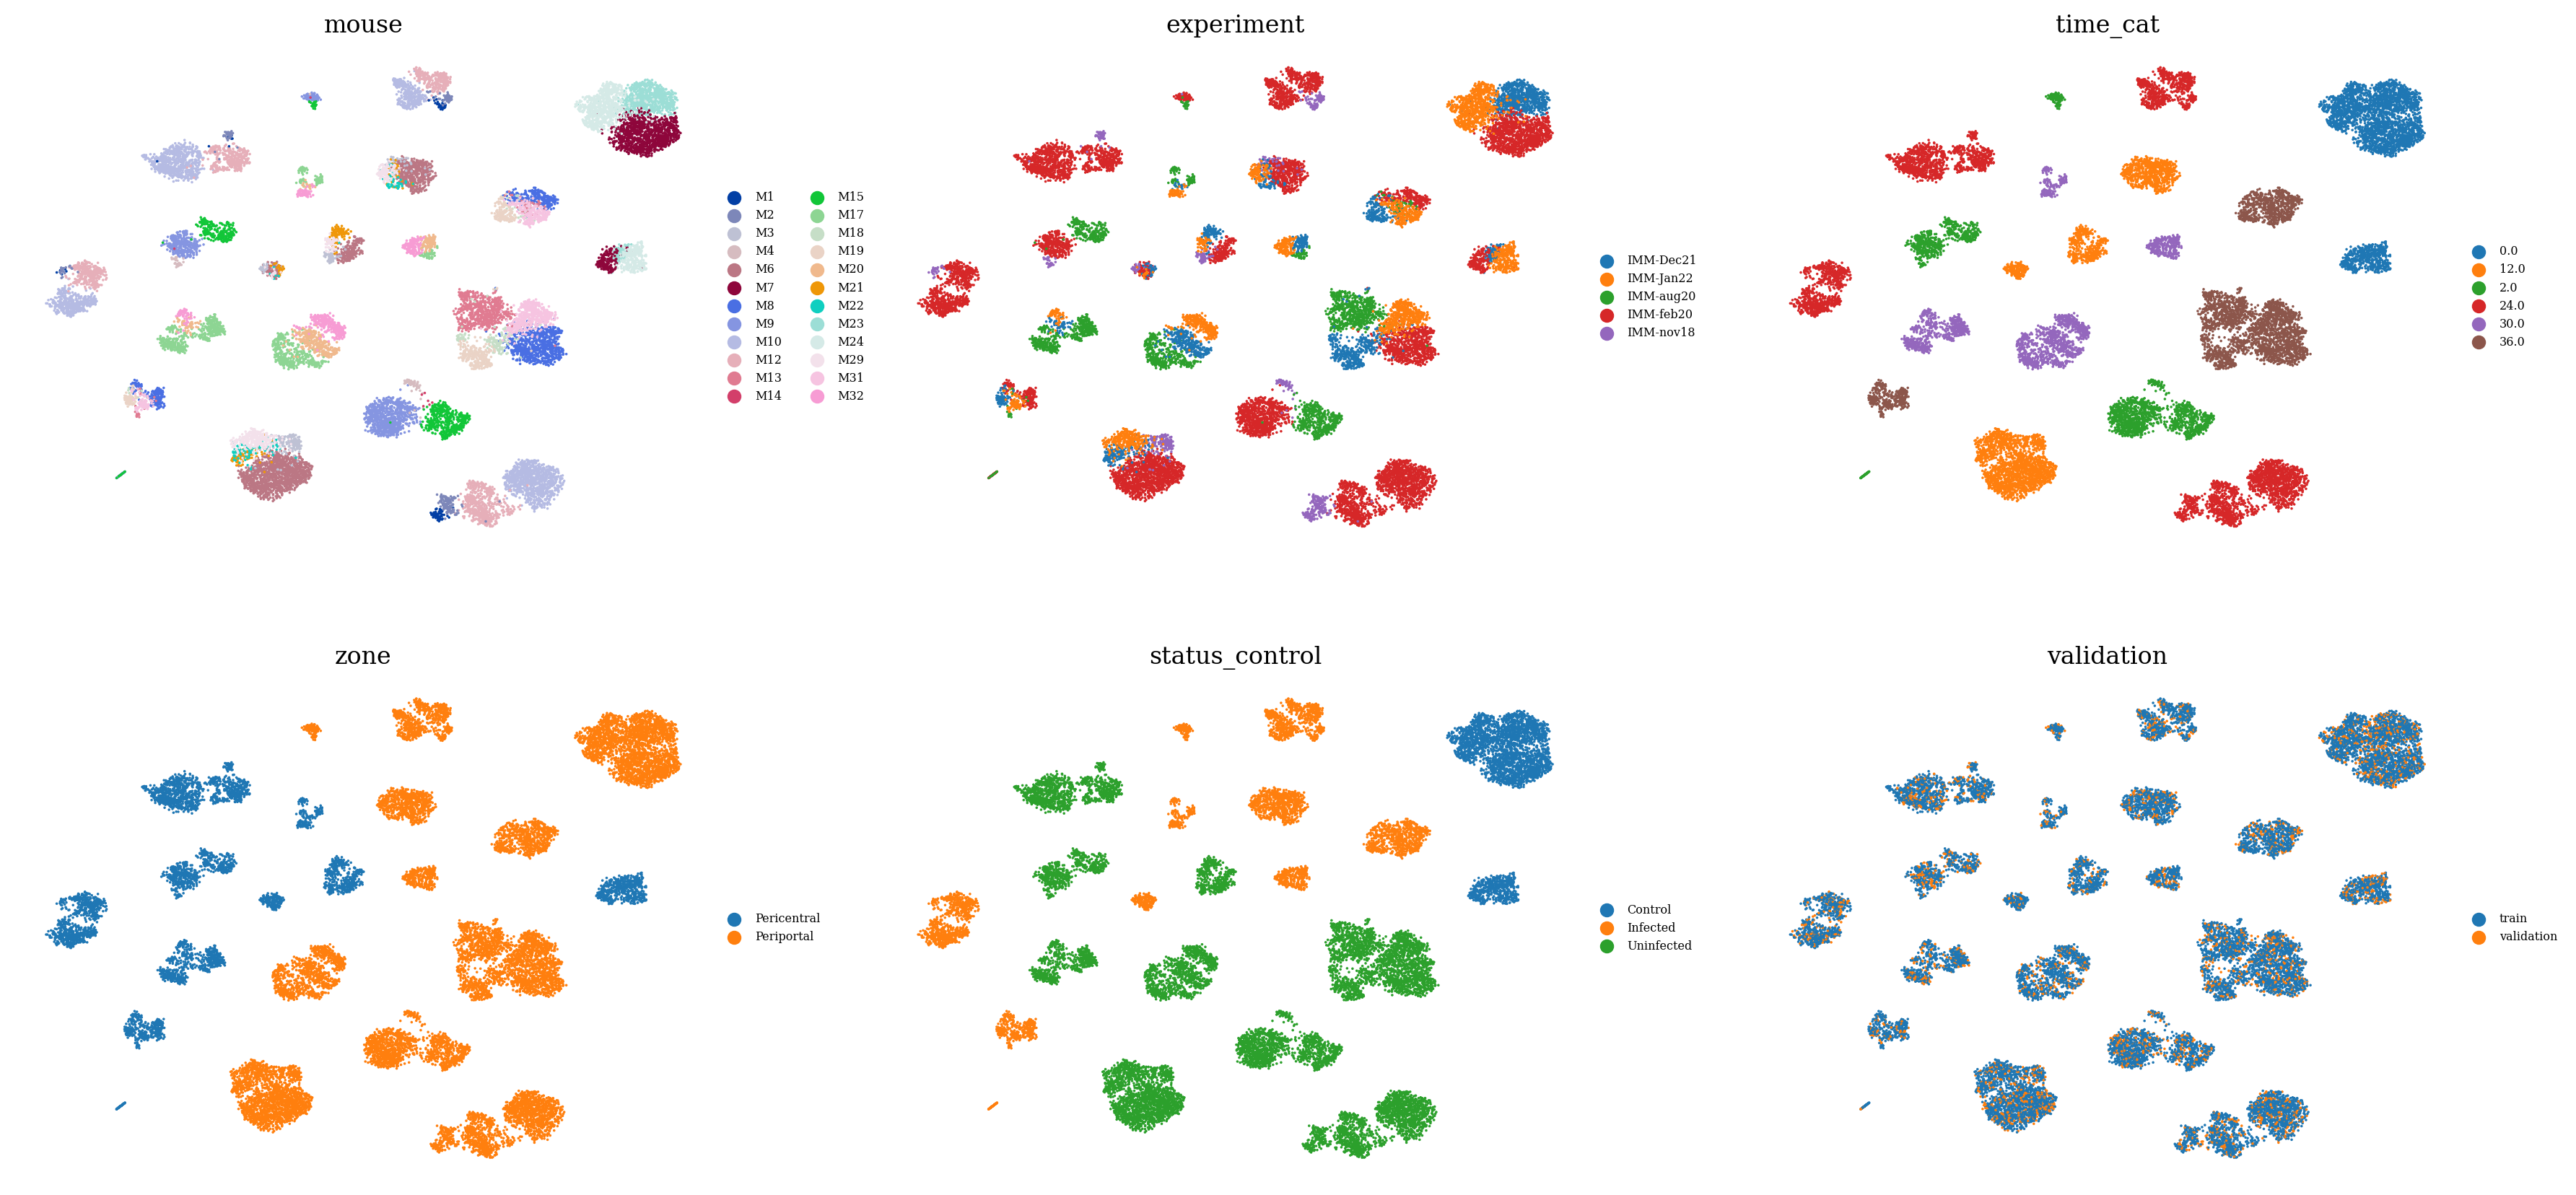

In [14]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

## Preds

In [15]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [16]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


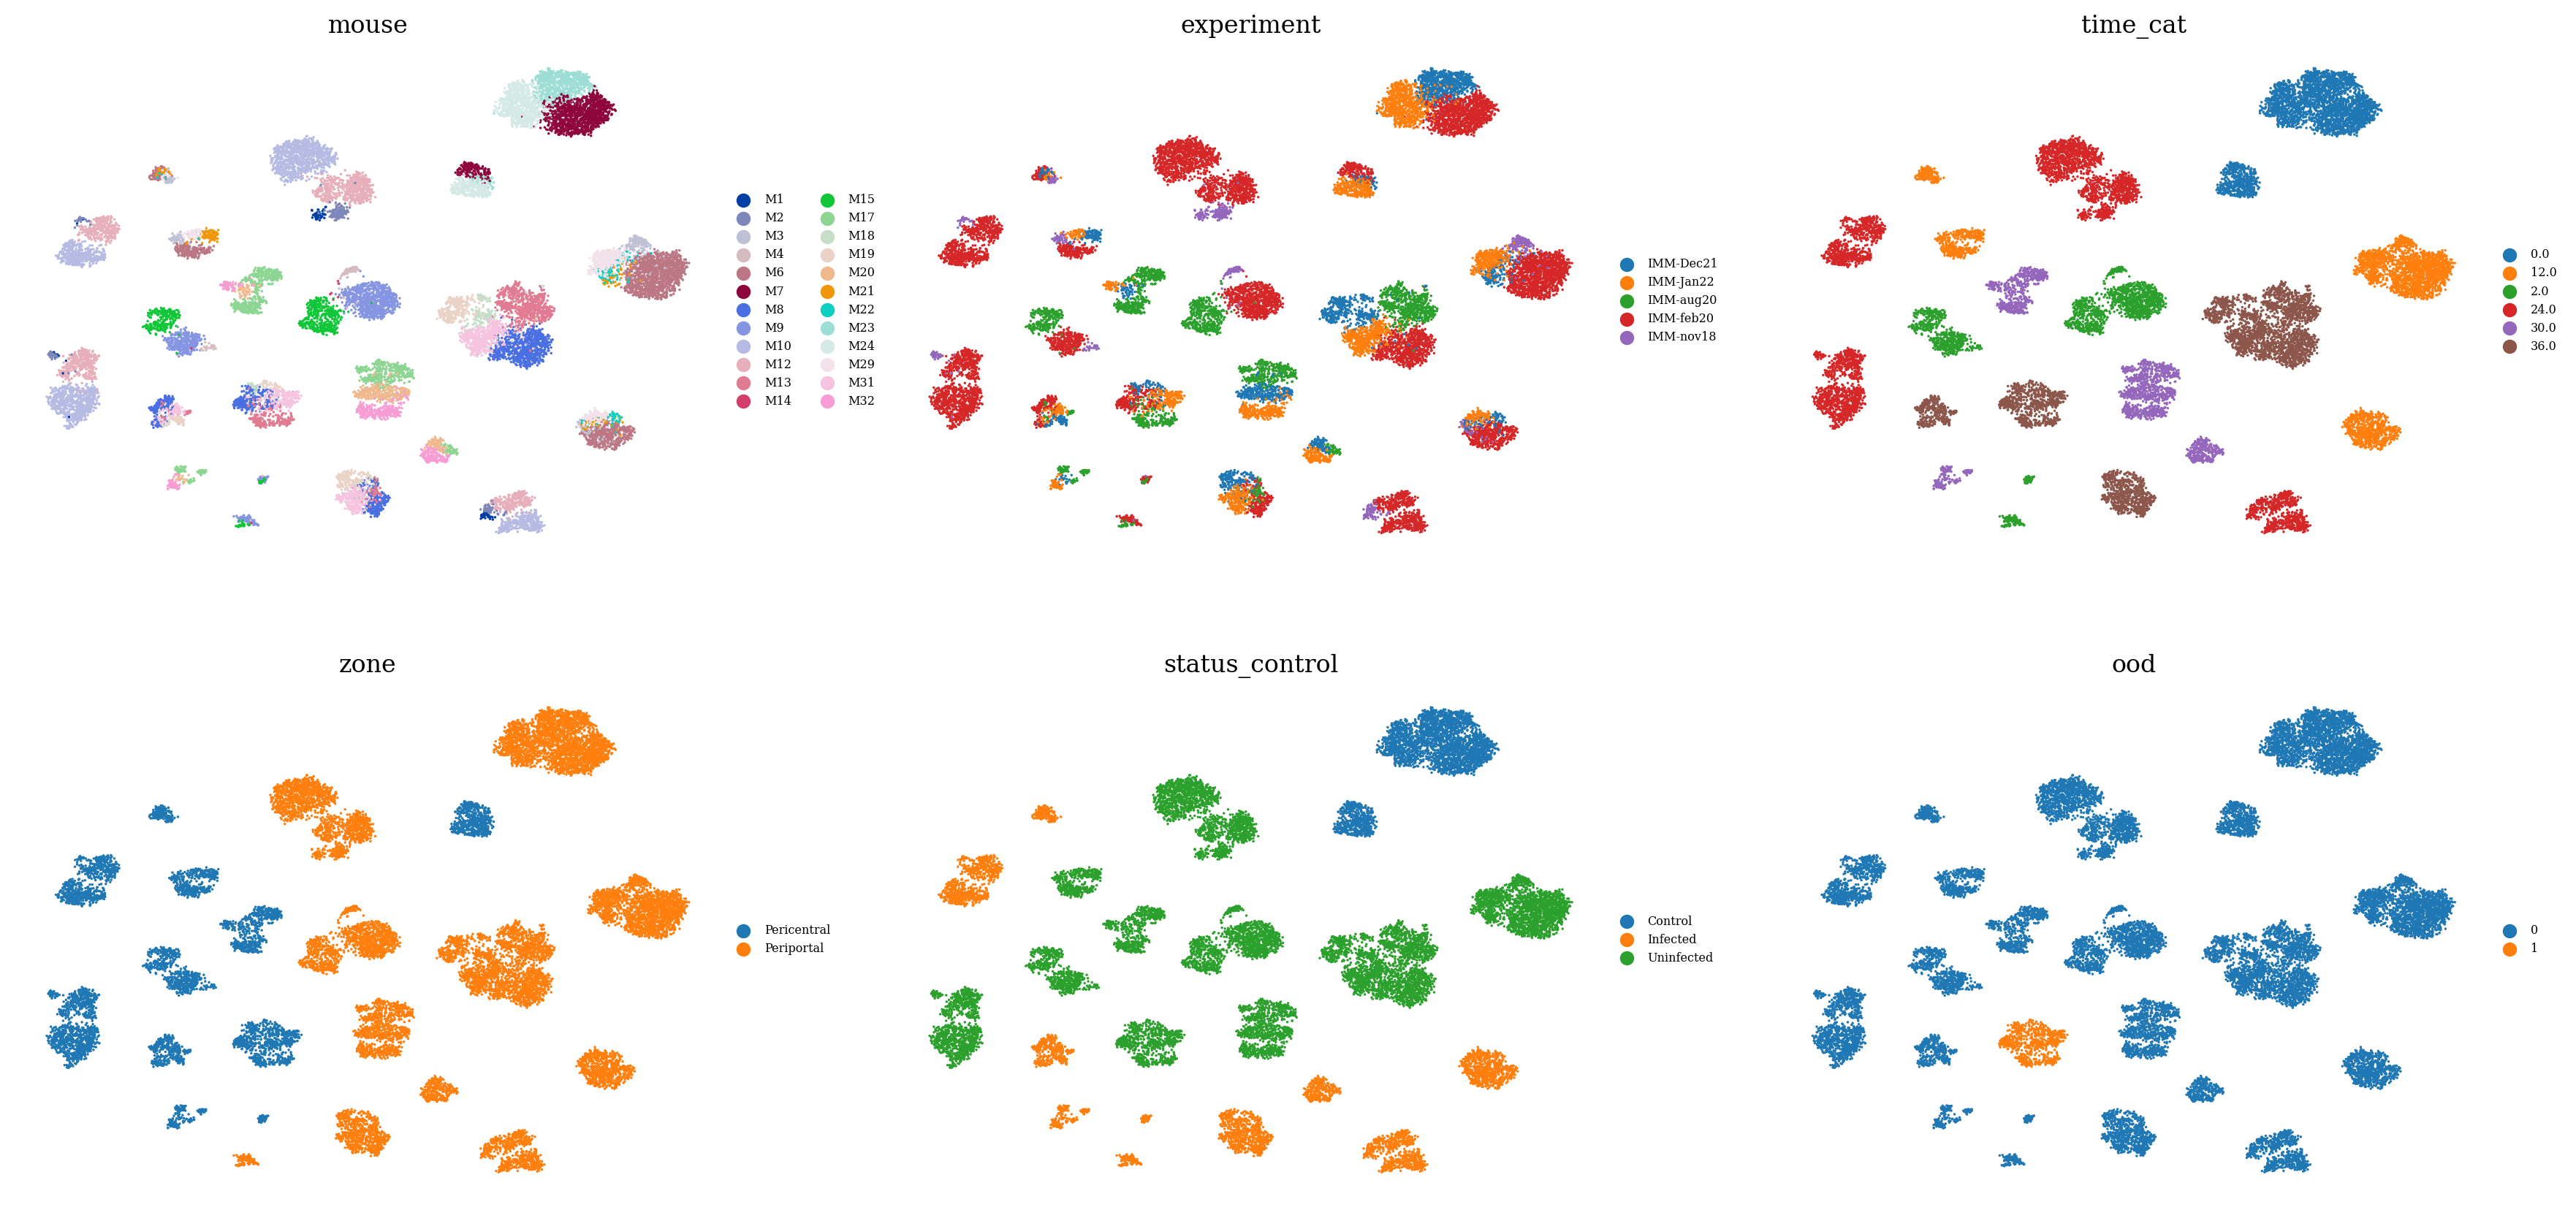

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "ood"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [18]:
k = "status_control"

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.45310449797932084


F1 Weighted: 0.45334385844950625



{'accuracy': 1.0,
 'precision_macro': 1.0,
 'recall_macro': 1.0,
 'f1_score_macro': 1.0,
 'precision_micro': 1.0,
 'recall_micro': 1.0,
 'f1_score_micro': 1.0,
 'precision_weighted': 1.0,
 'recall_weighted': 1.0,
 'f1_score_weighted': 1.0,
 'confusion_matrix': array([[775]])}

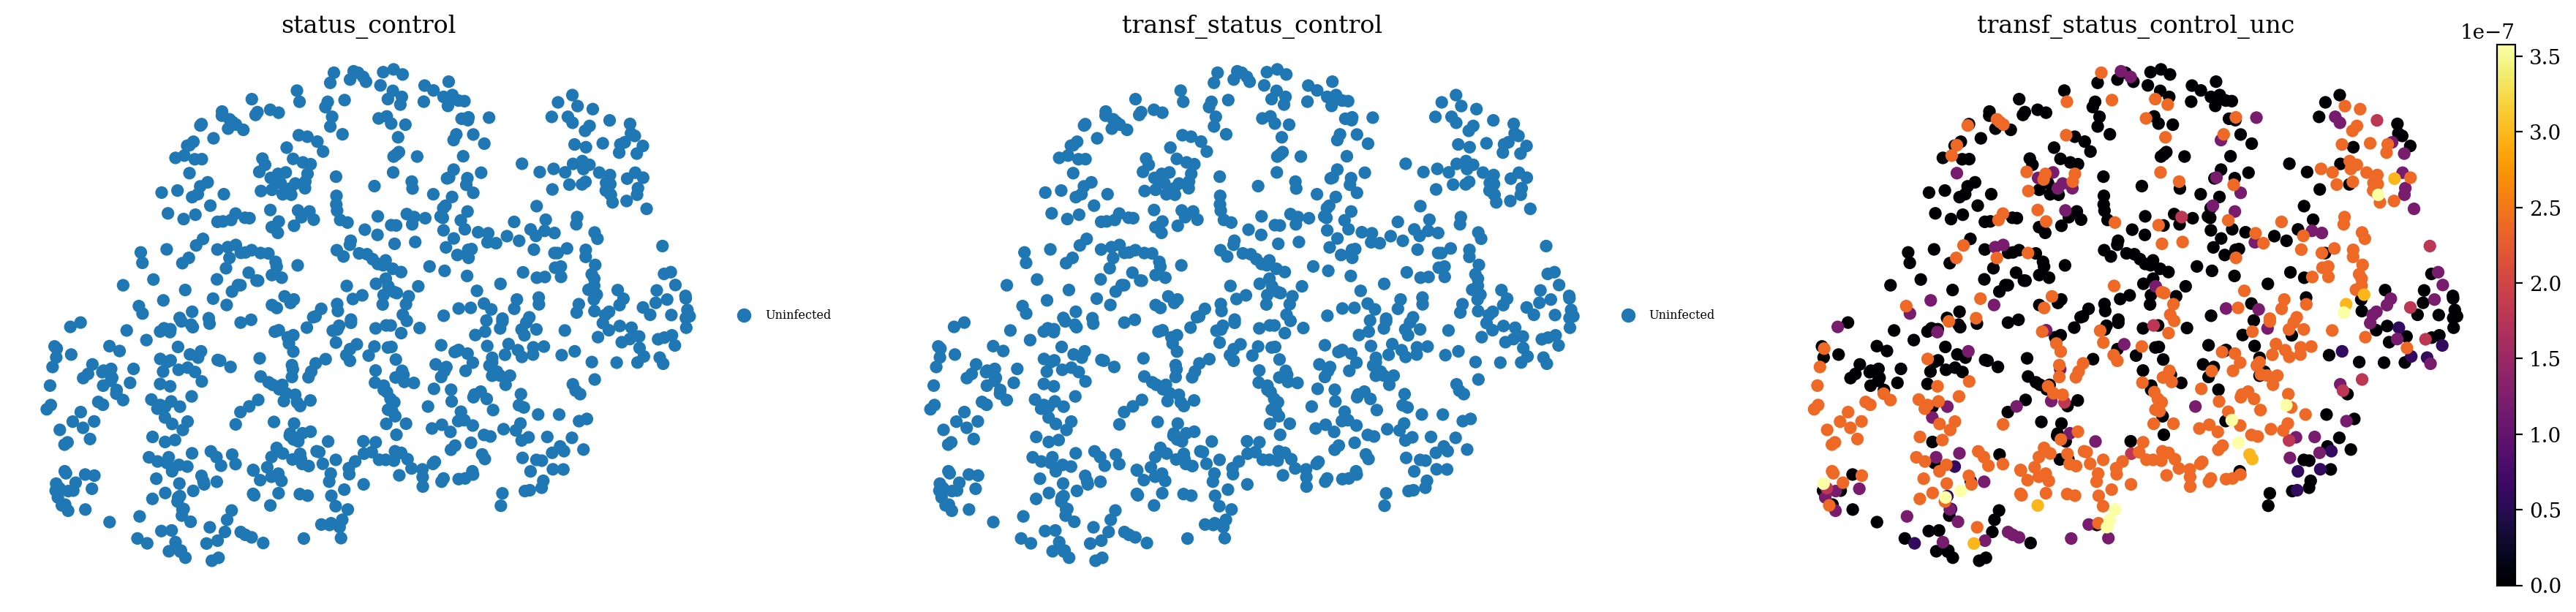

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [20]:
k = "status_control"

latent = ad.AnnData(X=vae.get_latent_representation(adata), obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood), obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.45851047079200125


F1 Weighted: 0.4585772082824724



{'accuracy': 0.8903225806451613,
 'precision_macro': 0.5,
 'recall_macro': 0.44516129032258067,
 'f1_score_macro': 0.4709897610921502,
 'precision_micro': 0.8903225806451613,
 'recall_micro': 0.8903225806451613,
 'f1_score_micro': 0.8903225806451613,
 'precision_weighted': 1.0,
 'recall_weighted': 0.8903225806451613,
 'f1_score_weighted': 0.9419795221843005,
 'confusion_matrix': array([[  0,   0],
        [ 85, 690]])}